In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler
from scipy.cluster.hierarchy import linkage, fcluster
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Section 1. Numerical Analysis

## Data Preprocessing

### Data Preprocessing By Year
The data had to be preprocessed separately for each year as there were minor differences from year to year. 

### 2015

In [ ]:
data_15=pd.read_csv('2015-Table 1.csv')

#Remove CoC name column (unwanted - as of now)
data_15 = data_15.drop('CoC Name',axis=1)

#Handle Missing Values
#Remove rows where >= 1 columns have NaN values (this also removes Totals row)
remove=[]
for i in range(len(data_15)):
    if data_15.loc[i].isnull().sum()>=1:
        remove.append(i)
data_15 = data_15.drop(remove, axis=0)

data_15 = data_15.astype(str)

#Converting to num columns int type
data_15 = data_15.apply(lambda x:x.str.replace(',',''))

cols_with_missing = []
for i in data_15.iloc[:,1:].columns:
    try:
        data_15[i].astype(float).astype(int)
    except ValueError:
        cols_with_missing.append(i)
        #print(i)

#Can impute missing values (' ') with median. 

data_15[cols_with_missing] = data_15[cols_with_missing].apply(pd.to_numeric, errors='coerce')

data_15[cols_with_missing] = data_15[cols_with_missing].fillna(data_15[cols_with_missing].median())

data_15.iloc[:,1:] = data_15.iloc[:,1:].astype(float).astype(int)

updated_cols = []
for j in data_15.columns:
    if 'CoC' in j:
        pass
    else:
        j=j[:-6]
        j=j.strip()
        j=j.title()
        updated_cols.append(j)
data_15.columns = ['CoC Number'] + updated_cols

##Hispanic/Latino and Hispanic/Non-Latino
#Removing comparison by ethnicity

hisp_lat = [i for i in data_15.columns if ('Hispanic' in i)|('Latino' in i)]
data_15 = data_15.drop(hisp_lat,axis=1)

##People in Families & Individuals

#Note: Total/Overall - People in Families + Individuals. Can remove People in Families AND Individuals distinction since we might not perform analysis based on this. Can keep only combination, i.e., Overall. 

#Remove Individual/Family
individuals = [i for i in data_15.columns if 'Individuals' in i]
families = [i for i in data_15.columns if 'People In Families' in i]
data_15 = data_15.drop(individuals+families,axis=1)

#Age (Under 18, 18-24, Over 24)
errors_idx_age = data_15[data_15['Overall Homeless - Under 18']+data_15['Overall Homeless - Age 18 To 24']
            +data_15['Overall Homeless - Over 24'] != 
            data_15['Overall Homeless']].index

#Race
race_cols = [i for i in data_15.columns if any(ele in i for ele in ['American','African','Black','White','Asian','Hawaiian','Multiple'])]
overall_race_cols = [i for i in race_cols if 'Overall Homeless -' in i]

race_sum=[0 for i in range(len(data_15))]
for r in range(len(data_15)):
    for i in overall_race_cols:
        race_sum[r]+=data_15.loc[r,i]

errors_idx_race = data_15[race_sum!=data_15['Overall Homeless']].index

#Gender
errors_idx_gender = data_15[data_15['Overall Homeless - Female']+data_15['Overall Homeless - Male']+data_15['Overall Homeless - Transgender']!= data_15['Overall Homeless']].index

gender_cols = ['Overall Homeless - Female', 'Overall Homeless - Male','Overall Homeless - Transgender']
age_cols = ['Overall Homeless - Under 18','Overall Homeless - Age 18 To 24',
    'Overall Homeless - Over 24']
errors_cols=gender_cols+age_cols+overall_race_cols

errors_idx = sorted(list(set.intersection(*[set(errors_idx_age),set(errors_idx_race),set(errors_idx_gender)])))

#Case 1: gender = age = race - Overall Homeless = age<br>
#Case 2: gender = age & gender!= race - Overall Homeless = age, fix race?<br>
#Case 3: gender != age & gender = race - Overall Homeless = gender, fix age?<br>
#Case 4: gender != age & age = race - Overall Homeless = age, fix gender?<br>
#Case 5: gender != age & age != race - Drop

if len(errors_idx)>0:
    same_sum_count=0
    diff_sum_count = 0
    drop_rows = []
    for i in errors_idx:
        if sum(data_15.loc[i,gender_cols]) == sum(data_15.loc[i,age_cols]) == sum(data_15.loc[i,overall_race_cols]):
            #data_15.loc[i,'Overall Homeless'] = sum(data_15.loc[i,age_cols]) 
            same_sum_count += 1
        else:
            diff_sum_count += 1
            drop_rows.append(i)

    for i in errors_idx:
        gender_sum = sum(data_15.loc[i,gender_cols])
        age_sum = sum(data_15.loc[i,age_cols])
        race_sum = sum(data_15.loc[i,overall_race_cols])
        if gender_sum == age_sum == race_sum:
            data_15.loc[i,'Overall Homeless'] = age_sum
        elif gender_sum == age_sum != race_sum:
            data_15.loc[i,'Overall Homeless'] = age_sum
            if race_sum>age_sum:
                data_15.loc[i,'Overall Homeless - White'] -= abs(age_sum-race_sum)
            else:
                data_15.loc[i,'Overall Homeless - White'] += abs(age_sum-race_sum)
        elif gender_sum == race_sum != age_sum:
            data_15.loc[i,'Overall Homeless'] = gender_sum
            if age_sum>race_sum:
                data_15.loc[i,'Overall Homeless - Over 24'] -= abs(age_sum-race_sum)
            else:
                data_15.loc[i,'Overall Homeless - Over 24'] += abs(age_sum-race_sum)
        elif age_sum == race_sum != gender_sum:
            data_15.loc[i,'Overall Homeless'] = age_sum
            if gender_sum > age_sum:
                data_15.loc[i,'Overall Homeless - Male'] -= abs(age_sum-gender_sum)
            else:
                data_15.loc[i,'Overall Homeless - Male'] += abs(age_sum-gender_sum)
        else:
            drop_rows.append(i)

    data_15 = data_15.drop(drop_rows,axis=0).reset_index(drop=True)

    errors_idx_age = data_15[data_15['Overall Homeless - Under 18']+data_15['Overall Homeless - Age 18 To 24']
            +data_15['Overall Homeless - Over 24'] != 
            data_15['Overall Homeless']].index

    race_cols = [i for i in data_15.columns if any(ele in i for ele in ['American','African','Black','White','Asian','Hawaiian','Multiple'])]
    overall_race_cols = [i for i in race_cols if 'Overall Homeless -' in i]

    race_sum=[0 for i in range(len(data_15))]
    for r in range(len(data_15)):
        for i in overall_race_cols:
            race_sum[r]+=data_15.loc[r,i]

    errors_idx_race = data_15[race_sum!=data_15['Overall Homeless']].index

    errors_idx_gender = data_15[data_15['Overall Homeless - Female']+data_15['Overall Homeless - Male']+data_15['Overall Homeless - Transgender']+data_15['Overall Homeless - Gender Non-Conforming'] != data_15['Overall Homeless']].index

    errors_idx_new = []
    errors_idx_new.extend(errors_idx_age)
    errors_idx_new.extend(errors_idx_race)
    errors_idx_new.extend(errors_idx_gender)
    errors_idx_new = sorted(list(set(errors_idx_new)))

    if len(errors_idx)/len(data_15) < 0.25:
        data_15 = data_15.drop(errors_idx,axis=0).reset_index(drop=True)
    else:
        print('Too many errors!')

##Parenting Youth

#Note: Parenting Youth Under 25 has more sub-categories (like gender, race, etc.) than Parenting Youth Under 18 and 18-24. Under 18 and 18-24 columns have only Sheltered and Unsheltered -Drop Parenting Youth.

#Remove Parenting Youth and Children of Parenting Youth
data_15 = data_15.drop([i for i in data_15.columns if 'Parenting Youth' in i],axis=1)

##Combining Columns

#Age

#Note:Total/Overall = Under 18 + 18-24 + Over 24. Combine 18-24 and Over 24 - make this 18+ column for all categories.

age18_24 = [i for i in data_15.columns if 'Age 18 To 24' in i]

over_24 = [i for i in data_15.columns if 'Over 24' in i]

s1 = ' - Age 18 To 24'
s2 = ' - Over 24'
d1 = {i:i.replace(s1,'') for i in age18_24}
d2 = {i:i.replace(s2,'') for i in over_24}
assert list(d1.values())==list(d2.values()), 'Columns/Column Names between 18-24 and Over 24 are different after truncating'

for (i,j) in zip(d1.keys(),d2.keys()):
    if d1[i]==d2[j]:
        data_15[str(d1[i])+' - Over 18'] = data_15[i]+data_15[j]

data_15 = data_15.drop(list(d1.keys())+list(d2.keys()),axis=1)

##Gender

trans = [i for i in data_15.columns if 'Trans' in i]
ques = [i for i in data_15.columns if 'Gender Questioning' in i]
not_singular = [i for i in data_15.columns if ('Gender That Is Not Singularly' in i)|('Gender Non-Conforming' in i)]

s1 = ' - Transgender'
s2 = ' - Gender Questioning'
s3 = ' - Gender That Is Not Singularly Female Or Male'
s4 = ' - Gender Non-Conforming'
d1 = {i:i.replace(s1,'') for i in trans}
d2 = {i:i.replace(s2,'') for i in ques}
d3 = {i:i.replace(s3,'') for i in not_singular}
d3 = {i:i.replace(s4,'') for i in not_singular}

if len(trans)>0 & len(ques)>0:
    assert list(d1.values())==list(d2.values()), 'Columns/Column Names between Trans and Gender Questioning are different after truncating'
if len(not_singular)>0 & len(ques)>0:
    assert list(d2.values())==list(d3.values()), 'Columns/Column Names between Gender Questioning and Not Singular are different after truncating'
if len(not_singular)>0 & len(trans)>0:
    assert list(d1.values())==list(d3.values()), 'Columns/Column Names between Trans and Not Singular are different after truncating'

if (len(d1)>0)&(len(d2)>0)&(len(d3)>0):
    for (i,j,k) in zip(d1.keys(),d2.keys(),d3.keys()):
        if (len(d1[i])>0)&(len(d2[j])>0)&(len(d3[k])>0):
            if d1[i]==d2[j]==d3[k]:
                data_15[str(d1[i])+' - Others'] = data_15[i]+data_15[j]+data_15[k]
    data_15 = data_15.drop(list(d1.keys())+list(d2.keys())+list(d3.keys()),axis=1)
elif (len(d1)>0)&(len(d2)>0):
    for (i,j) in zip(d1.keys(),d2.keys()):
        if (len(d1[i])>0)&(len(d2[j])>0):
            if d1[i]==d2[j]:
                data_15[str(d1[i])+' - Others'] = data_15[i]+data_15[j]
    data_15 = data_15.drop(list(d1.keys())+list(d2.keys()),axis=1)
elif (len(d1)>0)&(len(d3)>0):
    for (i,k) in zip(d1.keys(),d3.keys()):
        if (len(d1[i])>0)&(len(d3[k])>0):
            if d1[i]==d3[k]:
                data_15[str(d1[i])+' - Others'] = data_15[i]+data_15[k]
    data_15 = data_15.drop(list(d1.keys())+list(d3.keys()),axis=1)
elif (len(d2)>0)&(len(d3)>0):
    for (j,k) in zip(d2.keys(),d3.keys()):
        if (len(d2[j])>0)&(len(d3[k])>0):
            if d2[j]==d3[k]:
                data_15[str(d2[j])+' - Others'] = data_15[j]+data_15[k]
    data_15 = data_15.drop(list(d3.keys())+list(d2.keys()),axis=1)
else:
    print('No Other Gender columns!')

trans_replace = {i:i.replace('Transgender','Others') for i in data_15.columns if 'Trans' in i}

data_15.rename(columns=trans_replace,inplace=True)

#Can keep only Sheltered Total (remove sub-categories: ES, TH, SH)

sheltered_drop = [i for i in data_15.columns if ('Sheltered' in i)&('Total' not in i)]
data_15 = data_15.drop(sheltered_drop,axis=1)

tot=['Total']
for i in range(1,len(data_15.columns)):
    tot.append(data_15.iloc[:,i].sum())
data_15.loc[len(data_15.index)]=tot

data_15['Year'] = 2015

data_15.to_csv('2015_processed.csv',index=False)

### 2016

In [ ]:
data_16=pd.read_csv('2016-Table 1.csv')

#Remove CoC name column (unwanted - as of now)
data_16 = data_16.drop('CoC Name',axis=1)

#Handle Missing Values
#Remove rows where >= 1 columns have NaN values (this also removes Totals row)
remove=[]
for i in range(len(data_16)):
    if data_16.loc[i].isnull().sum()>=1:
        remove.append(i)
data_16 = data_16.drop(remove, axis=0)

data_16 = data_16.astype(str)

#Converting to num columns int type
data_16 = data_16.apply(lambda x:x.str.replace(',',''))

cols_with_missing = []
for i in data_16.iloc[:,1:].columns:
    try:
        data_16[i].astype(float).astype(int)
    except ValueError:
        cols_with_missing.append(i)
        #print(i)

#Can impute missing values (' ') with median. 

data_16[cols_with_missing] = data_16[cols_with_missing].apply(pd.to_numeric, errors='coerce')

data_16[cols_with_missing] = data_16[cols_with_missing].fillna(data_16[cols_with_missing].median())

data_16.iloc[:,1:] = data_16.iloc[:,1:].astype(float).astype(int)

updated_cols = []
for j in data_16.columns:
    if 'CoC' in j:
        pass
    else:
        j=j[:-6]
        j=j.strip()
        j=j.title()
        updated_cols.append(j)
data_16.columns = ['CoC Number'] + updated_cols

#Hispanic/Latino and Hispanic/Non-Latino
#Removing comparison by ethnicity

hisp_lat = [i for i in data_16.columns if ('Hispanic' in i)|('Latino' in i)]
data_16 = data_16.drop(hisp_lat,axis=1)

##People in Families & Individuals

#Note: Total/Overall - People in Families + Individuals. Can remove People in Families AND Individuals distinction since we might not perform analysis based on this. Can keep only combination, i.e., Overall. 

#Remove Individual/Family
individuals = [i for i in data_16.columns if 'Individuals' in i]
families = [i for i in data_16.columns if 'People In Families' in i]
data_16 = data_16.drop(individuals+families,axis=1)

#Age (Under 18, 18-24, Over 24)
errors_idx_age = data_16[data_16['Overall Homeless - Under 18']+data_16['Overall Homeless - Age 18 To 24']
            +data_16['Overall Homeless - Over 24'] != 
            data_16['Overall Homeless']].index

#Unaccompanied Youth - Age (Under 18, 18-24, Under 25) - MOVE BELOW (Combining for Unaccompnied Youth)
errors_idx_age_uy = data_16[data_16['Overall Homeless Unaccompanied Youth Under 18']
            +data_16['Overall Homeless Unaccompanied Youth Age 18-24'] != 
            data_16['Overall Homeless Unaccompanied Youth (Under 25)']].index

#Race
race_cols = [i for i in data_16.columns if any(ele in i for ele in ['American','African','Black','White','Asian','Hawaiian','Multiple'])]
overall_race_cols = [i for i in race_cols if 'Overall Homeless -' in i]

race_sum=[0 for i in range(len(data_16))]
for r in range(len(data_16)):
    for i in overall_race_cols:
        race_sum[r]+=data_16.loc[r,i]

errors_idx_race = data_16[race_sum!=data_16['Overall Homeless']].index

#Gender
errors_idx_gender = data_16[data_16['Overall Homeless - Female']+data_16['Overall Homeless - Male']+data_16['Overall Homeless - Transgender']!= data_16['Overall Homeless']].index

gender_cols = ['Overall Homeless - Female', 'Overall Homeless - Male','Overall Homeless - Transgender']
age_cols = ['Overall Homeless - Under 18','Overall Homeless - Age 18 To 24',
    'Overall Homeless - Over 24']
errors_cols=gender_cols+age_cols+overall_race_cols

errors_idx = sorted(list(set.intersection(*[set(errors_idx_age),set(errors_idx_race),set(errors_idx_gender)])))

# Case 1: gender = age = race - Overall Homeless = age<br>
# Case 2: gender = age & gender!= race - Overall Homeless = age, fix race?<br>
# Case 3: gender != age & gender = race - Overall Homeless = gender, fix age?<br>
# Case 4: gender != age & age = race - Overall Homeless = age, fix gender?<br>
# Case 5: gender != age & age != race - Drop

if len(errors_idx)>0:
    same_sum_count=0
    diff_sum_count = 0
    drop_rows = []
    for i in errors_idx:
        if sum(data_16.loc[i,gender_cols]) == sum(data_16.loc[i,age_cols]) == sum(data_16.loc[i,overall_race_cols]):
            #data_16.loc[i,'Overall Homeless'] = sum(data_16.loc[i,age_cols]) 
            same_sum_count += 1
        else:
            diff_sum_count += 1
            drop_rows.append(i)

    for i in errors_idx:
        gender_sum = sum(data_16.loc[i,gender_cols])
        age_sum = sum(data_16.loc[i,age_cols])
        race_sum = sum(data_16.loc[i,overall_race_cols])
        if gender_sum == age_sum == race_sum:
            data_16.loc[i,'Overall Homeless'] = age_sum
        elif gender_sum == age_sum != race_sum:
            data_16.loc[i,'Overall Homeless'] = age_sum
            if race_sum>age_sum:
                data_16.loc[i,'Overall Homeless - White'] -= abs(age_sum-race_sum)
            else:
                data_16.loc[i,'Overall Homeless - White'] += abs(age_sum-race_sum)
        elif gender_sum == race_sum != age_sum:
            data_16.loc[i,'Overall Homeless'] = gender_sum
            if age_sum>race_sum:
                data_16.loc[i,'Overall Homeless - Over 24'] -= abs(age_sum-race_sum)
            else:
                data_16.loc[i,'Overall Homeless - Over 24'] += abs(age_sum-race_sum)
        elif age_sum == race_sum != gender_sum:
            data_16.loc[i,'Overall Homeless'] = age_sum
            if gender_sum > age_sum:
                data_16.loc[i,'Overall Homeless - Male'] -= abs(age_sum-gender_sum)
            else:
                data_16.loc[i,'Overall Homeless - Male'] += abs(age_sum-gender_sum)
        else:
            drop_rows.append(i)

    data_16 = data_16.drop(drop_rows,axis=0).reset_index(drop=True)

    errors_idx_age = data_16[data_16['Overall Homeless - Under 18']+data_16['Overall Homeless - Age 18 To 24']
            +data_16['Overall Homeless - Over 24'] != 
            data_16['Overall Homeless']].index

    race_cols = [i for i in data_16.columns if any(ele in i for ele in ['American','African','Black','White','Asian','Hawaiian','Multiple'])]
    overall_race_cols = [i for i in race_cols if 'Overall Homeless -' in i]

    race_sum=[0 for i in range(len(data_16))]
    for r in range(len(data_16)):
        for i in overall_race_cols:
            race_sum[r]+=data_16.loc[r,i]

    errors_idx_race = data_16[race_sum!=data_16['Overall Homeless']].index

    errors_idx_gender = data_16[data_16['Overall Homeless - Female']+data_16['Overall Homeless - Male']+data_16['Overall Homeless - Transgender']+data_16['Overall Homeless - Gender Non-Conforming'] != data_16['Overall Homeless']].index

    errors_idx_new = []
    errors_idx_new.extend(errors_idx_age)
    errors_idx_new.extend(errors_idx_race)
    errors_idx_new.extend(errors_idx_gender)
    errors_idx_new = sorted(list(set(errors_idx_new)))

    if len(errors_idx)/len(data_16) < 0.25:
        data_16 = data_16.drop(errors_idx,axis=0).reset_index(drop=True)
    else:
        print('Too many errors!')

#Unaccompanied Youth - Under 18, 18-24, Under 25.

errors_idx_uy = data_16[data_16['Overall Homeless Unaccompanied Youth Under 18']
            +data_16['Overall Homeless Unaccompanied Youth Age 18-24'] != 
            data_16['Overall Homeless Unaccompanied Youth (Under 25)']].index
if len(errors_idx_uy)>0:
    for i in errors_idx_uy:
        data_16.loc[i,'Overall Homeless Unaccompanied Youth (Under 25)'] = data_16.loc[i,'Overall Homeless Unaccompanied Youth Under 18']+data_16.loc[i,'Overall Homeless Unaccompanied Youth Age 18-24']

    assert sum(data_16['Overall Homeless Unaccompanied Youth Under 18']+data_16['Overall Homeless Unaccompanied Youth Age 18-24'] != data_16['Overall Homeless Unaccompanied Youth (Under 25)'])==0

#Note: Unaccompanied Youth Under 25 = Unaccompanied Youth Under 18 + Unaccompanied Youth Age 18-24.

#Decision: Perform analysis only on Overall Unaccompanied Youth (split into sub categories of Gender and Race) - Drop non-overall columns (apart from overall, it is split into Sheltered (and its subcategories)

unaccompanied_drop = [i for i in data_16.columns if ('Unaccompanied Youth (Under 25)' in i)&('Overall' not in i)]

unaccompanied_under_18 = [i for i in data_16.columns if 'Unaccompanied Youth Under 18' in i]

unaccompanied_18_24 = [i for i in data_16.columns if 'Unaccompanied Youth Age 18-24' in i]

#Note: Unaccompanied Youth Under 25 has more sub-categories (like gender, race, etc.) than Unaccompanied Youth Under 18 and 18-24. Under 18 and 18-24 columns have only Sheltered and Unsheltered - Drop Under 18 and 18-24 columns, keep their combination, i.e., Under 25.

data_16 = data_16.drop(unaccompanied_under_18+unaccompanied_18_24+unaccompanied_drop,axis=1)

#Parenting Youth

#Note: Parenting Youth Under 25 has more sub-categories (like gender, race, etc.) than Parenting Youth Under 18 and 18-24. Under 18 and 18-24 columns have only Sheltered and Unsheltered -  - Drop Parenting Youth.

#Remove Parenting Youth and Children of Parenting Youth
data_16 = data_16.drop([i for i in data_16.columns if 'Parenting Youth' in i],axis=1)

#Combining Columns

#Age

#Note: Total/Overall = Under 18 + 18-24 + Over 24. Combine 18-24 and Over 24 - make this 18+ column for all categories.

age18_24 = [i for i in data_16.columns if 'Age 18 To 24' in i]

over_24 = [i for i in data_16.columns if 'Over 24' in i]

s1 = ' - Age 18 To 24'
s2 = ' - Over 24'
d1 = {i:i.replace(s1,'') for i in age18_24}
d2 = {i:i.replace(s2,'') for i in over_24}
assert list(d1.values())==list(d2.values()), 'Columns/Column Names between 18-24 and Over 24 are different after truncating'

for (i,j) in zip(d1.keys(),d2.keys()):
    if d1[i]==d2[j]:
        data_16[str(d1[i])+' - Over 18'] = data_16[i]+data_16[j]

data_16 = data_16.drop(list(d1.keys())+list(d2.keys()),axis=1)

#Gender

trans = [i for i in data_16.columns if 'Trans' in i]
ques = [i for i in data_16.columns if 'Gender Questioning' in i]
not_singular = [i for i in data_16.columns if ('Gender That Is Not Singularly' in i)|('Gender Non-Conforming' in i)]

s1 = ' - Transgender'
s2 = ' - Gender Questioning'
s3 = ' - Gender That Is Not Singularly Female Or Male'
s4 = ' - Gender Non-Conforming'
d1 = {i:i.replace(s1,'') for i in trans}
d2 = {i:i.replace(s2,'') for i in ques}
d3 = {i:i.replace(s3,'') for i in not_singular}
d3 = {i:i.replace(s4,'') for i in not_singular}

if len(trans)>0 & len(ques)>0:
    assert list(d1.values())==list(d2.values()), 'Columns/Column Names between Trans and Gender Questioning are different after truncating'
if len(not_singular)>0 & len(ques)>0:
    assert list(d2.values())==list(d3.values()), 'Columns/Column Names between Gender Questioning and Not Singular are different after truncating'
if len(not_singular)>0 & len(trans)>0:
    assert list(d1.values())==list(d3.values()), 'Columns/Column Names between Trans and Not Singular are different after truncating'

if (len(d1)>0)&(len(d2)>0)&(len(d3)>0):
    for (i,j,k) in zip(d1.keys(),d2.keys(),d3.keys()):
        if (len(d1[i])>0)&(len(d2[j])>0)&(len(d3[k])>0):
            if d1[i]==d2[j]==d3[k]:
                data_16[str(d1[i])+' - Others'] = data_16[i]+data_16[j]+data_16[k]
    data_16 = data_16.drop(list(d1.keys())+list(d2.keys())+list(d3.keys()),axis=1)
elif (len(d1)>0)&(len(d2)>0):
    for (i,j) in zip(d1.keys(),d2.keys()):
        if (len(d1[i])>0)&(len(d2[j])>0):
            if d1[i]==d2[j]:
                data_16[str(d1[i])+' - Others'] = data_16[i]+data_16[j]
    data_16 = data_16.drop(list(d1.keys())+list(d2.keys()),axis=1)
elif (len(d1)>0)&(len(d3)>0):
    for (i,k) in zip(d1.keys(),d3.keys()):
        if (len(d1[i])>0)&(len(d3[k])>0):
            if d1[i]==d3[k]:
                data_16[str(d1[i])+' - Others'] = data_16[i]+data_16[k]
    data_16 = data_16.drop(list(d1.keys())+list(d3.keys()),axis=1)
elif (len(d2)>0)&(len(d3)>0):
    for (j,k) in zip(d2.keys(),d3.keys()):
        if (len(d2[j])>0)&(len(d3[k])>0):
            if d2[j]==d3[k]:
                data_16[str(d2[j])+' - Others'] = data_16[j]+data_16[k]
    data_16 = data_16.drop(list(d3.keys())+list(d2.keys()),axis=1)
else:
    print('No Other Gender columns!')

trans_replace = {i:i.replace('Transgender','Others') for i in data_16.columns if 'Trans' in i}

data_16.rename(columns=trans_replace,inplace=True)

#Can keep only Sheltered Total (remove sub-categories: ES, TH, SH)

sheltered_drop = [i for i in data_16.columns if ('Sheltered' in i)&('Total' not in i)]
data_16 = data_16.drop(sheltered_drop,axis=1)

tot=['Total']
for i in range(1,len(data_16.columns)):
    tot.append(data_16.iloc[:,i].sum())
data_16.loc[len(data_16.index)]=tot

data_16['Year'] = 2016

data_16.to_csv('2016_processed.csv',index=False)

### 2017

In [ ]:
data_17=pd.read_csv('2017-Table 1.csv')

#Remove CoC name column (unwanted - as of now)
data_17 = data_17.drop('CoC Name',axis=1)

#Handle Missing Values
#Remove rows where >= 1 columns have NaN values (this also removes Totals row)
remove=[]
for i in range(len(data_17)):
    if data_17.loc[i].isnull().sum()>=1:
        remove.append(i)
data_17 = data_17.drop(remove, axis=0)

data_17 = data_17.astype(str)

#Converting to num columns int type
data_17 = data_17.apply(lambda x:x.str.replace(',',''))

cols_with_missing = []
for i in data_17.iloc[:,1:].columns:
    try:
        data_17[i].astype(float).astype(int)
    except ValueError:
        cols_with_missing.append(i)
        #print(i)

#Can impute missing values (' ') with median. 

data_17[cols_with_missing] = data_17[cols_with_missing].apply(pd.to_numeric, errors='coerce')

data_17[cols_with_missing] = data_17[cols_with_missing].fillna(data_17[cols_with_missing].median())

data_17.iloc[:,1:] = data_17.iloc[:,1:].astype(float).astype(int)

updated_cols = []
for j in data_17.columns:
    if 'CoC' in j:
        pass
    else:
        j=j[:-6]
        j=j.strip()
        j=j.title()
        updated_cols.append(j)
data_17.columns = ['CoC Number'] + updated_cols

#Hispanic/Latino and Hispanic/Non-Latino 
Removing comparison by ethnicity

hisp_lat = [i for i in data_17.columns if ('Hispanic' in i)|('Latino' in i)]
data_17 = data_17.drop(hisp_lat,axis=1)


#People in Families & Individuals 

#Note : Total/Overall - People in Families + Individuals. Can remove People in Families AND Individuals distinction since we might not perform analysis based on this. Can keep only combination, i.e., Overall. 

#Remove Individual/Family
individuals = [i for i in data_17.columns if 'Individuals' in i]
families = [i for i in data_17.columns if 'People In Families' in i]
data_17 = data_17.drop(individuals+families,axis=1)


#Age (Under 18, 18-24, Over 24)
errors_idx_age = data_17[data_17['Overall Homeless - Under 18']+data_17['Overall Homeless - Age 18 To 24']
            +data_17['Overall Homeless - Over 24'] != 
            data_17['Overall Homeless']].index

#Unaccompanied Youth - Age (Under 18, 18-24, Under 25) - MOVE BELOW (Combining for Unaccompnied Youth)
errors_idx_age_uy = data_17[data_17['Overall Homeless Unaccompanied Youth Under 18']
            +data_17['Overall Homeless Unaccompanied Youth Age 18-24'] != 
            data_17['Overall Homeless Unaccompanied Youth (Under 25)']].index

#Race
race_cols = [i for i in data_17.columns if any(ele in i for ele in ['American','African','Black','White','Asian','Hawaiian','Multiple'])]
overall_race_cols = [i for i in race_cols if 'Overall Homeless -' in i]

race_sum=[0 for i in range(len(data_17))]
for r in range(len(data_17)):
    for i in overall_race_cols:
        race_sum[r]+=data_17.loc[r,i]

errors_idx_race = data_17[race_sum!=data_17['Overall Homeless']].index

#Gender
errors_idx_gender = data_17[data_17['Overall Homeless - Female']+data_17['Overall Homeless - Male']+data_17['Overall Homeless - Transgender']!= data_17['Overall Homeless']].index

gender_cols = ['Overall Homeless - Female', 'Overall Homeless - Male','Overall Homeless - Transgender']
age_cols = ['Overall Homeless - Under 18','Overall Homeless - Age 18 To 24',
    'Overall Homeless - Over 24']
errors_cols=gender_cols+age_cols+overall_race_cols

errors_idx = sorted(list(set.intersection(*[set(errors_idx_age),set(errors_idx_race),set(errors_idx_gender)])))

#Case 1: gender = age = race - Overall Homeless = age<br>
#Case 2: gender = age & gender!= race - Overall Homeless = age, fix race?<br>
#Case 3: gender != age & gender = race - Overall Homeless = gender, fix age?<br>
#Case 4: gender != age & age = race - Overall Homeless = age, fix gender?<br>
#Case 5: gender != age & age != race - Drop


if len(errors_idx)>0:
    same_sum_count=0
    diff_sum_count = 0
    drop_rows = []
    for i in errors_idx:
        if sum(data_17.loc[i,gender_cols]) == sum(data_17.loc[i,age_cols]) == sum(data_17.loc[i,overall_race_cols]):
            same_sum_count += 1
        else:
            diff_sum_count += 1
            drop_rows.append(i)

    for i in errors_idx:
        gender_sum = sum(data_17.loc[i,gender_cols])
        age_sum = sum(data_17.loc[i,age_cols])
        race_sum = sum(data_17.loc[i,overall_race_cols])
        if gender_sum == age_sum == race_sum:
            data_17.loc[i,'Overall Homeless'] = age_sum
        elif gender_sum == age_sum != race_sum:
            data_17.loc[i,'Overall Homeless'] = age_sum
            if race_sum>age_sum:
                data_17.loc[i,'Overall Homeless - White'] -= abs(age_sum-race_sum)
            else:
                data_17.loc[i,'Overall Homeless - White'] += abs(age_sum-race_sum)
        elif gender_sum == race_sum != age_sum:
            data_17.loc[i,'Overall Homeless'] = gender_sum
            if age_sum>race_sum:
                data_17.loc[i,'Overall Homeless - Over 24'] -= abs(age_sum-race_sum)
            else:
                data_17.loc[i,'Overall Homeless - Over 24'] += abs(age_sum-race_sum)
        elif age_sum == race_sum != gender_sum:
            data_17.loc[i,'Overall Homeless'] = age_sum
            if gender_sum > age_sum:
                data_17.loc[i,'Overall Homeless - Male'] -= abs(age_sum-gender_sum)
            else:
                data_17.loc[i,'Overall Homeless - Male'] += abs(age_sum-gender_sum)
        else:
            drop_rows.append(i)

    data_17 = data_17.drop(drop_rows,axis=0).reset_index(drop=True)

    errors_idx_age = data_17[data_17['Overall Homeless - Under 18']+data_17['Overall Homeless - Age 18 To 24']
            +data_17['Overall Homeless - Over 24'] != 
            data_17['Overall Homeless']].index

    race_cols = [i for i in data_17.columns if any(ele in i for ele in ['American','African','Black','White','Asian','Hawaiian','Multiple'])]
    overall_race_cols = [i for i in race_cols if 'Overall Homeless -' in i]

    race_sum=[0 for i in range(len(data_17))]
    for r in range(len(data_17)):
        for i in overall_race_cols:
            race_sum[r]+=data_17.loc[r,i]

    errors_idx_race = data_17[race_sum!=data_17['Overall Homeless']].index

    errors_idx_gender = data_17[data_17['Overall Homeless - Female']+data_17['Overall Homeless - Male']+data_17['Overall Homeless - Transgender']+data_17['Overall Homeless - Gender Non-Conforming'] != data_17['Overall Homeless']].index

    errors_idx_new = []
    errors_idx_new.extend(errors_idx_age)
    errors_idx_new.extend(errors_idx_race)
    errors_idx_new.extend(errors_idx_gender)
    errors_idx_new = sorted(list(set(errors_idx_new)))

    if len(errors_idx)/len(data_17) < 0.25:
        data_17 = data_17.drop(errors_idx,axis=0).reset_index(drop=True)
    else:
        print('Too many errors!')

#Unaccompanied Youth - Under 18, 18-24, Under 25.  

errors_idx_uy = data_17[data_17['Overall Homeless Unaccompanied Youth Under 18']
            +data_17['Overall Homeless Unaccompanied Youth Age 18-24'] != 
            data_17['Overall Homeless Unaccompanied Youth (Under 25)']].index
if len(errors_idx_uy)>0:
    for i in errors_idx_uy:
        data_17.loc[i,'Overall Homeless Unaccompanied Youth (Under 25)'] = data_17.loc[i,'Overall Homeless Unaccompanied Youth Under 18']+data_17.loc[i,'Overall Homeless Unaccompanied Youth Age 18-24']

    assert sum(data_17['Overall Homeless Unaccompanied Youth Under 18']+data_17['Overall Homeless Unaccompanied Youth Age 18-24'] != data_17['Overall Homeless Unaccompanied Youth (Under 25)'])==0

#Note:   Unaccompanied Youth Under 25 = Unaccompanied Youth Under 18 + Unaccompanied Youth Age 18-24.

#Decision: Perform analysis only on Overall Unaccompanied Youth (split into sub categories of Gender and Race) - Drop non-overall columns (apart from overall, it is split into Sheltered (and its subcategories)

unaccompanied_drop = [i for i in data_17.columns if ('Unaccompanied Youth (Under 25)' in i)&('Overall' not in i)]

unaccompanied_under_18 = [i for i in data_17.columns if 'Unaccompanied Youth Under 18' in i]

unaccompanied_18_24 = [i for i in data_17.columns if 'Unaccompanied Youth Age 18-24' in i]

#Note:  Unaccompanied Youth Under 25 has more sub-categories (like gender, race, etc.) than Unaccompanied Youth Under 18 and 18-24. Under 18 and 18-24 columns have only Sheltered and Unsheltered - Drop Under 18 and 18-24 columns, keep their combination, i.e., Under 25.

data_17 = data_17.drop(unaccompanied_under_18+unaccompanied_18_24+unaccompanied_drop,axis=1)

#Parenting Youth 

#Note:  Parenting Youth Under 25 has more sub-categories (like gender, race, etc.) than Parenting Youth Under 18 and 18-24. Under 18 and 18-24 columns have only Sheltered and Unsheltered -  - Drop Under 18 and 18-24 columns, keep their combination, i.e., Under 25. #OR Can drop Parenting Youth altogether. 

#Remove Parenting Youth and Children of Parenting Youth
data_17 = data_17.drop([i for i in data_17.columns if 'Parenting Youth' in i],axis=1)

len(data_17.columns)

#Combining Columns

#Age 

#Note:  Total/Overall = Under 18 + 18-24 + Over 24. Combine 18-24 and Over 24 - make this 18+ column for all categories.

age18_24 = [i for i in data_17.columns if 'Age 18 To 24' in i]

over_24 = [i for i in data_17.columns if 'Over 24' in i]

s1 = ' - Age 18 To 24'
s2 = ' - Over 24'
d1 = {i:i.replace(s1,'') for i in age18_24}
d2 = {i:i.replace(s2,'') for i in over_24}
assert list(d1.values())==list(d2.values()), 'Columns/Column Names between 18-24 and Over 24 are different after truncating'

for (i,j) in zip(d1.keys(),d2.keys()):
    if d1[i]==d2[j]:
        data_17[str(d1[i])+' - Over 18'] = data_17[i]+data_17[j]

data_17 = data_17.drop(list(d1.keys())+list(d2.keys()),axis=1)


#Gender 

trans = [i for i in data_17.columns if 'Trans' in i]
ques = [i for i in data_17.columns if 'Gender Questioning' in i]
not_singular = [i for i in data_17.columns if ('Gender That Is Not Singularly' in i)|('Gender Non-Conforming' in i)]

s1 = ' - Transgender'
s2 = ' - Gender Questioning'
s3 = ' - Gender That Is Not Singularly Female Or Male'
s4 = ' - Gender Non-Conforming'
d1 = {i:i.replace(s1,'') for i in trans}
d2 = {i:i.replace(s2,'') for i in ques}
d3 = {i:i.replace(s3,'') for i in not_singular}
d3 = {i:i.replace(s4,'') for i in not_singular}

if len(trans)>0 & len(ques)>0:
    assert list(d1.values())==list(d2.values()), 'Columns/Column Names between Trans and Gender Questioning are different after truncating'
if len(not_singular)>0 & len(ques)>0:
    assert list(d2.values())==list(d3.values()), 'Columns/Column Names between Gender Questioning and Not Singular are different after truncating'
if len(not_singular)>0 & len(trans)>0:
    assert list(d1.values())==list(d3.values()), 'Columns/Column Names between Trans and Not Singular are different after truncating'

if (len(d1)>0)&(len(d2)>0)&(len(d3)>0):
    for (i,j,k) in zip(d1.keys(),d2.keys(),d3.keys()):
        if (len(d1[i])>0)&(len(d2[j])>0)&(len(d3[k])>0):
            if d1[i]==d2[j]==d3[k]:
                data_17[str(d1[i])+' - Others'] = data_17[i]+data_17[j]+data_17[k]
    data_17 = data_17.drop(list(d1.keys())+list(d2.keys())+list(d3.keys()),axis=1)
elif (len(d1)>0)&(len(d2)>0):
    for (i,j) in zip(d1.keys(),d2.keys()):
        if (len(d1[i])>0)&(len(d2[j])>0):
            if d1[i]==d2[j]:
                data_17[str(d1[i])+' - Others'] = data_17[i]+data_17[j]
    data_17 = data_17.drop(list(d1.keys())+list(d2.keys()),axis=1)
elif (len(d1)>0)&(len(d3)>0):
    for (i,k) in zip(d1.keys(),d3.keys()):
        if (len(d1[i])>0)&(len(d3[k])>0):
            if d1[i]==d3[k]:
                data_17[str(d1[i])+' - Others'] = data_17[i]+data_17[k]
    data_17 = data_17.drop(list(d1.keys())+list(d3.keys()),axis=1)
elif (len(d2)>0)&(len(d3)>0):
    for (j,k) in zip(d2.keys(),d3.keys()):
        if (len(d2[j])>0)&(len(d3[k])>0):
            if d2[j]==d3[k]:
                data_17[str(d2[j])+' - Others'] = data_17[j]+data_17[k]
    data_17 = data_17.drop(list(d3.keys())+list(d2.keys()),axis=1)
else:
    print('No Other Gender columns!')

trans_replace = {i:i.replace('Transgender','Others') for i in data_17.columns if 'Trans' in i}

data_17.rename(columns=trans_replace,inplace=True)

#Can keep only Sheltered Total (remove sub-categories: ES, TH, SH)

sheltered_drop = [i for i in data_17.columns if ('Sheltered' in i)&('Total' not in i)]
data_17 = data_17.drop(sheltered_drop,axis=1)

tot=['Total']
for i in range(1,len(data_17.columns)):
    tot.append(data_17.iloc[:,i].sum())
data_17.loc[len(data_17.index)]=tot

data_17['Year']=2017
data_17.to_csv('2017_processed.csv',index=False)

### 2018

In [ ]:
data_18=pd.read_csv('2018-Table 1.csv')

#Remove CoC name column (unwanted - as of now)
data_18 = data_18.drop('CoC Name',axis=1)

#Handle Missing Values
#Remove rows where >= 1 columns have NaN values (this also removes Totals row)
remove=[]
for i in range(len(data_18)):
    if data_18.loc[i].isnull().sum()>=1:
        remove.append(i)
data_18 = data_18.drop(remove, axis=0)

data_18 = data_18.astype(str)

#Converting to num columns int type
data_18 = data_18.apply(lambda x:x.str.replace(',',''))

cols_with_missing = []
for i in data_18.iloc[:,1:].columns:
    try:
        data_18[i].astype(float).astype(int)
    except ValueError:
        cols_with_missing.append(i)
        #print(i)

#Can impute missing values (' ') with median. 

data_18[cols_with_missing] = data_18[cols_with_missing].apply(pd.to_numeric, errors='coerce')

data_18[cols_with_missing] = data_18[cols_with_missing].fillna(data_18[cols_with_missing].median())

data_18.iloc[:,1:] = data_18.iloc[:,1:].astype(float).astype(int)

updated_cols = []
for j in data_18.columns:
    if 'CoC' in j:
        pass
    else:
        j=j[:-6]
        j=j.strip()
        j=j.title()
        updated_cols.append(j)
data_18.columns = ['CoC Number'] + updated_cols

#Hispanic/Latino and Hispanic/Non-Latino 
#Removing comparison by ethnicity

hisp_lat = [i for i in data_18.columns if ('Hispanic' in i)|('Latino' in i)]
data_18 = data_18.drop(hisp_lat,axis=1)

#People in Families & Individuals 

#Note : Total/Overall - People in Families + Individuals. Can remove People in Families AND Individuals distinction since we might not perform analysis based on this. Can keep only combination, i.e., Overall. 

#Remove Individual/Family
individuals = [i for i in data_18.columns if 'Individuals' in i]
families = [i for i in data_18.columns if 'People In Families' in i]
data_18 = data_18.drop(individuals+families,axis=1)

#Age (Under 18, 18-24, Over 24)
errors_idx_age = data_18[data_18['Overall Homeless - Under 18']+data_18['Overall Homeless - Age 18 To 24']
            +data_18['Overall Homeless - Over 24'] != 
            data_18['Overall Homeless']].index

#Unaccompanied Youth - Age (Under 18, 18-24, Under 25) - MOVE BELOW (Combining for Unaccompnied Youth)
errors_idx_age_uy = data_18[data_18['Overall Homeless Unaccompanied Youth Under 18']
            +data_18['Overall Homeless Unaccompanied Youth Age 18-24'] != 
            data_18['Overall Homeless Unaccompanied Youth (Under 25)']].index

#Race
race_cols = [i for i in data_18.columns if any(ele in i for ele in ['American','African','Black','White','Asian','Hawaiian','Multiple'])]
overall_race_cols = [i for i in race_cols if 'Overall Homeless -' in i]

race_sum=[0 for i in range(len(data_18))]
for r in range(len(data_18)):
    for i in overall_race_cols:
        race_sum[r]+=data_18.loc[r,i]

errors_idx_race = data_18[race_sum!=data_18['Overall Homeless']].index

#Gender
errors_idx_gender = data_18[data_18['Overall Homeless - Female']+data_18['Overall Homeless - Male']+data_18['Overall Homeless - Transgender']+data_18['Overall Homeless - Gender Non-Conforming'] != data_18['Overall Homeless']].index

gender_cols = ['Overall Homeless - Female', 'Overall Homeless - Male','Overall Homeless - Transgender',
       'Overall Homeless - Gender Non-Conforming']
age_cols = ['Overall Homeless - Under 18','Overall Homeless - Age 18 To 24',
    'Overall Homeless - Over 24']
errors_cols=gender_cols+age_cols+overall_race_cols

errors_idx = sorted(list(set.intersection(*[set(errors_idx_age),set(errors_idx_race),set(errors_idx_gender)])))

#Case 1: gender = age = race - Overall Homeless = age<br>
#Case 2: gender = age & gender!= race - Overall Homeless = age, fix race?<br>
#Case 3: gender != age & gender = race - Overall Homeless = gender, fix age?<br>
#Case 4: gender != age & age = race - Overall Homeless = age, fix gender?<br>
#Case 5: gender != age & age != race - Drop

if len(errors_idx)>0:
    same_sum_count=0
    diff_sum_count = 0
    drop_rows = []
    for i in errors_idx:
        if sum(data_18.loc[i,gender_cols]) == sum(data_18.loc[i,age_cols]) == sum(data_18.loc[i,overall_race_cols]):
            #data_18.loc[i,'Overall Homeless'] = sum(data_18.loc[i,age_cols]) 
            same_sum_count += 1
        else:
            diff_sum_count += 1
            drop_rows.append(i)

    for i in errors_idx:
        gender_sum = sum(data_18.loc[i,gender_cols])
        age_sum = sum(data_18.loc[i,age_cols])
        race_sum = sum(data_18.loc[i,overall_race_cols])
        if gender_sum == age_sum == race_sum:
            data_18.loc[i,'Overall Homeless'] = age_sum
        elif gender_sum == age_sum != race_sum:
            data_18.loc[i,'Overall Homeless'] = age_sum
            if race_sum>age_sum:
                data_18.loc[i,'Overall Homeless - White'] -= abs(age_sum-race_sum)
            else:
                data_18.loc[i,'Overall Homeless - White'] += abs(age_sum-race_sum)
        elif gender_sum == race_sum != age_sum:
            data_18.loc[i,'Overall Homeless'] = gender_sum
            if age_sum>race_sum:
                data_18.loc[i,'Overall Homeless - Over 24'] -= abs(age_sum-race_sum)
            else:
                data_18.loc[i,'Overall Homeless - Over 24'] += abs(age_sum-race_sum)
        elif age_sum == race_sum != gender_sum:
            data_18.loc[i,'Overall Homeless'] = age_sum
            if gender_sum > age_sum:
                data_18.loc[i,'Overall Homeless - Male'] -= abs(age_sum-gender_sum)
            else:
                data_18.loc[i,'Overall Homeless - Male'] += abs(age_sum-gender_sum)
        else:
            drop_rows.append(i)

    data_18 = data_18.drop(drop_rows,axis=0).reset_index(drop=True)

    errors_idx_age = data_18[data_18['Overall Homeless - Under 18']+data_18['Overall Homeless - Age 18 To 24']
            +data_18['Overall Homeless - Over 24'] != 
            data_18['Overall Homeless']].index

    race_cols = [i for i in data_18.columns if any(ele in i for ele in ['American','African','Black','White','Asian','Hawaiian','Multiple'])]
    overall_race_cols = [i for i in race_cols if 'Overall Homeless -' in i]

    race_sum=[0 for i in range(len(data_18))]
    for r in range(len(data_18)):
        for i in overall_race_cols:
            race_sum[r]+=data_18.loc[r,i]

    errors_idx_race = data_18[race_sum!=data_18['Overall Homeless']].index

    errors_idx_gender = data_18[data_18['Overall Homeless - Female']+data_18['Overall Homeless - Male']+data_18['Overall Homeless - Transgender']+data_18['Overall Homeless - Gender Non-Conforming'] != data_18['Overall Homeless']].index

    errors_idx_new = []
    errors_idx_new.extend(errors_idx_age)
    errors_idx_new.extend(errors_idx_race)
    errors_idx_new.extend(errors_idx_gender)
    errors_idx_new = sorted(list(set(errors_idx_new)))

    if len(errors_idx)/len(data_18) < 0.25:
        data_18 = data_18.drop(errors_idx,axis=0).reset_index(drop=True)
    else:
        print('Too many errors!')

#Unaccompanied Youth - Under 18, 18-24, Under 25.  

errors_idx_uy = data_18[data_18['Overall Homeless Unaccompanied Youth Under 18']
            +data_18['Overall Homeless Unaccompanied Youth Age 18-24'] != 
            data_18['Overall Homeless Unaccompanied Youth (Under 25)']].index
if len(errors_idx_uy)>0:
    for i in errors_idx_uy:
        data_18.loc[i,'Overall Homeless Unaccompanied Youth (Under 25)'] = data_18.loc[i,'Overall Homeless Unaccompanied Youth Under 18']+data_18.loc[i,'Overall Homeless Unaccompanied Youth Age 18-24']

    assert sum(data_18['Overall Homeless Unaccompanied Youth Under 18']+data_18['Overall Homeless Unaccompanied Youth Age 18-24'] != data_18['Overall Homeless Unaccompanied Youth (Under 25)'])==0

#Note:   Unaccompanied Youth Under 25 = Unaccompanied Youth Under 18 + Unaccompanied Youth Age 18-24.

#Decision: Perform analysis only on Overall Unaccompanied Youth (split into sub categories of Gender and Race) - Drop non-overall columns (apart from overall, it is split into Sheltered (and its subcategories)

unaccompanied_drop = [i for i in data_18.columns if ('Unaccompanied Youth (Under 25)' in i)&('Overall' not in i)]

unaccompanied_under_18 = [i for i in data_18.columns if 'Unaccompanied Youth Under 18' in i]

unaccompanied_18_24 = [i for i in data_18.columns if 'Unaccompanied Youth Age 18-24' in i]

#Note:  Unaccompanied Youth Under 25 has more sub-categories (like gender, race, etc.) than Unaccompanied Youth Under 18 and 18-24. Under 18 and 18-24 columns have only Sheltered and Unsheltered - Drop Under 18 and 18-24 columns, keep their combination, i.e., Under 25.

data_18 = data_18.drop(unaccompanied_under_18+unaccompanied_18_24+unaccompanied_drop,axis=1)

#Parenting Youth 

#Note:  Parenting Youth Under 25 has more sub-categories (like gender, race, etc.) than Parenting Youth Under 18 and 18-24. Under 18 and 18-24 columns have only Sheltered and Unsheltered - Can drop Parenting Youth altogether. 

#Drop Parenting Youth - Under 18 and 18-24
#data_18 = data_18.drop(parenting_18+parenting_18_24,axis=1)

#Remove Parenting Youth and Children of Parenting Youth
data_18 = data_18.drop([i for i in data_18.columns if 'Parenting Youth' in i],axis=1)

#Combining Columns 

#Age 

#Note:  Total/Overall = Under 18 + 18-24 + Over 24. Combine 18-24 and Over 24 - make this 18+ column for all categories.

age18_24 = [i for i in data_18.columns if 'Age 18 To 24' in i]

over_24 = [i for i in data_18.columns if 'Over 24' in i]

s1 = ' - Age 18 To 24'
s2 = ' - Over 24'
d1 = {i:i.replace(s1,'') for i in age18_24}
d2 = {i:i.replace(s2,'') for i in over_24}
assert list(d1.values())==list(d2.values()), 'Columns/Column Names between 18-24 and Over 24 are different after truncating'

for (i,j) in zip(d1.keys(),d2.keys()):
    if d1[i]==d2[j]:
        data_18[str(d1[i])+' - Over 18'] = data_18[i]+data_18[j]

data_18 = data_18.drop(list(d1.keys())+list(d2.keys()),axis=1)

#Gender 

trans = [i for i in data_18.columns if 'Trans' in i]
ques = [i for i in data_18.columns if 'Gender Questioning' in i]
not_singular = [i for i in data_18.columns if ('Gender That Is Not Singularly' in i)|('Gender Non-Conforming' in i)]

s1 = ' - Transgender'
s2 = ' - Gender Questioning'
s3 = ' - Gender That Is Not Singularly Female Or Male'
s4 = ' - Gender Non-Conforming'
d1 = {i:i.replace(s1,'') for i in trans}
d2 = {i:i.replace(s2,'') for i in ques}
d3 = {i:i.replace(s3,'') for i in not_singular}
d3 = {i:i.replace(s4,'') for i in not_singular}

if len(trans)>0 & len(ques)>0:
    assert list(d1.values())==list(d2.values()), 'Columns/Column Names between Trans and Gender Questioning are different after truncating'
if len(not_singular)>0 & len(ques)>0:
    assert list(d2.values())==list(d3.values()), 'Columns/Column Names between Gender Questioning and Not Singular are different after truncating'
if len(not_singular)>0 & len(trans)>0:
    assert list(d1.values())==list(d3.values()), 'Columns/Column Names between Trans and Not Singular are different after truncating'

if (len(d1)>0)&(len(d2)>0)&(len(d3)>0):
    for (i,j,k) in zip(d1.keys(),d2.keys(),d3.keys()):
        if (len(d1[i])>0)&(len(d2[j])>0)&(len(d3[k])>0):
            if d1[i]==d2[j]==d3[k]:
                data_18[str(d1[i])+' - Others'] = data_18[i]+data_18[j]+data_18[k]
    data_18 = data_18.drop(list(d1.keys())+list(d2.keys())+list(d3.keys()),axis=1)
elif (len(d1)>0)&(len(d2)>0):
    for (i,j) in zip(d1.keys(),d2.keys()):
        if (len(d1[i])>0)&(len(d2[j])>0):
            if d1[i]==d2[j]:
                data_18[str(d1[i])+' - Others'] = data_18[i]+data_18[j]
    data_18 = data_18.drop(list(d1.keys())+list(d2.keys()),axis=1)
elif (len(d1)>0)&(len(d3)>0):
    for (i,k) in zip(d1.keys(),d3.keys()):
        if (len(d1[i])>0)&(len(d3[k])>0):
            if d1[i]==d3[k]:
                data_18[str(d1[i])+' - Others'] = data_18[i]+data_18[k]
    data_18 = data_18.drop(list(d1.keys())+list(d3.keys()),axis=1)
elif (len(d2)>0)&(len(d3)>0):
    for (j,k) in zip(d2.keys(),d3.keys()):
        if (len(d2[j])>0)&(len(d3[k])>0):
            if d2[j]==d3[k]:
                data_18[str(d2[j])+' - Others'] = data_18[j]+data_18[k]
    data_18 = data_18.drop(list(d3.keys())+list(d2.keys()),axis=1)
else:
    print('No Other Gender columns!')

#Can keep only Sheltered Total (remove sub-categories: ES, TH, SH)

sheltered_drop = [i for i in data_18.columns if ('Sheltered' in i)&('Total' not in i)]
data_18 = data_18.drop(sheltered_drop,axis=1)

tot=['Total']
for i in range(1,len(data_18.columns)):
    tot.append(data_18.iloc[:,i].sum())
data_18.loc[len(data_18.index)]=tot

data_18['Year'] = 2018

data_18.to_csv('2018_processed.csv',index=False)

### 2019

In [ ]:
data_19=pd.read_csv('2019-Table 1.csv')

#Remove CoC name column (unwanted - as of now)
data_19 = data_19.drop('CoC Name',axis=1)

#Handle Missing Values
#Remove rows where >= 1 columns have NaN values (this also removes Totals row)
remove=[]
for i in range(len(data_19)):
    if data_19.loc[i].isnull().sum()>=1:
        remove.append(i)
data_19 = data_19.drop(remove, axis=0)

data_19 = data_19.astype(str)

#Converting to num columns int type
data_19 = data_19.apply(lambda x:x.str.replace(',',''))

cols_with_missing = []
for i in data_19.iloc[:,1:].columns:
    try:
        data_19[i].astype(float).astype(int)
    except ValueError:
        cols_with_missing.append(i)
        #print(i)

#Can impute missing values (' ') with median. 

data_19[cols_with_missing] = data_19[cols_with_missing].apply(pd.to_numeric, errors='coerce')

data_19[cols_with_missing] = data_19[cols_with_missing].fillna(data_19[cols_with_missing].median())

data_19.iloc[:,1:] = data_19.iloc[:,1:].astype(float).astype(int)

updated_cols = []
for j in data_19.columns:
    if 'CoC' in j:
        pass
    else:
        j=j[:-6]
        j=j.strip()
        j=j.title()
        updated_cols.append(j)
data_19.columns = ['CoC Number'] + updated_cols

#Hispanic/Latino and Hispanic/Non-Latino 
#Removing comparison by ethnicity

hisp_lat = [i for i in data_19.columns if ('Hispanic' in i)|('Latino' in i)]
data_19 = data_19.drop(hisp_lat,axis=1)

#People in Families & Individuals 

#Note : Total/Overall - People in Families + Individuals. #Can remove People in Families AND Individuals distinction since we might not perform analysis based on this. #Can keep only combination, i.e., Overall. 

#Remove Individual/Family
individuals = [i for i in data_19.columns if 'Individuals' in i]
families = [i for i in data_19.columns if 'People In Families' in i]
data_19 = data_19.drop(individuals+families,axis=1)

#Age (Under 18, 18-24, Over 24)
errors_idx_age = data_19[data_19['Overall Homeless - Under 18']+data_19['Overall Homeless - Age 18 To 24']
            +data_19['Overall Homeless - Over 24'] != 
            data_19['Overall Homeless']].index

#Unaccompanied Youth - Age (Under 18, 18-24, Under 25) - MOVE BELOW (Combining for Unaccompnied Youth)
errors_idx_age_uy = data_19[data_19['Overall Homeless Unaccompanied Youth Under 18']
            +data_19['Overall Homeless Unaccompanied Youth Age 18-24'] != 
            data_19['Overall Homeless Unaccompanied Youth (Under 25)']].index

#Race
race_cols = [i for i in data_19.columns if any(ele in i for ele in ['American','African','Black','White','Asian','Hawaiian','Multiple'])]
overall_race_cols = [i for i in race_cols if 'Overall Homeless -' in i]

race_sum=[0 for i in range(len(data_19))]
for r in range(len(data_19)):
    for i in overall_race_cols:
        race_sum[r]+=data_19.loc[r,i]

errors_idx_race = data_19[race_sum!=data_19['Overall Homeless']].index

#Gender
errors_idx_gender = data_19[data_19['Overall Homeless - Female']+data_19['Overall Homeless - Male']+data_19['Overall Homeless - Transgender']+data_19['Overall Homeless - Gender Non-Conforming'] != data_19['Overall Homeless']].index

gender_cols = ['Overall Homeless - Female', 'Overall Homeless - Male','Overall Homeless - Transgender',
       'Overall Homeless - Gender Non-Conforming']
age_cols = ['Overall Homeless - Under 18','Overall Homeless - Age 18 To 24',
    'Overall Homeless - Over 24']
errors_cols=gender_cols+age_cols+overall_race_cols

errors_idx = sorted(list(set.intersection(*[set(errors_idx_age),set(errors_idx_race),set(errors_idx_gender)])))

#Case 1: gender = age = race - Overall Homeless = age<br>
#Case 2: gender = age & gender!= race - Overall Homeless = age, fix race?<br>
#Case 3: gender != age & gender = race - Overall Homeless = gender, fix age?<br>
#Case 4: gender != age & age = race - Overall Homeless = age, fix gender?<br>
#Case 5: gender != age & age != race - Drop

if len(errors_idx)>0:
    same_sum_count=0
    diff_sum_count = 0
    drop_rows = []
    for i in errors_idx:
        if sum(data_19.loc[i,gender_cols]) == sum(data_19.loc[i,age_cols]) == sum(data_19.loc[i,overall_race_cols]):
            #data_19.loc[i,'Overall Homeless'] = sum(data_19.loc[i,age_cols]) 
            same_sum_count += 1
        else:
            diff_sum_count += 1
            drop_rows.append(i)

    for i in errors_idx:
        gender_sum = sum(data_19.loc[i,gender_cols])
        age_sum = sum(data_19.loc[i,age_cols])
        race_sum = sum(data_19.loc[i,overall_race_cols])
        if gender_sum == age_sum == race_sum:
            data_19.loc[i,'Overall Homeless'] = age_sum
        elif gender_sum == age_sum != race_sum:
            data_19.loc[i,'Overall Homeless'] = age_sum
            if race_sum>age_sum:
                data_19.loc[i,'Overall Homeless - White'] -= abs(age_sum-race_sum)
            else:
                data_19.loc[i,'Overall Homeless - White'] += abs(age_sum-race_sum)
        elif gender_sum == race_sum != age_sum:
            data_19.loc[i,'Overall Homeless'] = gender_sum
            if age_sum>race_sum:
                data_19.loc[i,'Overall Homeless - Over 24'] -= abs(age_sum-race_sum)
            else:
                data_19.loc[i,'Overall Homeless - Over 24'] += abs(age_sum-race_sum)
        elif age_sum == race_sum != gender_sum:
            data_19.loc[i,'Overall Homeless'] = age_sum
            if gender_sum > age_sum:
                data_19.loc[i,'Overall Homeless - Male'] -= abs(age_sum-gender_sum)
            else:
                data_19.loc[i,'Overall Homeless - Male'] += abs(age_sum-gender_sum)
        else:
            drop_rows.append(i)

    data_19 = data_19.drop(drop_rows,axis=0).reset_index(drop=True)

    errors_idx_age = data_19[data_19['Overall Homeless - Under 18']+data_19['Overall Homeless - Age 18 To 24']
            +data_19['Overall Homeless - Over 24'] != 
            data_19['Overall Homeless']].index

    race_cols = [i for i in data_19.columns if any(ele in i for ele in ['American','African','Black','White','Asian','Hawaiian','Multiple'])]
    overall_race_cols = [i for i in race_cols if 'Overall Homeless -' in i]

    race_sum=[0 for i in range(len(data_19))]
    for r in range(len(data_19)):
        for i in overall_race_cols:
            race_sum[r]+=data_19.loc[r,i]

    errors_idx_race = data_19[race_sum!=data_19['Overall Homeless']].index

    errors_idx_gender = data_19[data_19['Overall Homeless - Female']+data_19['Overall Homeless - Male']+data_19['Overall Homeless - Transgender']+data_19['Overall Homeless - Gender Non-Conforming'] != data_19['Overall Homeless']].index

    errors_idx_new = []
    errors_idx_new.extend(errors_idx_age)
    errors_idx_new.extend(errors_idx_race)
    errors_idx_new.extend(errors_idx_gender)
    errors_idx_new = sorted(list(set(errors_idx_new)))

    if len(errors_idx)/len(data_19) < 0.25:
        data_19 = data_19.drop(errors_idx,axis=0).reset_index(drop=True)
    else:
        print('Too many errors!')

#Unaccompanied Youth - Under 18, 18-24, Under 25.  

errors_idx_uy = data_19[data_19['Overall Homeless Unaccompanied Youth Under 18']
            +data_19['Overall Homeless Unaccompanied Youth Age 18-24'] != 
            data_19['Overall Homeless Unaccompanied Youth (Under 25)']].index
if len(errors_idx_uy)>0:
    for i in errors_idx_uy:
        data_19.loc[i,'Overall Homeless Unaccompanied Youth (Under 25)'] = data_19.loc[i,'Overall Homeless Unaccompanied Youth Under 18']+data_19.loc[i,'Overall Homeless Unaccompanied Youth Age 18-24']

    assert sum(data_19['Overall Homeless Unaccompanied Youth Under 18']+data_19['Overall Homeless Unaccompanied Youth Age 18-24'] != data_19['Overall Homeless Unaccompanied Youth (Under 25)'])==0

#Note:   Unaccompanied Youth Under 25 = Unaccompanied Youth Under 18 + Unaccompanied Youth Age 18-24.

#Decision: Perform analysis only on Overall Unaccompanied Youth (split into sub categories of Gender and Race) - Drop non-overall columns (apart from overall, it is split into Sheltered (and its subcategories)

unaccompanied_drop = [i for i in data_19.columns if ('Unaccompanied Youth (Under 25)' in i)&('Overall' not in i)]

unaccompanied_under_18 = [i for i in data_19.columns if 'Unaccompanied Youth Under 18' in i]

unaccompanied_18_24 = [i for i in data_19.columns if 'Unaccompanied Youth Age 18-24' in i]

#Note:  Unaccompanied Youth Under 25 has more sub-categories (like gender, race, etc.) than Unaccompanied Youth Under 18 and 18-24. Under 18 and 18-24 columns have only Sheltered and Unsheltered - Drop Under 18 and 18-24 columns, keep their combination, i.e., Under 25.

data_19 = data_19.drop(unaccompanied_under_18+unaccompanied_18_24+unaccompanied_drop,axis=1)

#Parenting Youth 

#Note:  Parenting Youth Under 25 has more sub-categories (like gender, race, etc.) than Parenting Youth Under 18 and 18-24. Under 18 and 18-24 columns have only Sheltered and Unsheltered - #Can drop Parenting Youth altogether. 

#Remove Parenting Youth and Children of Parenting Youth
data_19 = data_19.drop([i for i in data_19.columns if 'Parenting Youth' in i],axis=1)

#Combining Columns 

#Age 

#Note:  Total/Overall = Under 18 + 18-24 + Over 24. Combine 18-24 and Over 24 - make this 18+ column for all categories.

age18_24 = [i for i in data_19.columns if 'Age 18 To 24' in i]

over_24 = [i for i in data_19.columns if 'Over 24' in i]

s1 = ' - Age 18 To 24'
s2 = ' - Over 24'
d1 = {i:i.replace(s1,'') for i in age18_24}
d2 = {i:i.replace(s2,'') for i in over_24}
assert list(d1.values())==list(d2.values()), 'Columns/Column Names between 18-24 and Over 24 are different after truncating'

for (i,j) in zip(d1.keys(),d2.keys()):
    if d1[i]==d2[j]:
        data_19[str(d1[i])+' - Over 18'] = data_19[i]+data_19[j]

data_19 = data_19.drop(list(d1.keys())+list(d2.keys()),axis=1)

#Gender 

trans = [i for i in data_19.columns if 'Trans' in i]
ques = [i for i in data_19.columns if 'Gender Questioning' in i]
not_singular = [i for i in data_19.columns if ('Gender That Is Not Singularly' in i)|('Gender Non-Conforming' in i)]

s1 = ' - Transgender'
s2 = ' - Gender Questioning'
s3 = ' - Gender That Is Not Singularly Female Or Male'
s4 = ' - Gender Non-Conforming'
d1 = {i:i.replace(s1,'') for i in trans}
d2 = {i:i.replace(s2,'') for i in ques}
d3 = {i:i.replace(s3,'') for i in not_singular}
d3 = {i:i.replace(s4,'') for i in not_singular}

if len(trans)>0 & len(ques)>0:
    assert list(d1.values())==list(d2.values()), 'Columns/Column Names between Trans and Gender Questioning are different after truncating'
if len(not_singular)>0 & len(ques)>0:
    assert list(d2.values())==list(d3.values()), 'Columns/Column Names between Gender Questioning and Not Singular are different after truncating'
if len(not_singular)>0 & len(trans)>0:
    assert list(d1.values())==list(d3.values()), 'Columns/Column Names between Trans and Not Singular are different after truncating'

if (len(d1)>0)&(len(d2)>0)&(len(d3)>0):
    for (i,j,k) in zip(d1.keys(),d2.keys(),d3.keys()):
        if (len(d1[i])>0)&(len(d2[j])>0)&(len(d3[k])>0):
            if d1[i]==d2[j]==d3[k]:
                data_19[str(d1[i])+' - Others'] = data_19[i]+data_19[j]+data_19[k]
    data_19 = data_19.drop(list(d1.keys())+list(d2.keys())+list(d3.keys()),axis=1)
elif (len(d1)>0)&(len(d2)>0):
    for (i,j) in zip(d1.keys(),d2.keys()):
        if (len(d1[i])>0)&(len(d2[j])>0):
            if d1[i]==d2[j]:
                data_19[str(d1[i])+' - Others'] = data_19[i]+data_19[j]
    data_19 = data_19.drop(list(d1.keys())+list(d2.keys()),axis=1)
elif (len(d1)>0)&(len(d3)>0):
    for (i,k) in zip(d1.keys(),d3.keys()):
        if (len(d1[i])>0)&(len(d3[k])>0):
            if d1[i]==d3[k]:
                data_19[str(d1[i])+' - Others'] = data_19[i]+data_19[k]
    data_19 = data_19.drop(list(d1.keys())+list(d3.keys()),axis=1)
elif (len(d2)>0)&(len(d3)>0):
    for (j,k) in zip(d2.keys(),d3.keys()):
        if (len(d2[j])>0)&(len(d3[k])>0):
            if d2[j]==d3[k]:
                data_19[str(d2[j])+' - Others'] = data_19[j]+data_19[k]
    data_19 = data_19.drop(list(d3.keys())+list(d2.keys()),axis=1)
else:
    print('No Other Gender columns!')

#Can keep only Sheltered Total (remove sub-categories: ES, TH, SH)

sheltered_drop = [i for i in data_19.columns if ('Sheltered' in i)&('Total' not in i)]
data_19 = data_19.drop(sheltered_drop,axis=1)

tot=['Total']
for i in range(1,len(data_19.columns)):
    tot.append(data_19.iloc[:,i].sum())
data_19.loc[len(data_19.index)]=tot

data_19['Year'] = 2019

data_19.to_csv('2019_processed.csv',index=False)

### 2020

In [ ]:
data_20=pd.read_csv('2020-Table 1.csv')

#Remove CoC name column (unwanted - as of now)
data_20 = data_20.drop('CoC Name',axis=1)

#Handle Missing Values
#Remove rows where >= 1 columns have NaN values (this also removes Totals row)
remove=[]
for i in range(len(data_20)):
    if data_20.loc[i].isnull().sum()>=1:
        remove.append(i)
data_20 = data_20.drop(remove, axis=0)

data_20 = data_20.astype(str)

#Converting to num columns int type
data_20 = data_20.apply(lambda x:x.str.replace(',',''))

cols_with_missing = []
for i in data_20.iloc[:,1:].columns:
    try:
        data_20[i].astype(float).astype(int)
    except ValueError:
        cols_with_missing.append(i)
        #print(i)

#Can impute missing values (' ') with median. 

data_20[cols_with_missing] = data_20[cols_with_missing].apply(pd.to_numeric, errors='coerce')

data_20[cols_with_missing] = data_20[cols_with_missing].fillna(data_20[cols_with_missing].median())

data_20.iloc[:,1:] = data_20.iloc[:,1:].astype(float).astype(int)

updated_cols = []
for j in data_20.columns:
    if 'CoC' in j:
        pass
    else:
        j=j[:-6]
        j=j.strip()
        j=j.title()
        updated_cols.append(j)
data_20.columns = ['CoC Number'] + updated_cols

#Hispanic/Latino and Hispanic/Non-Latino 
Removing comparison by ethnicity

hisp_lat = [i for i in data_20.columns if ('Hispanic' in i)|('Latino' in i)]
data_20 = data_20.drop(hisp_lat,axis=1)

#People in Families & Individuals 

#Note : Total/Overall - People in Families + Individuals. #Can remove People in Families AND Individuals distinction since we might not perform analysis based on this. #Can keep only combination, i.e., Overall. 

#Remove Individual/Family
individuals = [i for i in data_20.columns if 'Individuals' in i]
families = [i for i in data_20.columns if 'People In Families' in i]
data_20 = data_20.drop(individuals+families,axis=1)

#Age (Under 18, 18-24, Over 24)
errors_idx_age = data_20[data_20['Overall Homeless - Under 18']+data_20['Overall Homeless - Age 18 To 24']
            +data_20['Overall Homeless - Over 24'] != 
            data_20['Overall Homeless']].index

#Unaccompanied Youth - Age (Under 18, 18-24, Under 25) - MOVE BELOW (Combining for Unaccompnied Youth)
errors_idx_age_uy = data_20[data_20['Overall Homeless Unaccompanied Youth Under 18']
            +data_20['Overall Homeless Unaccompanied Youth Age 18-24'] != 
            data_20['Overall Homeless Unaccompanied Youth (Under 25)']].index

#Race
race_cols = [i for i in data_20.columns if any(ele in i for ele in ['American','African','Black','White','Asian','Hawaiian','Multiple'])]
overall_race_cols = [i for i in race_cols if 'Overall Homeless -' in i]

race_sum=[0 for i in range(len(data_20))]
for r in range(len(data_20)):
    for i in overall_race_cols:
        race_sum[r]+=data_20.loc[r,i]

errors_idx_race = data_20[race_sum!=data_20['Overall Homeless']].index

#Gender
errors_idx_gender = data_20[data_20['Overall Homeless - Female']+data_20['Overall Homeless - Male']+data_20['Overall Homeless - Transgender']+data_20['Overall Homeless - Gender Non-Conforming'] != data_20['Overall Homeless']].index

gender_cols = ['Overall Homeless - Female', 'Overall Homeless - Male','Overall Homeless - Transgender',
       'Overall Homeless - Gender Non-Conforming']
age_cols = ['Overall Homeless - Under 18','Overall Homeless - Age 18 To 24',
    'Overall Homeless - Over 24']
errors_cols=gender_cols+age_cols+overall_race_cols

errors_idx = sorted(list(set.intersection(*[set(errors_idx_age),set(errors_idx_race),set(errors_idx_gender)])))

# Case 1: gender = age = race - Overall Homeless = age<br>
# Case 2: gender = age & gender!= race - Overall Homeless = age, fix race?<br>
# Case 3: gender != age & gender = race - Overall Homeless = gender, fix age?<br>
# Case 4: gender != age & age = race - Overall Homeless = age, fix gender?<br>
# Case 5: gender != age & age != race - Drop

if len(errors_idx)>0:
    same_sum_count=0
    diff_sum_count = 0
    drop_rows = []
    for i in errors_idx:
        if sum(data_20.loc[i,gender_cols]) == sum(data_20.loc[i,age_cols]) == sum(data_20.loc[i,overall_race_cols]):
            #data_20.loc[i,'Overall Homeless'] = sum(data_20.loc[i,age_cols]) 
            same_sum_count += 1
        else:
            diff_sum_count += 1
            drop_rows.append(i)

    for i in errors_idx:
        gender_sum = sum(data_20.loc[i,gender_cols])
        age_sum = sum(data_20.loc[i,age_cols])
        race_sum = sum(data_20.loc[i,overall_race_cols])
        if gender_sum == age_sum == race_sum:
            data_20.loc[i,'Overall Homeless'] = age_sum
        elif gender_sum == age_sum != race_sum:
            data_20.loc[i,'Overall Homeless'] = age_sum
            if race_sum>age_sum:
                data_20.loc[i,'Overall Homeless - White'] -= abs(age_sum-race_sum)
            else:
                data_20.loc[i,'Overall Homeless - White'] += abs(age_sum-race_sum)
        elif gender_sum == race_sum != age_sum:
            data_20.loc[i,'Overall Homeless'] = gender_sum
            if age_sum>race_sum:
                data_20.loc[i,'Overall Homeless - Over 24'] -= abs(age_sum-race_sum)
            else:
                data_20.loc[i,'Overall Homeless - Over 24'] += abs(age_sum-race_sum)
        elif age_sum == race_sum != gender_sum:
            data_20.loc[i,'Overall Homeless'] = age_sum
            if gender_sum > age_sum:
                data_20.loc[i,'Overall Homeless - Male'] -= abs(age_sum-gender_sum)
            else:
                data_20.loc[i,'Overall Homeless - Male'] += abs(age_sum-gender_sum)
        else:
            drop_rows.append(i)

    data_20 = data_20.drop(drop_rows,axis=0).reset_index(drop=True)

    errors_idx_age = data_20[data_20['Overall Homeless - Under 18']+data_20['Overall Homeless - Age 18 To 24']
            +data_20['Overall Homeless - Over 24'] != 
            data_20['Overall Homeless']].index

    race_cols = [i for i in data_20.columns if any(ele in i for ele in ['American','African','Black','White','Asian','Hawaiian','Multiple'])]
    overall_race_cols = [i for i in race_cols if 'Overall Homeless -' in i]

    race_sum=[0 for i in range(len(data_20))]
    for r in range(len(data_20)):
        for i in overall_race_cols:
            race_sum[r]+=data_20.loc[r,i]

    errors_idx_race = data_20[race_sum!=data_20['Overall Homeless']].index

    errors_idx_gender = data_20[data_20['Overall Homeless - Female']+data_20['Overall Homeless - Male']+data_20['Overall Homeless - Transgender']+data_20['Overall Homeless - Gender Non-Conforming'] != data_20['Overall Homeless']].index

    errors_idx_new = []
    errors_idx_new.extend(errors_idx_age)
    errors_idx_new.extend(errors_idx_race)
    errors_idx_new.extend(errors_idx_gender)
    errors_idx_new = sorted(list(set(errors_idx_new)))

    if len(errors_idx)/len(data_20) < 0.25:
        data_20 = data_20.drop(errors_idx,axis=0).reset_index(drop=True)
    else:
        print('Too many errors!')

#Unaccompanied Youth - Under 18, 18-24, Under 25.  

errors_idx_uy = data_20[data_20['Overall Homeless Unaccompanied Youth Under 18']
            +data_20['Overall Homeless Unaccompanied Youth Age 18-24'] != 
            data_20['Overall Homeless Unaccompanied Youth (Under 25)']].index
if len(errors_idx_uy)>0:
    for i in errors_idx_uy:
        data_20.loc[i,'Overall Homeless Unaccompanied Youth (Under 25)'] = data_20.loc[i,'Overall Homeless Unaccompanied Youth Under 18']+data_20.loc[i,'Overall Homeless Unaccompanied Youth Age 18-24']

    assert sum(data_20['Overall Homeless Unaccompanied Youth Under 18']+data_20['Overall Homeless Unaccompanied Youth Age 18-24'] != data_20['Overall Homeless Unaccompanied Youth (Under 25)'])==0

#Note:   Unaccompanied Youth Under 25 = Unaccompanied Youth Under 18 + Unaccompanied Youth Age 18-24.

#Decision: Perform analysis only on Overall Unaccompanied Youth (split into sub categories of Gender and Race) - Drop non-overall columns (apart from overall, it is split into Sheltered (and its subcategories)

unaccompanied_drop = [i for i in data_20.columns if ('Unaccompanied Youth (Under 25)' in i)&('Overall' not in i)]

unaccompanied_under_18 = [i for i in data_20.columns if 'Unaccompanied Youth Under 18' in i]

unaccompanied_18_24 = [i for i in data_20.columns if 'Unaccompanied Youth Age 18-24' in i]

#Note:  Unaccompanied Youth Under 25 has more sub-categories (like gender, race, etc.) than Unaccompanied Youth Under 18 and 18-24. Under 18 and 18-24 columns have only Sheltered and Unsheltered - Drop Under 18 and 18-24 columns, keep their combination, i.e., Under 25.

data_20 = data_20.drop(unaccompanied_under_18+unaccompanied_18_24+unaccompanied_drop,axis=1)

#Parenting Youth 

#Note:  Parenting Youth Under 25 has more sub-categories (like gender, race, etc.) than Parenting Youth Under 18 and 18-24. Under 18 and 18-24 columns have only Sheltered and Unsheltered - Drop Parenting Youth altogether. 

#Remove Parenting Youth and Children of Parenting Youth
data_20 = data_20.drop([i for i in data_20.columns if 'Parenting Youth' in i],axis=1)

#Combining Columns 

#Age 

#Note:  Total/Overall = Under 18 + 18-24 + Over 24. Combine 18-24 and Over 24 - make this 18+ column for all categories.

age18_24 = [i for i in data_20.columns if 'Age 18 To 24' in i]

over_24 = [i for i in data_20.columns if 'Over 24' in i]

s1 = ' - Age 18 To 24'
s2 = ' - Over 24'
d1 = {i:i.replace(s1,'') for i in age18_24}
d2 = {i:i.replace(s2,'') for i in over_24}
assert list(d1.values())==list(d2.values()), 'Columns/Column Names between 18-24 and Over 24 are different after truncating'

for (i,j) in zip(d1.keys(),d2.keys()):
    if d1[i]==d2[j]:
        data_20[str(d1[i])+' - Over 18'] = data_20[i]+data_20[j]

data_20 = data_20.drop(list(d1.keys())+list(d2.keys()),axis=1)

#Gender 

trans = [i for i in data_20.columns if 'Trans' in i]
ques = [i for i in data_20.columns if 'Gender Questioning' in i]
not_singular = [i for i in data_20.columns if ('Gender That Is Not Singularly' in i)|('Gender Non-Conforming' in i)]

s1 = ' - Transgender'
s2 = ' - Gender Questioning'
s3 = ' - Gender That Is Not Singularly Female Or Male'
s4 = ' - Gender Non-Conforming'
d1 = {i:i.replace(s1,'') for i in trans}
d2 = {i:i.replace(s2,'') for i in ques}
d3 = {i:i.replace(s3,'') for i in not_singular}
d3 = {i:i.replace(s4,'') for i in not_singular}

if len(trans)>0 & len(ques)>0:
    assert list(d1.values())==list(d2.values()), 'Columns/Column Names between Trans and Gender Questioning are different after truncating'
if len(not_singular)>0 & len(ques)>0:
    assert list(d2.values())==list(d3.values()), 'Columns/Column Names between Gender Questioning and Not Singular are different after truncating'
if len(not_singular)>0 & len(trans)>0:
    assert list(d1.values())==list(d3.values()), 'Columns/Column Names between Trans and Not Singular are different after truncating'

if (len(d1)>0)&(len(d2)>0)&(len(d3)>0):
    for (i,j,k) in zip(d1.keys(),d2.keys(),d3.keys()):
        if (len(d1[i])>0)&(len(d2[j])>0)&(len(d3[k])>0):
            if d1[i]==d2[j]==d3[k]:
                data_20[str(d1[i])+' - Others'] = data_20[i]+data_20[j]+data_20[k]
    data_20 = data_20.drop(list(d1.keys())+list(d2.keys())+list(d3.keys()),axis=1)
elif (len(d1)>0)&(len(d2)>0):
    for (i,j) in zip(d1.keys(),d2.keys()):
        if (len(d1[i])>0)&(len(d2[j])>0):
            if d1[i]==d2[j]:
                data_20[str(d1[i])+' - Others'] = data_20[i]+data_20[j]
    data_20 = data_20.drop(list(d1.keys())+list(d2.keys()),axis=1)
elif (len(d1)>0)&(len(d3)>0):
    for (i,k) in zip(d1.keys(),d3.keys()):
        if (len(d1[i])>0)&(len(d3[k])>0):
            if d1[i]==d3[k]:
                data_20[str(d1[i])+' - Others'] = data_20[i]+data_20[k]
    data_20 = data_20.drop(list(d1.keys())+list(d3.keys()),axis=1)
elif (len(d2)>0)&(len(d3)>0):
    for (j,k) in zip(d2.keys(),d3.keys()):
        if (len(d2[j])>0)&(len(d3[k])>0):
            if d2[j]==d3[k]:
                data_20[str(d2[j])+' - Others'] = data_20[j]+data_20[k]
    data_20 = data_20.drop(list(d3.keys())+list(d2.keys()),axis=1)
else:
    print('No Other Gender columns!')

#Can keep only Sheltered Total (remove sub-categories: ES, TH, SH)

sheltered_drop = [i for i in data_20.columns if ('Sheltered' in i)&('Total' not in i)]
data_20 = data_20.drop(sheltered_drop,axis=1)

tot=['Total']
for i in range(1,len(data_20.columns)):
    tot.append(data_20.iloc[:,i].sum())
data_20.loc[len(data_20.index)]=tot

data_20['Year'] = 2020

data_20.to_csv('2020_processed.csv',index=False)

### 2021

In [ ]:
data_21=pd.read_csv('2021-Table 1.csv')

#Remove CoC name column (unwanted - as of now)
data_21 = data_21.drop('CoC Name',axis=1)

#Handle Missing Values
#Remove rows where >= 1 columns have NaN values (this also removes Totals row)
remove=[]
for i in range(len(data_21)):
    if data_21.loc[i].isnull().sum()>=1:
        remove.append(i)
data_21 = data_21.drop(remove, axis=0)

data_21 = data_21.astype(str)

#Converting to num columns int type
data_21 = data_21.apply(lambda x:x.str.replace(',',''))

cols_with_missing = []
for i in data_21.iloc[:,1:].columns:
    try:
        data_21[i].astype(float).astype(int)
    except ValueError:
        cols_with_missing.append(i)
        #print(i)

#impute missing values (' ') with median. 

data_21[cols_with_missing] = data_21[cols_with_missing].apply(pd.to_numeric, errors='coerce')

data_21[cols_with_missing] = data_21[cols_with_missing].fillna(data_21[cols_with_missing].median())

data_21.iloc[:,1:] = data_21.iloc[:,1:].astype(float).astype(int)

updated_cols = []
for j in data_21.columns:
    if 'CoC' in j:
        pass
    else:
        j=j[:-6]
        j=j.strip()
        j=j.title()
        updated_cols.append(j)
data_21.columns = ['CoC Number'] + updated_cols

#Hispanic/Latino and Hispanic/Non-Latino 
#Removing comparison by ethnicity

hisp_lat = [i for i in data_21.columns if ('Hispanic' in i)|('Latino' in i)]
data_21 = data_21.drop(hisp_lat,axis=1)

#People in Families & Individuals 

#Note : Total/Overall - People in Families + Individuals. #remove People in Families AND Individuals distinction since we might not perform analysis based on this. #keep only combination, i.e., Overall. 

#Remove Individual/Family
individuals = [i for i in data_21.columns if 'Individuals' in i]
families = [i for i in data_21.columns if 'People In Families' in i]
data_21 = data_21.drop(individuals+families,axis=1)

#Age (Under 18, 18-24, Over 24)
errors_idx_age = data_21[data_21['Overall Homeless - Under 18']+data_21['Overall Homeless - Age 18 To 24']
            +data_21['Overall Homeless - Over 24'] != 
            data_21['Overall Homeless']].index

#Unaccompanied Youth - Age (Under 18, 18-24, Under 25) - MOVE BELOW (Combining for Unaccompnied Youth)
errors_idx_age_uy = data_21[data_21['Overall Homeless Unaccompanied Youth Under 18']
            +data_21['Overall Homeless Unaccompanied Youth Age 18-24'] != 
            data_21['Overall Homeless Unaccompanied Youth (Under 25)']].index

#Race
race_cols = [i for i in data_21.columns if any(ele in i for ele in ['American','African','Black','White','Asian','Hawaiian','Multiple'])]
overall_race_cols = [i for i in race_cols if 'Overall Homeless -' in i]

race_sum=[0 for i in range(len(data_21))]
for r in range(len(data_21)):
    for i in overall_race_cols:
        race_sum[r]+=data_21.loc[r,i]

errors_idx_race = data_21[race_sum!=data_21['Overall Homeless']].index

#Gender
errors_idx_gender = data_21[data_21['Overall Homeless - Female']+data_21['Overall Homeless - Male']+data_21['Overall Homeless - Transgender']+data_21['Overall Homeless - Gender Non-Conforming'] != data_21['Overall Homeless']].index

gender_cols = ['Overall Homeless - Female', 'Overall Homeless - Male','Overall Homeless - Transgender',
       'Overall Homeless - Gender Non-Conforming']
age_cols = ['Overall Homeless - Under 18','Overall Homeless - Age 18 To 24',
    'Overall Homeless - Over 24']
errors_cols=gender_cols+age_cols+overall_race_cols

errors_idx = sorted(list(set.intersection(*[set(errors_idx_age),set(errors_idx_race),set(errors_idx_gender)])))

same_sum_count=0
diff_sum_count = 0
drop_rows = []
for i in errors_idx:
    if sum(data_21.loc[i,gender_cols]) == sum(data_21.loc[i,age_cols]) == sum(data_21.loc[i,overall_race_cols]):
        #data_21.loc[i,'Overall Homeless'] = sum(data_21.loc[i,age_cols]) 
        same_sum_count += 1
    else:
        diff_sum_count += 1
        drop_rows.append(i)

#Case 1: gender = age = race - Overall Homeless = age<br>
#Case 2: gender = age & gender!= race - Overall Homeless = age, fix race?<br>
#Case 3: gender != age & gender = race - Overall Homeless = gender, fix age?<br>
#Case 4: gender != age & age = race - Overall Homeless = age, fix gender?<br>
#Case 5: gender != age & age != race - Drop

for i in errors_idx:
    gender_sum = sum(data_21.loc[i,gender_cols])
    age_sum = sum(data_21.loc[i,age_cols])
    race_sum = sum(data_21.loc[i,overall_race_cols])
    if gender_sum == age_sum == race_sum:
        data_21.loc[i,'Overall Homeless'] = age_sum
    elif gender_sum == age_sum != race_sum:
        data_21.loc[i,'Overall Homeless'] = age_sum
        if race_sum>age_sum:
            data_21.loc[i,'Overall Homeless - White'] -= abs(age_sum-race_sum)
        else:
            data_21.loc[i,'Overall Homeless - White'] += abs(age_sum-race_sum)
    elif gender_sum == race_sum != age_sum:
        data_21.loc[i,'Overall Homeless'] = gender_sum
        if age_sum>race_sum:
            data_21.loc[i,'Overall Homeless - Over 24'] -= abs(age_sum-race_sum)
        else:
            data_21.loc[i,'Overall Homeless - Over 24'] += abs(age_sum-race_sum)
    elif age_sum == race_sum != gender_sum:
        data_21.loc[i,'Overall Homeless'] = age_sum
        if gender_sum > age_sum:
            data_21.loc[i,'Overall Homeless - Male'] -= abs(age_sum-gender_sum)
        else:
            data_21.loc[i,'Overall Homeless - Male'] += abs(age_sum-gender_sum)
    else:
        drop_rows.append(i)

data_21 = data_21.drop(drop_rows,axis=0).reset_index(drop=True)

errors_idx_age = data_21[data_21['Overall Homeless - Under 18']+data_21['Overall Homeless - Age 18 To 24']
            +data_21['Overall Homeless - Over 24'] != 
            data_21['Overall Homeless']].index

race_cols = [i for i in data_21.columns if any(ele in i for ele in ['American','African','Black','White','Asian','Hawaiian','Multiple'])]
overall_race_cols = [i for i in race_cols if 'Overall Homeless -' in i]

race_sum=[0 for i in range(len(data_21))]
for r in range(len(data_21)):
    for i in overall_race_cols:
        race_sum[r]+=data_21.loc[r,i]

errors_idx_race = data_21[race_sum!=data_21['Overall Homeless']].index

errors_idx_gender = data_21[data_21['Overall Homeless - Female']+data_21['Overall Homeless - Male']+data_21['Overall Homeless - Transgender']+data_21['Overall Homeless - Gender Non-Conforming'] != data_21['Overall Homeless']].index

errors_idx = []
errors_idx.extend(errors_idx_age)
errors_idx.extend(errors_idx_race)
errors_idx.extend(errors_idx_gender)
errors_idx = sorted(list(set(errors_idx)))

if len(errors_idx)/len(data_21) < 0.25:
    data_21 = data_21.drop(errors_idx,axis=0).reset_index(drop=True)
else:
    print('Too many errors!')

#Unaccompanied Youth - Under 18, 18-24, Under 25.  

data_21.loc[data_21['Overall Homeless Unaccompanied Youth Under 18']
            +data_21['Overall Homeless Unaccompanied Youth Age 18-24'] != 
            data_21['Overall Homeless Unaccompanied Youth (Under 25)'],
            ['Overall Homeless Unaccompanied Youth Under 18','Overall Homeless Unaccompanied Youth Age 18-24',
             'Overall Homeless Unaccompanied Youth (Under 25)']]

#As seen from the output of the code line above, the mismatch is quite small, indicating that this is most likely a recording error. Fixing this error by replacing these values with their sum:

errors_idx_uy = data_21[data_21['Overall Homeless Unaccompanied Youth Under 18']
            +data_21['Overall Homeless Unaccompanied Youth Age 18-24'] != 
            data_21['Overall Homeless Unaccompanied Youth (Under 25)']].index

for i in errors_idx_uy:
    data_21.loc[i,'Overall Homeless Unaccompanied Youth (Under 25)'] = data_21.loc[i,'Overall Homeless Unaccompanied Youth Under 18']+data_21.loc[i,'Overall Homeless Unaccompanied Youth Age 18-24']

assert sum(data_21['Overall Homeless Unaccompanied Youth Under 18']+data_21['Overall Homeless Unaccompanied Youth Age 18-24'] != data_21['Overall Homeless Unaccompanied Youth (Under 25)'])==0

#Note:   Unaccompanied Youth Under 25 = Unaccompanied Youth Under 18 + Unaccompanied Youth Age 18-24.

#Decision: Perform analysis only on Overall Unaccompanied Youth (split into sub categories of Gender and Race) - Drop non-overall columns (apart from overall, it is split into Sheltered (and its subcategories)

unaccompanied_drop = [i for i in data_21.columns if ('Unaccompanied Youth (Under 25)' in i)&('Overall' not in i)]

unaccompanied_under_18 = [i for i in data_21.columns if 'Unaccompanied Youth Under 18' in i]

unaccompanied_18_24 = [i for i in data_21.columns if 'Unaccompanied Youth Age 18-24' in i]

#Note:  Unaccompanied Youth Under 25 has more sub-categories (like gender, race, etc.) than Unaccompanied Youth Under 18 and 18-24. Under 18 and 18-24 columns have only Sheltered and Unsheltered - Drop Under 18 and 18-24 columns, keep their combination, i.e., Under 25.

data_21 = data_21.drop(unaccompanied_under_18+unaccompanied_18_24+unaccompanied_drop,axis=1)

#Parenting Youth 

#Note:  Parenting Youth Under 25 has more sub-categories (like gender, race, etc.) than Parenting Youth Under 18 and 18-24. Under 18 and 18-24 columns have only Sheltered and Unsheltered - Drop Parenting Youth altogether. 

#Remove Parenting Youth and Children of Parenting Youth
data_21 = data_21.drop([i for i in data_21.columns if 'Parenting Youth' in i],axis=1)

#Combining Columns 

#Age 

#Note:  Total/Overall = Under 18 + 18-24 + Over 24. Combine 18-24 and Over 24 - make this 18+ column for all categories.

age18_24 = [i for i in data_21.columns if 'Age 18 To 24' in i]

over_24 = [i for i in data_21.columns if 'Over 24' in i]

s1 = ' - Age 18 To 24'
s2 = ' - Over 24'
d1 = {i:i.replace(s1,'') for i in age18_24}
d2 = {i:i.replace(s2,'') for i in over_24}
assert list(d1.values())==list(d2.values()), 'Columns/Column Names between 18-24 and Over 24 are different after truncating'

for (i,j) in zip(d1.keys(),d2.keys()):
    if d1[i]==d2[j]:
        data_21[str(d1[i])+' - Over 18'] = data_21[i]+data_21[j]

data_21 = data_21.drop(list(d1.keys())+list(d2.keys()),axis=1)

#Gender 

trans = [i for i in data_21.columns if 'Trans' in i]
ques = [i for i in data_21.columns if 'Gender Questioning' in i]
not_singular = [i for i in data_21.columns if ('Gender That Is Not Singularly' in i)|('Gender Non-Conforming' in i)]

s1 = ' - Transgender'
s2 = ' - Gender Questioning'
s3 = ' - Gender That Is Not Singularly Female Or Male'
s4 = ' - Gender Non-Conforming'
d1 = {i:i.replace(s1,'') for i in trans}
d2 = {i:i.replace(s2,'') for i in ques}
d3 = {i:i.replace(s3,'') for i in not_singular}
d3 = {i:i.replace(s4,'') for i in not_singular}

if len(trans)>0 & len(ques)>0:
    assert list(d1.values())==list(d2.values()), 'Columns/Column Names between Trans and Gender Questioning are different after truncating'
if len(not_singular)>0 & len(ques)>0:
    assert list(d2.values())==list(d3.values()), 'Columns/Column Names between Gender Questioning and Not Singular are different after truncating'
if len(not_singular)>0 & len(trans)>0:
    assert list(d1.values())==list(d3.values()), 'Columns/Column Names between Trans and Not Singular are different after truncating'

if (len(d1)>0)&(len(d2)>0)&(len(d3)>0):
    for (i,j,k) in zip(d1.keys(),d2.keys(),d3.keys()):
        if (len(d1[i])>0)&(len(d2[j])>0)&(len(d3[k])>0):
            if d1[i]==d2[j]==d3[k]:
                data_21[str(d1[i])+' - Others'] = data_21[i]+data_21[j]+data_21[k]
    data_21 = data_21.drop(list(d1.keys())+list(d2.keys())+list(d3.keys()),axis=1)
elif (len(d1)>0)&(len(d2)>0):
    for (i,j) in zip(d1.keys(),d2.keys()):
        if (len(d1[i])>0)&(len(d2[j])>0):
            if d1[i]==d2[j]:
                data_21[str(d1[i])+' - Others'] = data_21[i]+data_21[j]
    data_21 = data_21.drop(list(d1.keys())+list(d2.keys()),axis=1)
elif (len(d1)>0)&(len(d3)>0):
    for (i,k) in zip(d1.keys(),d3.keys()):
        if (len(d1[i])>0)&(len(d3[k])>0):
            if d1[i]==d3[k]:
                data_21[str(d1[i])+' - Others'] = data_21[i]+data_21[k]
    data_21 = data_21.drop(list(d1.keys())+list(d3.keys()),axis=1)
elif (len(d2)>0)&(len(d3)>0):
    for (j,k) in zip(d2.keys(),d3.keys()):
        if (len(d2[j])>0)&(len(d3[k])>0):
            if d2[j]==d3[k]:
                data_21[str(d2[j])+' - Others'] = data_21[j]+data_21[k]
    data_21 = data_21.drop(list(d3.keys())+list(d2.keys()),axis=1)
else:
    print('No Other Gender columns!')

#keep only Sheltered Total (remove sub-categories: ES, TH, SH)

sheltered_drop = [i for i in data_21.columns if ('Sheltered' in i)&('Total' not in i)]
data_21 = data_21.drop(sheltered_drop,axis=1)

tot=['Total']
for i in range(1,len(data_21.columns)):
    tot.append(data_21.iloc[:,i].sum())
data_21.loc[len(data_21.index)]=tot

data_21['Year'] = 2021

data_21.to_csv('2021_processed.csv',index=False)

### 2022

In [ ]:
data_22=pd.read_csv('2022-Table 1.csv')

#Remove CoC name, Category columns (unwanted - as of now)
data_22 = data_22.drop(['CoC Name','CoC Category','populations'],axis=1)

#Handle Missing Values
#Remove rows where >= 1 columns have NaN values (this also removes Totals row)
remove=[]
for i in range(len(data_22)):
    if data_22.loc[i].isnull().sum()>=1:
        remove.append(i)
data_22 = data_22.drop(remove, axis=0)

data_22 = data_22.astype(str)

#Converting to num columns int type
data_22 = data_22.apply(lambda x:x.str.replace(',',''))

cols_with_missing = []
for i in data_22.iloc[:,1:].columns:
    try:
        data_22[i].astype(float).astype(int)
    except ValueError:
        cols_with_missing.append(i)
        #print(i)

#Can impute missing values (' ') with median. 

data_22[cols_with_missing] = data_22[cols_with_missing].apply(pd.to_numeric, errors='coerce')

data_22[cols_with_missing] = data_22[cols_with_missing].fillna(data_22[cols_with_missing].median())

data_22.iloc[:,1:] = data_22.iloc[:,1:].astype(float).astype(int)

updated_cols = []
for j in data_22.columns:
    if 'CoC' in j:
        pass
    else:
        j=j[:-6]
        j=j.strip()
        j=j.title()
        updated_cols.append(j)
data_22.columns = ['CoC Number'] + updated_cols

#Hispanic/Latino and Hispanic/Non-Latino 
#Removing comparison by ethnicity

hisp_lat = [i for i in data_22.columns if ('Hispanic' in i)|('Latino' in i)]
data_22 = data_22.drop(hisp_lat,axis=1)

#People in Families & Individuals 

#Note : Total/Overall - People in Families + Individuals. #Can remove People in Families AND Individuals distinction since we might not perform analysis based on this. #Can keep only combination, i.e., Overall. 

#Remove Individual/Family
individuals = [i for i in data_22.columns if 'Individuals' in i]
families = [i for i in data_22.columns if 'People In Families' in i]
data_22 = data_22.drop(individuals+families,axis=1)

#Age (Under 18, 18-24, Over 24)
errors_idx_age = data_22[data_22['Overall Homeless - Under 18']+data_22['Overall Homeless - Age 18 To 24']
            +data_22['Overall Homeless - Over 24'] != 
            data_22['Overall Homeless']].index

#Unaccompanied Youth - Age (Under 18, 18-24, Under 25) - MOVE BELOW (Combining for Unaccompnied Youth)
errors_idx_age_uy = data_22[data_22['Overall Homeless Unaccompanied Youth Under 18']
            +data_22['Overall Homeless Unaccompanied Youth Age 18-24'] != 
            data_22['Overall Homeless Unaccompanied Youth (Under 25)']].index

#Race
race_cols = [i for i in data_22.columns if any(ele in i for ele in ['American','African','Black','White','Asian','Hawaiian','Multiple'])]
overall_race_cols = [i for i in race_cols if 'Overall Homeless -' in i]

race_sum=[0 for i in range(len(data_22))]
for r in range(len(data_22)):
    for i in overall_race_cols:
        race_sum[r]+=data_22.loc[r,i]

errors_idx_race = data_22[race_sum!=data_22['Overall Homeless']].index

#Gender
errors_idx_gender = data_22[data_22['Overall Homeless - Female']+
            data_22['Overall Homeless - Male']+
            data_22['Overall Homeless - Transgender']+
            data_22['Overall Homeless - Gender That Is Not Singularly Female Or Male']+
            data_22['Overall Homeless - Gender Questioning'] != data_22['Overall Homeless']].index

gender_cols = ['Overall Homeless - Female', 'Overall Homeless - Male','Overall Homeless - Transgender',
       'Overall Homeless - Gender That Is Not Singularly Female Or Male','Overall Homeless - Gender Questioning']
age_cols = ['Overall Homeless - Under 18','Overall Homeless - Age 18 To 24',
    'Overall Homeless - Over 24']
errors_cols=gender_cols+age_cols+overall_race_cols

errors_idx = sorted(list(set.intersection(*[set(errors_idx_age),set(errors_idx_race),set(errors_idx_gender)])))

if len(errors_idx)>0:
    print('Running')
    same_sum_count=0
    diff_sum_count = 0
    drop_rows = []
    for i in errors_idx:
        if sum(data_22.loc[i,gender_cols]) == sum(data_22.loc[i,age_cols]) == sum(data_22.loc[i,overall_race_cols]):
            #data_22.loc[i,'Overall Homeless'] = sum(data_22.loc[i,age_cols]) 
            same_sum_count += 1
        else:
            diff_sum_count += 1
            drop_rows.append(i)

#Case 1: gender = age = race - Overall Homeless = age<br>
#Case 2: gender = age & gender!= race - Overall Homeless = age, fix race?<br>
#Case 3: gender != age & gender = race - Overall Homeless = gender, fix age?<br>
#Case 4: gender != age & age = race - Overall Homeless = age, fix gender?<br>
#Case 5: gender != age & age != race - Drop

if len(errors_idx)>0:
    print('Running')
    for i in errors_idx:
        gender_sum = sum(data_22.loc[i,gender_cols])
        age_sum = sum(data_22.loc[i,age_cols])
        race_sum = sum(data_22.loc[i,overall_race_cols])
        if gender_sum == age_sum == race_sum:
            data_22.loc[i,'Overall Homeless'] = age_sum
        elif gender_sum == age_sum != race_sum:
            data_22.loc[i,'Overall Homeless'] = age_sum
            if race_sum>age_sum:
                data_22.loc[i,'Overall Homeless - White'] -= abs(age_sum-race_sum)
            else:
                data_22.loc[i,'Overall Homeless - White'] += abs(age_sum-race_sum)
        elif gender_sum == race_sum != age_sum:
            data_22.loc[i,'Overall Homeless'] = gender_sum
            if age_sum>race_sum:
                data_22.loc[i,'Overall Homeless - Over 24'] -= abs(age_sum-race_sum)
            else:
                data_22.loc[i,'Overall Homeless - Over 24'] += abs(age_sum-race_sum)
        elif age_sum == race_sum != gender_sum:
            data_22.loc[i,'Overall Homeless'] = age_sum
            if gender_sum > age_sum:
                data_22.loc[i,'Overall Homeless - Male'] -= abs(age_sum-gender_sum)
            else:
                data_22.loc[i,'Overall Homeless - Male'] += abs(age_sum-gender_sum)
        else:
            drop_rows.append(i)

    data_22 = data_22.drop(drop_rows,axis=0).reset_index(drop=True)

errors_idx_age = data_22[data_22['Overall Homeless - Under 18']+data_22['Overall Homeless - Age 18 To 24']
            +data_22['Overall Homeless - Over 24'] != 
            data_22['Overall Homeless']].index

errors_idx_race = data_22[race_sum!=data_22['Overall Homeless']].index

errors_idx_gender = data_22[data_22['Overall Homeless - Female']+
            data_22['Overall Homeless - Male']+
            data_22['Overall Homeless - Transgender']+
            data_22['Overall Homeless - Gender That Is Not Singularly Female Or Male']+
            data_22['Overall Homeless - Gender Questioning'] != data_22['Overall Homeless']].index

errors_idx = []
errors_idx.extend(errors_idx_age)
errors_idx.extend(errors_idx_race)
errors_idx.extend(errors_idx_gender)
errors_idx = sorted(list(set(errors_idx)))

if len(errors_idx)/len(data_22) < 0.25:
    data_22 = data_22.drop(errors_idx,axis=0).reset_index(drop=True)
else:
    print('Too many errors!')

#Unaccompanied Youth - Under 18, 18-24, Under 25.  

errors_idx_uy = data_22[data_22['Overall Homeless Unaccompanied Youth Under 18']
            +data_22['Overall Homeless Unaccompanied Youth Age 18-24'] != 
            data_22['Overall Homeless Unaccompanied Youth (Under 25)']].index

if len(errors_idx_uy)>0:
    for i in errors_idx_uy:
        data_22.loc[i,'Overall Homeless Unaccompanied Youth (Under 25)'] = data_22.loc[i,'Overall Homeless Unaccompanied Youth Under 18']+data_22.loc[i,'Overall Homeless Unaccompanied Youth Age 18-24']

    assert sum(data_22['Overall Homeless Unaccompanied Youth Under 18']+data_22['Overall Homeless Unaccompanied Youth Age 18-24'] != data_22['Overall Homeless Unaccompanied Youth (Under 25)'])==0

#Note:   Unaccompanied Youth Under 25 = Unaccompanied Youth Under 18 + Unaccompanied Youth Age 18-24.

#Decision: Perform analysis only on Overall Unaccompanied Youth (split into sub categories of Gender and Race) - Drop non-overall columns (apart from overall, it is split into Sheltered (and its subcategories)

unaccompanied_drop = [i for i in data_22.columns if ('Unaccompanied Youth (Under 25)' in i)&('Overall' not in i)]

unaccompanied_under_18 = [i for i in data_22.columns if 'Unaccompanied Youth Under 18' in i]

unaccompanied_18_24 = [i for i in data_22.columns if 'Unaccompanied Youth Age 18-24' in i]

#Note:  Unaccompanied Youth Under 25 has more sub-categories (like gender, race, etc.) than Unaccompanied Youth Under 18 and 18-24. Under 18 and 18-24 columns have only Sheltered and Unsheltered - Drop Under 18 and 18-24 columns, keep their combination, i.e., Under 25.

data_22 = data_22.drop(unaccompanied_under_18+unaccompanied_18_24+unaccompanied_drop,axis=1)

#Parenting Youth 

#Note:  Parenting Youth Under 25 has more sub-categories (like gender, race, etc.) than Parenting Youth Under 18 and 18-24. Under 18 and 18-24 columns have only Sheltered and Unsheltered - Drop Parenting Youth altogether. 

#Remove Parenting Youth and Children of Parenting Youth
data_22 = data_22.drop([i for i in data_22.columns if 'Parenting Youth' in i],axis=1)

#Combining Columns 

#Age 

#Note:  Total/Overall = Under 18 + 18-24 + Over 24. Combine 18-24 and Over 24 - make this 18+ column for all categories.

age18_24 = [i for i in data_22.columns if 'Age 18 To 24' in i]

over_24 = [i for i in data_22.columns if 'Over 24' in i]

s1 = ' - Age 18 To 24'
s2 = ' - Over 24'
d1 = {i:i.replace(s1,'') for i in age18_24}
d2 = {i:i.replace(s2,'') for i in over_24}
assert list(d1.values())==list(d2.values()), 'Columns/Column Names between 18-24 and Over 24 are different after truncating'

for (i,j) in zip(d1.keys(),d2.keys()):
    if d1[i]==d2[j]:
        data_22[str(d1[i])+' - Over 18'] = data_22[i]+data_22[j]

data_22 = data_22.drop(list(d1.keys())+list(d2.keys()),axis=1)

#Gender 

trans = [i for i in data_22.columns if 'Trans' in i]
ques = [i for i in data_22.columns if 'Gender Questioning' in i]
not_singular = [i for i in data_22.columns if ('Gender That Is Not Singularly' in i)|('Gender Non-Conforming' in i)]

s1 = ' - Transgender'
s2 = ' - Gender Questioning'
s3 = ' - Gender That Is Not Singularly Female Or Male'
s4 = ' - Gender Non-Conforming'
d1 = {i:i.replace(s1,'') for i in trans}
d2 = {i:i.replace(s2,'') for i in ques}
d3 = {i:i.replace(s3,'') for i in not_singular}

if len(trans)>0 & len(ques)>0:
    assert list(d1.values())==list(d2.values()), 'Columns/Column Names between Trans and Gender Questioning are different after truncating'
if len(not_singular)>0 & len(ques)>0:
    assert list(d2.values())==list(d3.values()), 'Columns/Column Names between Gender Questioning and Not Singular are different after truncating'
if len(not_singular)>0 & len(trans)>0:
    assert list(d1.values())==list(d3.values()), 'Columns/Column Names between Trans and Not Singular are different after truncating'

for (i,j,k) in zip(d1.keys(),d2.keys(),d3.keys()):
    if (len(d1[i])>0)&(len(d2[j])>0)&(len(d3[k])>0):
        if d1[i]==d2[j]==d3[k]:
            data_22[str(d1[i])+' - Others'] = data_22[i]+data_22[j]+data_22[k]

data_22 = data_22.drop(list(d1.keys())+list(d2.keys())+list(d3.keys()),axis=1)

#Can keep only Sheltered Total (remove sub-categories: ES, TH, SH)

sheltered_drop = [i for i in data_22.columns if ('Sheltered' in i)&('Total' not in i)]
data_22 = data_22.drop(sheltered_drop,axis=1)

data_22['Year'] = 2022

data_21 = pd.read_csv('2021_processed.csv')

col_21_not_22 = [i for i in data_21.columns if i not in data_22.columns]
col_22_not_21 = [i for i in data_22.columns if i not in data_21.columns]

assert col_21_not_22 == [i for i in data_21.columns if ('Black' in i)|('Asian' in i)|('American' in i)]
assert col_22_not_21 == [i for i in data_22.columns if ('Black' in i)|('Asian' in i)|('American' in i)]

#The only extra columns are actually same columns with slightly different column names. Changing column names in 2022:

rename_cols = {}
for (i,j) in zip(col_22_not_21,col_21_not_22):
    s1=i.replace(',','')
    s1=re.sub(' +',' ',s1)
    s1=s1.split()
    
    s2=j.replace(',','')
    s2=re.sub(' +',' ',s2)
    s2=s2.split()
    if all(x in s1 for x in s2):
        rename_cols[i] = j

data_22.rename(columns=rename_cols,inplace=True)

assert len([i for i in data_21.columns if i not in data_22.columns])==0
assert len([i for i in data_22.columns if i not in data_21.columns])==0

tot=['Total']
for i in range(1,len(data_22.columns)-1):
    tot.append(data_22.iloc[:,i].sum())
tot.append(2022)
data_22.loc[len(data_22.index)]=tot

data_22.to_csv('2022_processed.csv',index=False)

### Combining data from all years

In [3]:
#Getting processed data of each year 
df_list = [pd.DataFrame() for i in range(8)]
for i in range(8):
    df_list[i] = pd.read_csv(str(i+2015)+'_processed.csv')

#Checking if all years have same columns
for i in range(8):
    print(str(i+2015)+': '+str(len(df_list[i].columns)))

for i in range(1,8):
    if sorted(list(df_list[i].columns))==sorted(list(df_list[i-1].columns)):
        print(str(i-1+2015)+' equals '+str(i+2015))
    else:
        print(str(i-1+2015)+' NOT equal '+str(i+2015))

cols_16_not_15 = [i for i in df_list[1].columns if i not in df_list[0].columns]
cols_17_not_16 = [i for i in df_list[2].columns if i not in df_list[1].columns]

#New columns 2016 onwards - not present in 2015
print(cols_16_not_15)

#New columns 2017 onwards - not present in 2015 ad 2016
print(cols_17_not_16)

In [4]:
#Removing totals row:
for i in range(8):
    df_list[i] = df_list[i][df_list[i]['CoC Number']!='Total'].reset_index(drop=True)

#Combining data
df_combined = pd.DataFrame()
for i in range(8):
    df_combined=pd.concat([df_combined, df_list[i]],ignore_index=True)

#Extracting State information
df_combined['State_Abbr']=df_combined['CoC Number'].str.split('-').apply(lambda x:x[0])

state_mapping = pd.read_csv('state_mapping.csv')

state_mapping.columns = ['State_Abbr','State']

assert state_mapping['State_Abbr'].nunique() == len(state_mapping)

df_combined = df_combined[df_combined['State_Abbr'].isin(state_mapping['State_Abbr'])].reset_index(drop=True)
df_combined = pd.merge(df_combined,state_mapping,on='State_Abbr',how='left')

#df_combined.to_csv('Data_AllYearsCombined.csv',index=False)

In [5]:
df_all = copy.deepcopy(df_combined)

## Data Visualisation 
### Trend of Homeless Count

<b>Total No. of Homelesss People Each Year</b>

In [6]:
tot_homeless = pd.pivot_table(df_all[['Overall Homeless','Year']],index='Year',values='Overall Homeless',aggfunc='sum').reset_index()

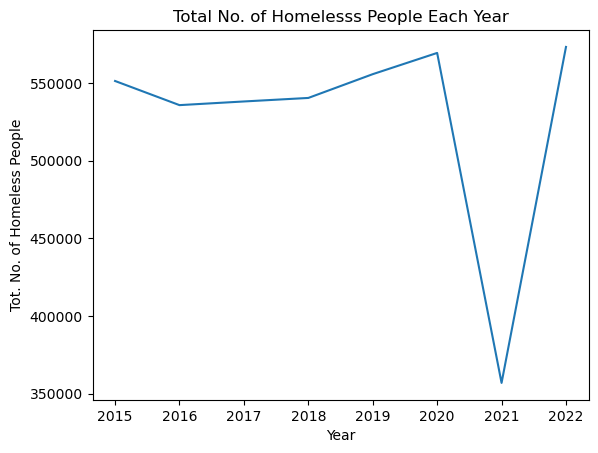

In [6]:
plt.plot(tot_homeless['Year'],tot_homeless['Overall Homeless'])
plt.xlabel('Year')
plt.ylabel('Tot. No. of Homeless People')
plt.title('Total No. of Homelesss People Each Year')
plt.show()

- This shows that count of homelessness has not really reduced over the years.
- There is a dip in count for 2021 due to data collection issues that the government faced post the pandemic. 

<b>Total No. of Homelesss People By Gender Each Year</b>

In [7]:
tot_homeless_gender = pd.pivot_table(df_all[['Overall Homeless - Female', 'Overall Homeless - Male',
       'Overall Homeless - Others','Year']], index='Year',values=['Overall Homeless - Female', 'Overall Homeless - Male',
       'Overall Homeless - Others'],aggfunc='sum').reset_index()

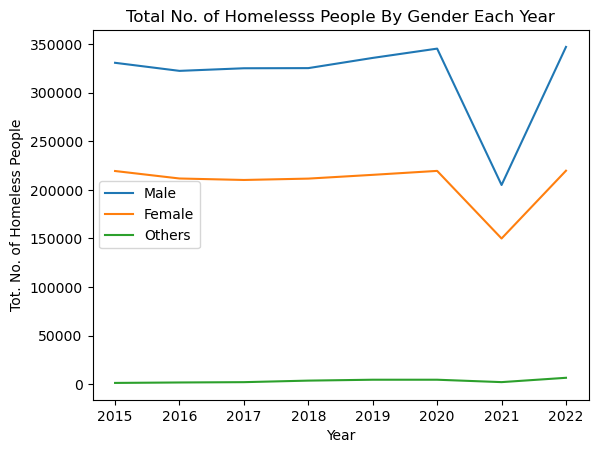

In [14]:
plt.plot(tot_homeless_gender['Year'],tot_homeless_gender['Overall Homeless - Male'],label='Male')
plt.plot(tot_homeless_gender['Year'],tot_homeless_gender['Overall Homeless - Female'],label='Female')
plt.plot(tot_homeless_gender['Year'],tot_homeless_gender['Overall Homeless - Others'],label='Others')

plt.xlabel('Year')
plt.ylabel('Tot. No. of Homeless People')
plt.title('Total No. of Homelesss People By Gender Each Year')
plt.legend()
plt.show()

- This plot shows us that there are more homeless males than females. 
- The homeless count for Others is very low compared to Gender = Male and Female  

<b>Total No. of Homelesss People By Age Each Year</b>

In [8]:
tot_homeless_age = pd.pivot_table(df_all[['Overall Homeless - Under 18', 'Overall Homeless - Over 18',
       'Year']], index='Year',values=['Overall Homeless - Under 18', 'Overall Homeless - Over 18'],aggfunc='sum').reset_index()

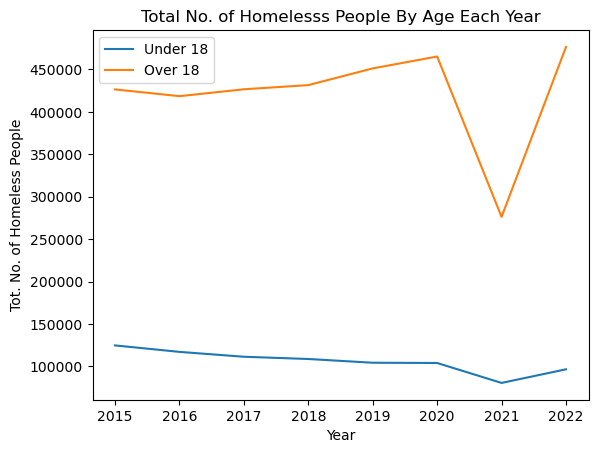

In [16]:
plt.plot(tot_homeless_age['Year'],tot_homeless_age['Overall Homeless - Under 18'],label='Under 18')
plt.plot(tot_homeless_age['Year'],tot_homeless_age['Overall Homeless - Over 18'],label='Over 18')

plt.xlabel('Year')
plt.ylabel('Tot. No. of Homeless People')
plt.title('Total No. of Homelesss People By Age Each Year')
plt.legend()
plt.show()

- There are more homeless adults than children (under 18(). 

<b>Total No. of Homeless People By Race Each Year</b>

In [9]:
race_cols = [i for i in df_all.columns if any(ele in i for ele in ['American','African','Black','White','Asian','Hawaiian','Multiple'])]
overall_race_cols = [i for i in race_cols if 'Overall Homeless -' in i]

tot_homeless_race = pd.pivot_table(df_all[overall_race_cols+['Year']], index='Year',values=overall_race_cols,aggfunc='sum').reset_index()

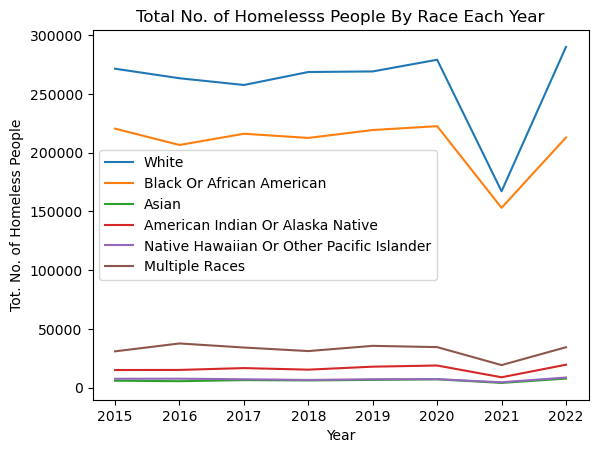

In [18]:
for i in overall_race_cols:
    plt.plot(tot_homeless_race['Year'],tot_homeless_race[i],label=i.replace('Overall Homeless - ',''))

plt.xlabel('Year')
plt.ylabel('Tot. No. of Homeless People')
plt.title('Total No. of Homelesss People By Race Each Year')
plt.legend()
plt.show()

- The White and Black populations are the groups that seem to be most affected by homelessness:
    - White people make up 76% of the total population thus showing higher homeless count. This indicates that we need to normalise the data. 
    - Upon investigating further, the reasons for high homeless count among Black populations are those that are fuelled by racism, such as unfair incarceration, drug addiction, etc.
- Before normalising: The count of homeless of other racial groups is considerably lower than that of the Black population, but is still quite high. 

<b>Normalising the data by dividing by the population of that race in the US for each year</b>

In [16]:
#Getting total population by race for each year data
tot_pop_race = pd.read_excel('US_Pop_Race-2000-2022.xlsx',sheet_name='Data')

#Preprocessing data
tot_pop_race = tot_pop_race.iloc[3:,1:].reset_index(drop=True)
tot_pop_race.iloc[0,0]='Year'
new_header = tot_pop_race.iloc[0]
tot_pop_race = tot_pop_race[1:]
tot_pop_race.columns = new_header

tot_pop_race.iloc[:,0] = tot_pop_race.iloc[:,0].astype(int)
tot_pop_race.iloc[:,1:] = tot_pop_race.iloc[:,1:].astype(float)

tot_pop_race = tot_pop_race[tot_pop_race['Year']>2014].reset_index(drop=True)
tot_pop_race.iloc[:,1:]=tot_pop_race.iloc[:,1:]*(10**6)
tot_pop_race.iloc[:,1:] = tot_pop_race.iloc[:,1:].astype(int)
tot_pop_race.rename(columns={'Two or more races':'Multiple Races'},inplace=True)
tot_pop_race

/var/folders/qq/z34t48_96z7154qj5hj_51fm0000gn/T/ipykernel_7366/3905972756.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tot_pop_race.iloc[:,0] = tot_pop_race.iloc[:,0].astype(int)
/var/folders/qq/z34t48_96z7154qj5hj_51fm0000gn/T/ipykernel_7366/3905972756.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tot_pop_race.iloc[:,1:] = tot_pop_race.iloc[:,1:].astype(float)
/var/folders/qq/z34t48_96z7154qj5hj_51fm0000gn/T/ipykernel_7366/3905972756.py:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to se

0  Year      White  Black or African American  \
0  2022  251600000                   45400000   
1  2021  251440000                   45100000   
2  2020  251640000                   44910000   
3  2019  250520000                   44080000   
4  2018  249960000                   43730000   
5  2017  249270000                   43370000   
6  2016  248410000                   42970000   
7  2015  247380000                   42530000   

0  American Indian and Alaska Native     Asian  \
0                            4380000  20950000   
1                            4330000  20470000   
2                            4330000  20230000   
3                            4190000  19500000   
4                            4150000  19130000   
5                            4099999  18760000   
6                            4050000  18280000   
7                            4000000  17750000   

0  Native Hawaiian and Other Pacific Islander  Multiple Races  
0                                      880000        10070000  
1                                      860000         9820000  
2                                      850000         9600000  
3                                      810000         9140000  
4                                      790000         8920000  
5                                      780000         8690000  
6                                      770000         8460000  
7                                      750000         8210000

In [46]:
#Merging with homeless count by race data and normalising
tot_homeless_race = pd.merge(tot_homeless_race, tot_pop_race, on='Year', how='left')

tot_homeless_race['Normalised Count - White'] = tot_homeless_race['Overall Homeless - White']/tot_homeless_race['White']
tot_homeless_race['Normalised Count - Black'] = tot_homeless_race['Overall Homeless - Black Or African American']/tot_homeless_race['Black or African American']
tot_homeless_race['Normalised Count - American Indian and Alaska Native'] = tot_homeless_race['Overall Homeless - American Indian Or Alaska Native']/tot_homeless_race['American Indian and Alaska Native']
tot_homeless_race['Normalised Count - Asian'] = tot_homeless_race['Overall Homeless - Asian']/tot_homeless_race['Asian']
tot_homeless_race['Normalised Count - Native Hawaiian and Other Pacific Islander'] = tot_homeless_race['Overall Homeless - Native Hawaiian Or Other Pacific Islander']/tot_homeless_race['Native Hawaiian and Other Pacific Islander']
tot_homeless_race['Normalised Count - Multiple Races'] = tot_homeless_race['Overall Homeless - Multiple Races']/tot_homeless_race['Multiple Races']

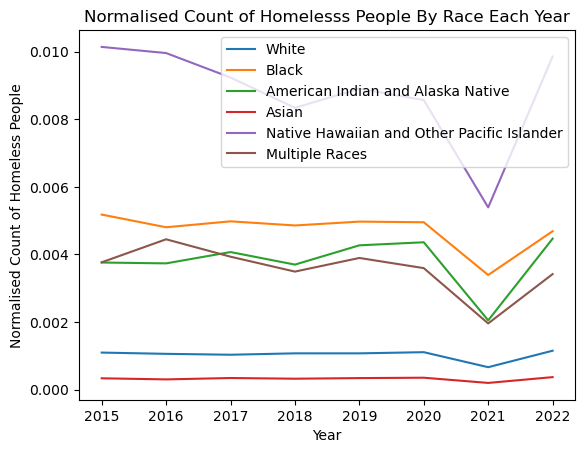

In [49]:
#Plotting normalised data
normalised_race_cols = [i for i in tot_homeless_race.columns if 'Normalised' in i]
for i in normalised_race_cols:
    plt.plot(tot_homeless_race['Year'],tot_homeless_race[i],label=i.replace('Normalised Count - ',''))

plt.xlabel('Year')
plt.ylabel('Normalised Count of Homeless People')
plt.title('Normalised Count of Homelesss People By Race Each Year')
plt.legend()
plt.show()

By looking at the plot of the <b>normalised data</b>, we now see that: <br>
- The most affected groups are actually Native Hawaiin and Other Pacific Islanders, Black, American Indian and Alaskan Native, and Multiple Races; with the highest being that of Native Hawaiin and Other Pacific Islanders.
- The homeless count for the White population is actually much lower in comparison. 
- This pattern persists across all years.
- This also indicates that other populations might need normalisation too, before numerical analysis. 

<b>Total No. of Homelesss People By Homelessness Type</b>

In [10]:
tot_homeless_type = pd.pivot_table(df_all[['Sheltered Total Homeless', 'Unsheltered Homeless',
       'Year']], index='Year',values=['Sheltered Total Homeless', 'Unsheltered Homeless'],aggfunc='sum').reset_index()

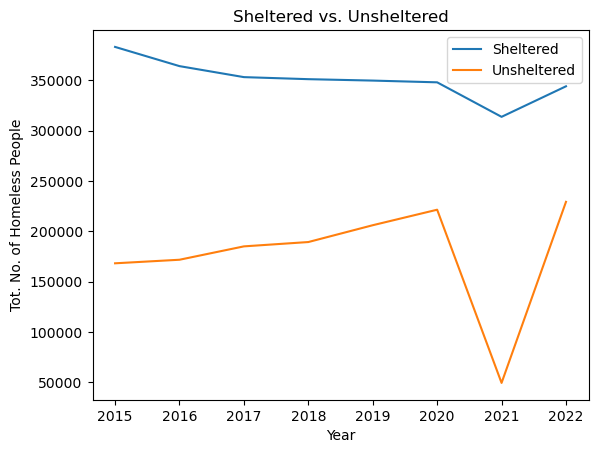

In [20]:
plt.plot(tot_homeless_type['Year'],tot_homeless_type['Sheltered Total Homeless'],label='Sheltered')
plt.plot(tot_homeless_type['Year'],tot_homeless_type['Unsheltered Homeless'],label='Unsheltered')

plt.xlabel('Year')
plt.ylabel('Tot. No. of Homeless People')
plt.title('Sheltered vs. Unsheltered')
plt.legend()
plt.show()

- No. of sheltered is decreasing while no. of unsheltered is increasing - this indicates that the homelessness issue is getting worse.

### Distribution of Data Across Years
#### Histogram

As mentioned above, the data needs to be normalised. Thus we perform log transformation to ensure normality and we use this log transformed data for our numerical analysis. 

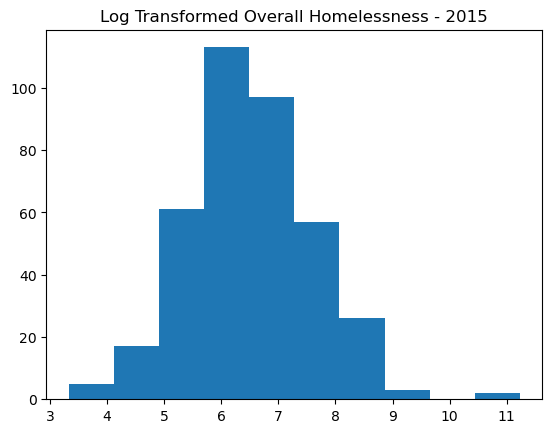

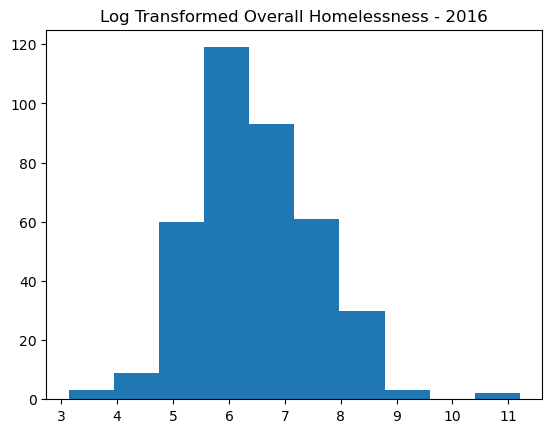

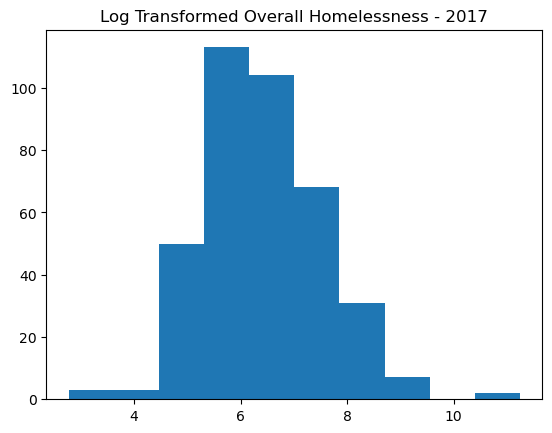

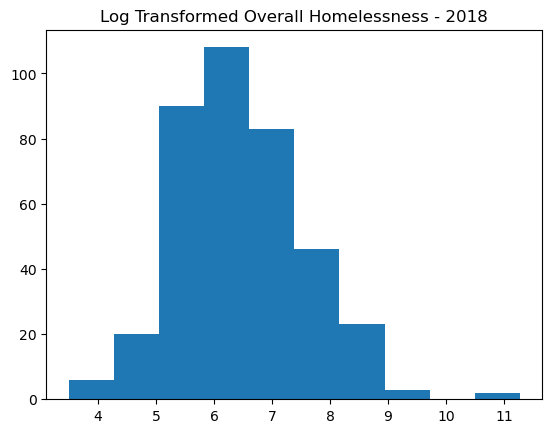

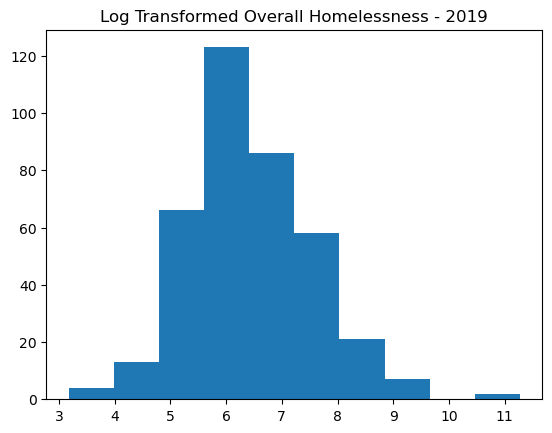

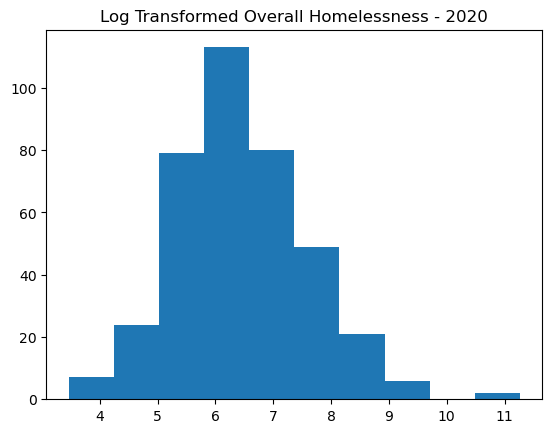

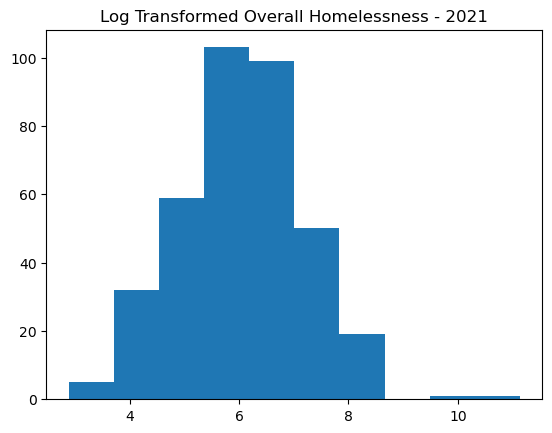

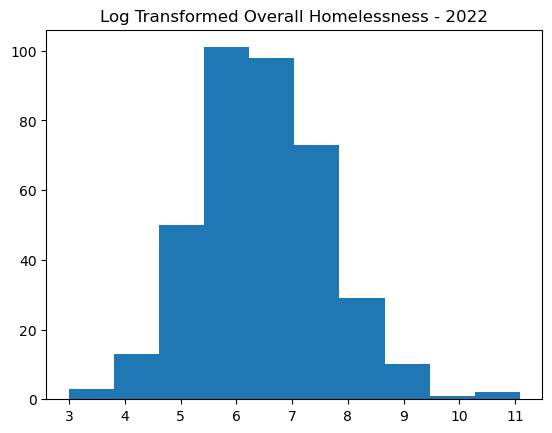

In [7]:
for i in range(2015,2023):
    temp = np.log(df_all.loc[df_all['Year']==i,'Overall Homeless'])
    plt.hist(temp)
    plt.title('Log Transformed Overall Homelessness - '+str(i))
    plt.show()

- As we can see above, applying log transformation has made the data normally distributed. 

#### Boxplot

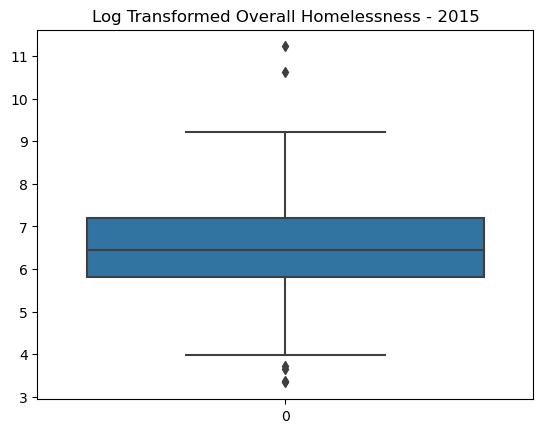

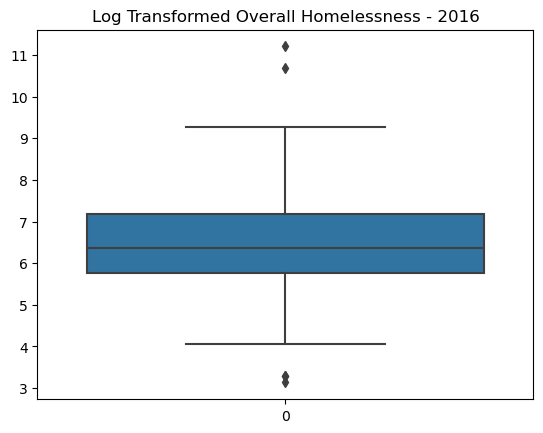

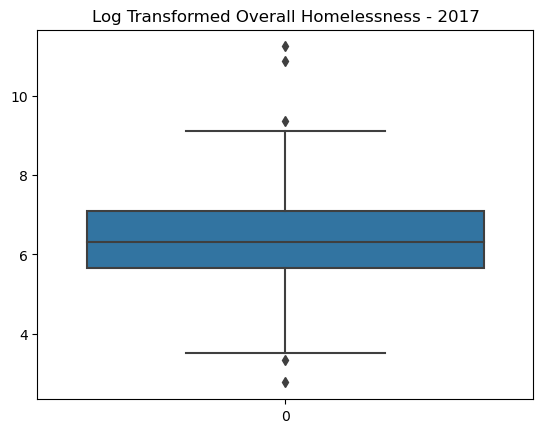

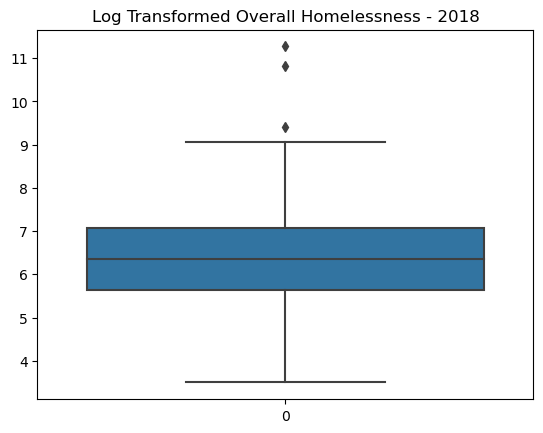

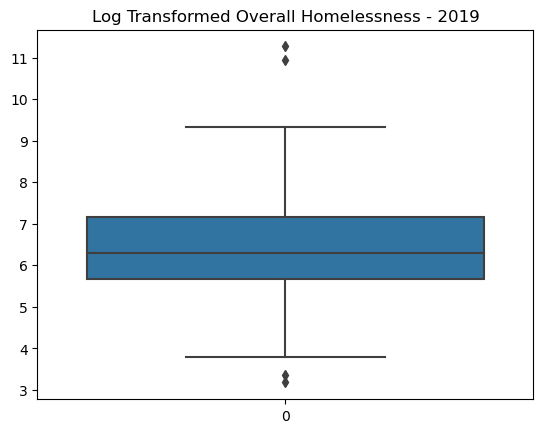

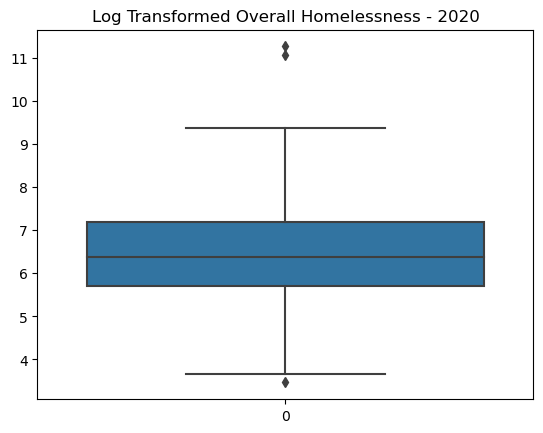

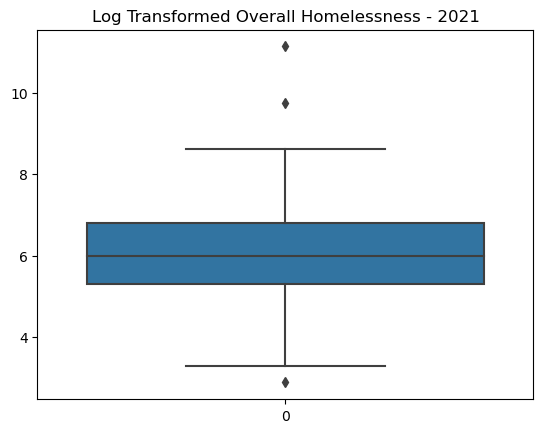

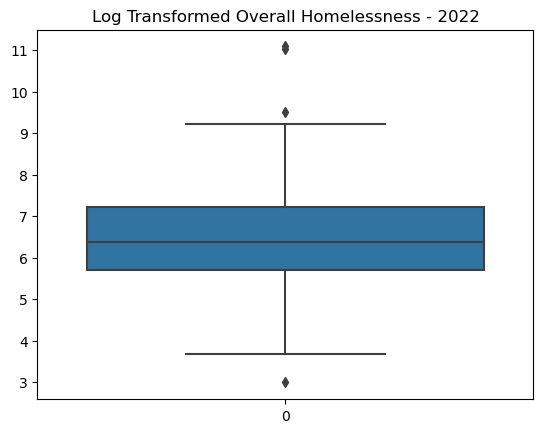

In [8]:
for i in range(2015,2023):
    temp = pd.Series(np.log(df_all.loc[df_all['Year']==i,'Overall Homeless'])).reset_index(drop=True)
    try:
        sns.boxplot(temp)
        plt.title('Log Transformed Overall Homelessness - '+str(i))
        plt.show()
    except KeyError:
        print(i)

- The boxplots show us that there aren't many outliers in the data across all years.  

#### Side by Side Boxplot

In [10]:
#Plotting function for side by side boxplot:
def cat_plots(target, df=df_all, cat_col='Year', limit_yax = False, l=20, b=10):
    plt.figure(figsize=(l, b))
    sns.boxplot(x = cat_col, y = target, data = df)
    plt.show()

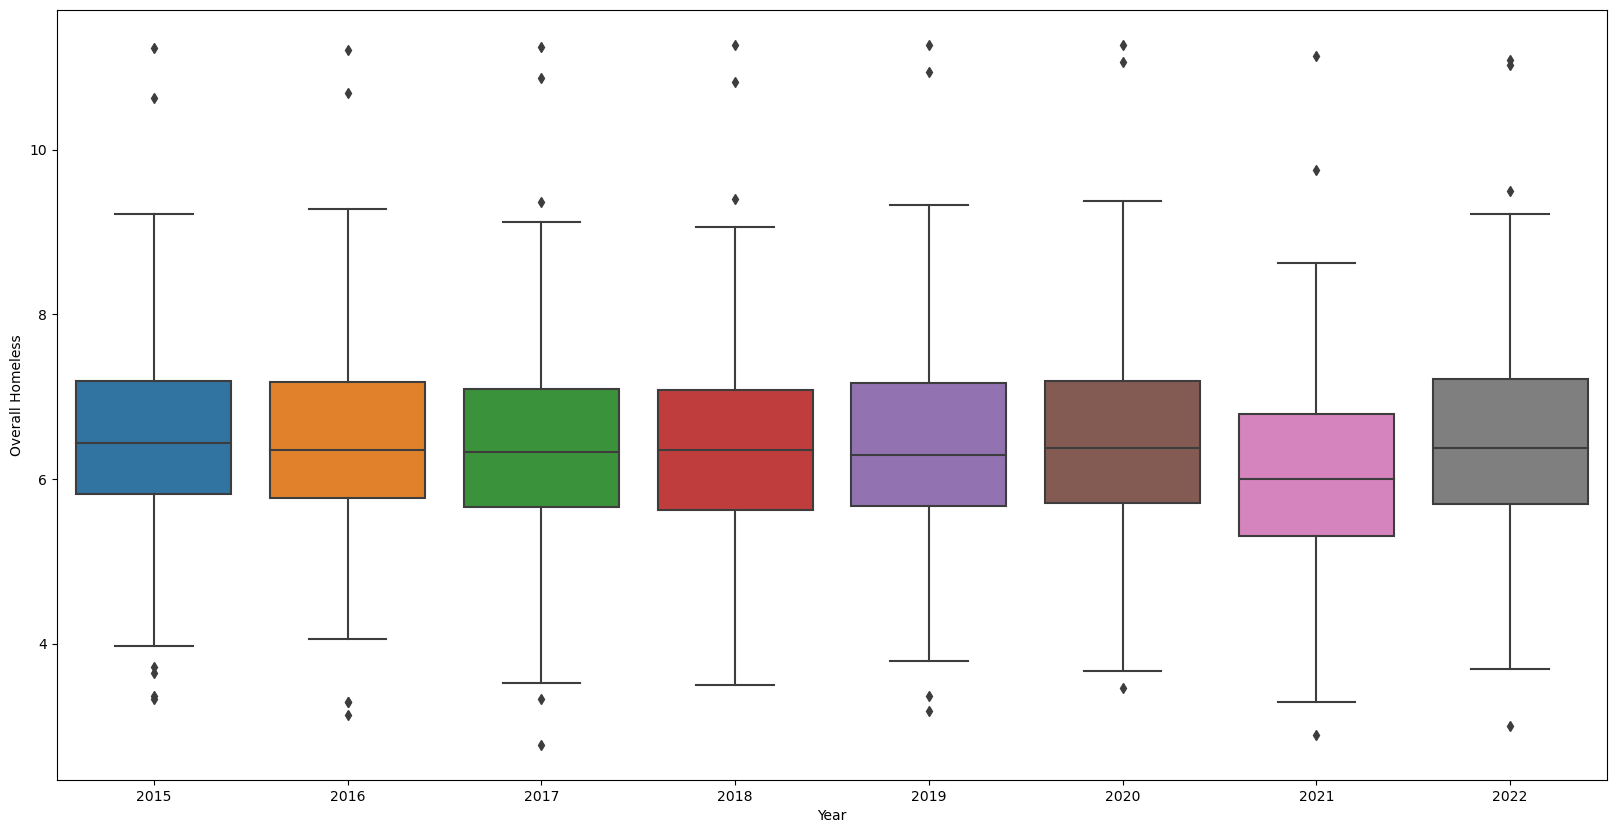

In [10]:
log_df = copy.deepcopy(df_all[['Overall Homeless','Year']])
log_df['Overall Homeless']=np.log(log_df['Overall Homeless'])
cat_plots(log_df['Overall Homeless'])

Homelessness has not improved much. Does this have anything to do with media depiction?

### Trends by State

In [11]:
df_state = pd.pivot_table(df_all, index=['State','Year'],values='Overall Homeless',aggfunc='sum').reset_index()
df_state

State  Year  Overall Homeless
0    Alabama  2015              3970
1    Alabama  2016              4111
2    Alabama  2017              3793
3    Alabama  2018              3434
4    Alabama  2019              3261
..       ...   ...               ...
394  Wyoming  2018               639
395  Wyoming  2019               548
396  Wyoming  2020               612
397  Wyoming  2021               405
398  Wyoming  2022               648

[399 rows x 3 columns]

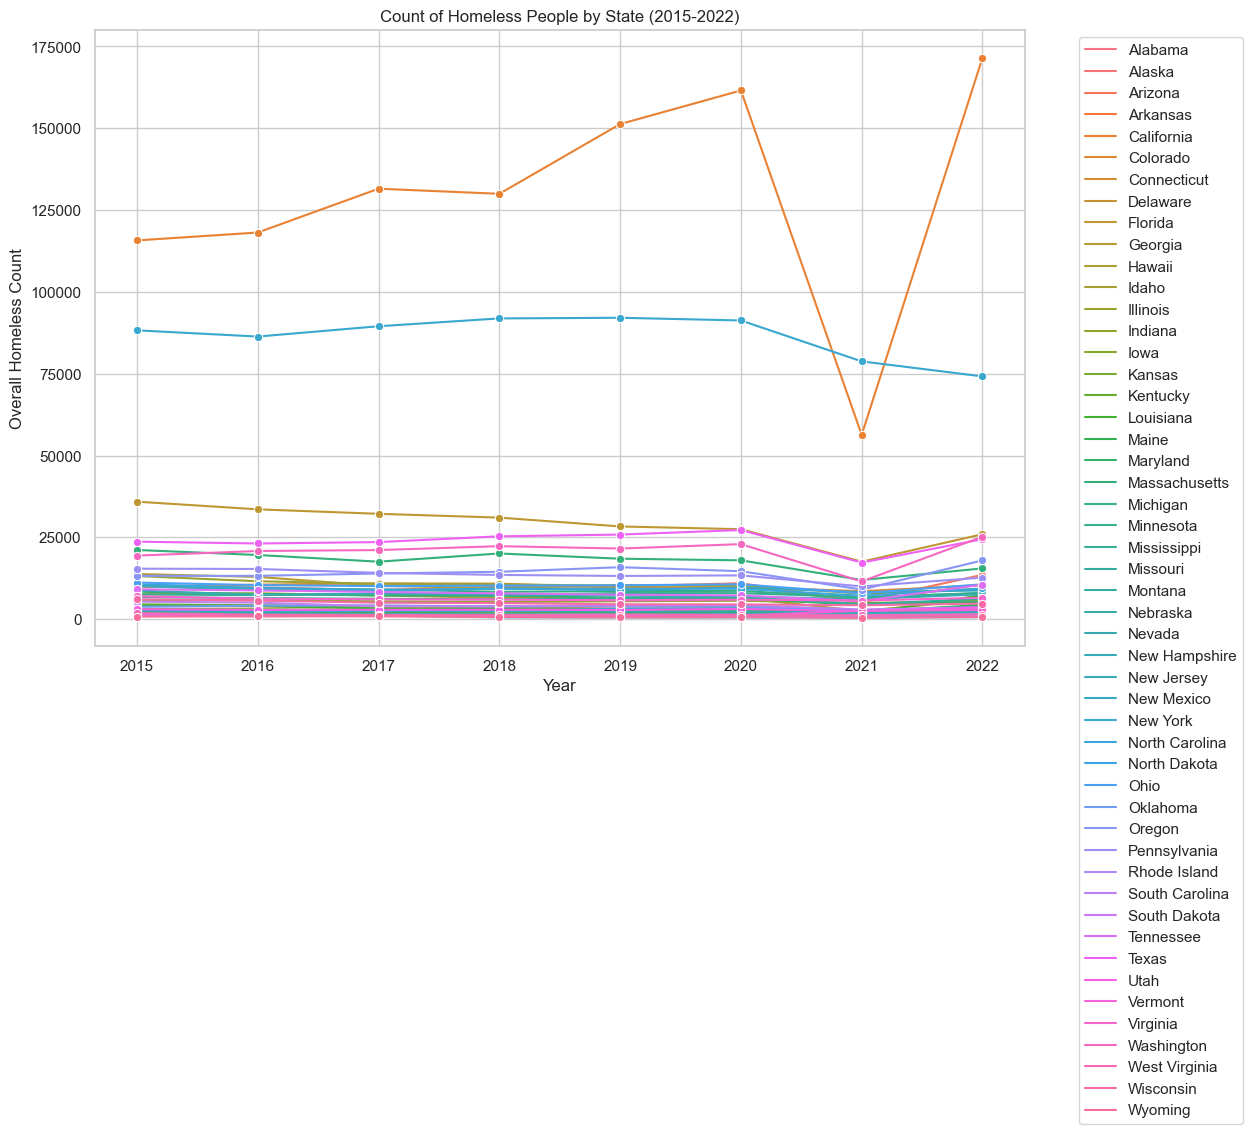

In [15]:
plt.figure(figsize=(12, 8))

sns.set(style="whitegrid")

sns.lineplot(data=df_state, x='Year', y='Overall Homeless', hue='State', marker='o')

plt.title('Count of Homeless People by State (2015-2022)')
plt.xlabel('Year')
plt.ylabel('Overall Homeless Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

- As seen from the plot above, the homeless counts of California and New York are consistently much worse than the rest of the states. 
- This could be due to issues like high cost of living, more violence, drug abuse, etc. in these states. 

### US Map - Count By State for 2022

In [14]:
import geopandas as gpd
import json 
from matplotlib.colors import LogNorm

In [13]:
df_state_22 = df_state[df_state['Year']==2022].reset_index(drop=True)

In [ ]:
us_states = gpd.read_file('us-states.geojson')  # Replace with the actual path to your GeoJSON file

In [24]:
df_state_22 = pd.merge(df_state_22, state_mapping, on='State', how='left')

/var/folders/qq/z34t48_96z7154qj5hj_51fm0000gn/T/ipykernel_6164/3905473516.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(merged_data.geometry.centroid.x, merged_data.geometry.centroid.y, merged_data['State_Abbr']):


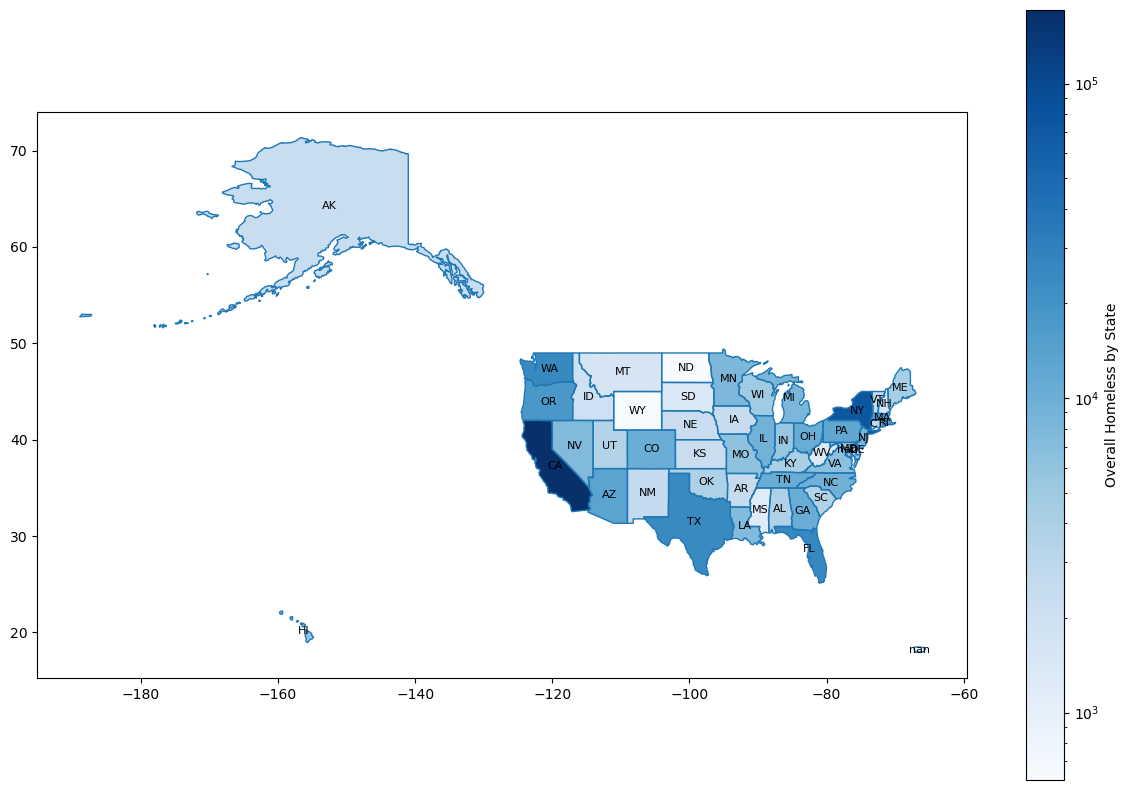

In [26]:
merged_data = us_states.merge(df_state_22, how='left', left_on='name', right_on='State')

# Plotting the map with a custom colormap
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_data.boundary.plot(ax=ax, linewidth=1)

# Use a custom colormap (Blues) and set LogNorm for better color representation with count data
cmap = plt.cm.Blues
norm = LogNorm(vmin=merged_data['Overall Homeless'].min(), vmax=merged_data['Overall Homeless'].max())

merged_data.plot(column='Overall Homeless', ax=ax, legend=True, legend_kwds={'label': "Overall Homeless by State"}, cmap=cmap, norm=norm)

# Annotate each state with its abbreviation
for x, y, label in zip(merged_data.geometry.centroid.x, merged_data.geometry.centroid.y, merged_data['State_Abbr']):
    ax.text(x, y, label, fontsize=8, ha='center', va='center')

# Display the plot
plt.show()

As we can see from the US map, the homelessness count for 2022 is worst for California and New York. 

## Numerical Analysis

##### Minor Preprocessing for better Numerical Analysis:

In [11]:
df_all.rename(columns={'Sheltered Total Homeless':'Overall Sheltered','Unsheltered Homeless':'Overall Unsheltered'},inplace=True)

In [12]:
#Keep only Overall columns as we are performing analysis only on this
df_all=df_all.drop([i for i in df_all.columns if ('Sheltered' in i) and ('Overall' not in i)],axis=1)
df_all=df_all.drop([i for i in df_all.columns if ('Unsheltered' in i) and ('Overall' not in i)],axis=1)

In [13]:
#Drop these as they are not required for analysis
df_all=df_all.drop(['CoC Number','State_Abbr'],axis=1)

df_all=df_all.drop([i for i in df_all.columns if 'Unaccompanied Youth' in i],axis=1)

df_all = df_all.drop([i for i in df_all.columns if 'Veterans' in i],axis=1)

df_all = df_all.drop(['Overall Homeless Family Households',
       'Overall Chronically Homeless'],axis=1)

In [14]:
#Apply log transformation to numerical columns to ensure normality
df_all.iloc[:,:-2] = df_all.iloc[:,:-2].apply(lambda x: np.log1p(x))

In [15]:
#Rename columns to easily categorise for analysis
overall = [i for i in df_all.columns if ('Overall' in i) and ('-' in i)]+['Overall Sheltered', 'Overall Unsheltered']
new_cols = {}
for i in overall:
    if any(re.findall(r'Black|Asian|American|White|Hawaiian|Multiple', i)):
        new_cols[i] = i.replace('Overall Homeless','Race')
    elif any(re.findall(r'Under 18|Over 18', i)):
        new_cols[i] = i.replace('Overall Homeless','Age')
    elif any(re.findall(r'Male|Female|Others', i)):
        new_cols[i] = i.replace('Overall Homeless','Gender')
    else:
        new_cols[i] = i.replace('Overall ','Type - ')

df_all.rename(columns=new_cols,inplace=True)

In [17]:
#Group columns by category for analysis
overall_age_cols = [i for i in df_all.columns if 'Age' in i]
overall_race_cols = [i for i in df_all.columns if 'Race' in i]
overall_gender_cols = [i for i in df_all.columns if 'Gender' in i]
overall_type_cols = [i for i in df_all.columns if 'Type' in i]

# Part 1
### Correlation

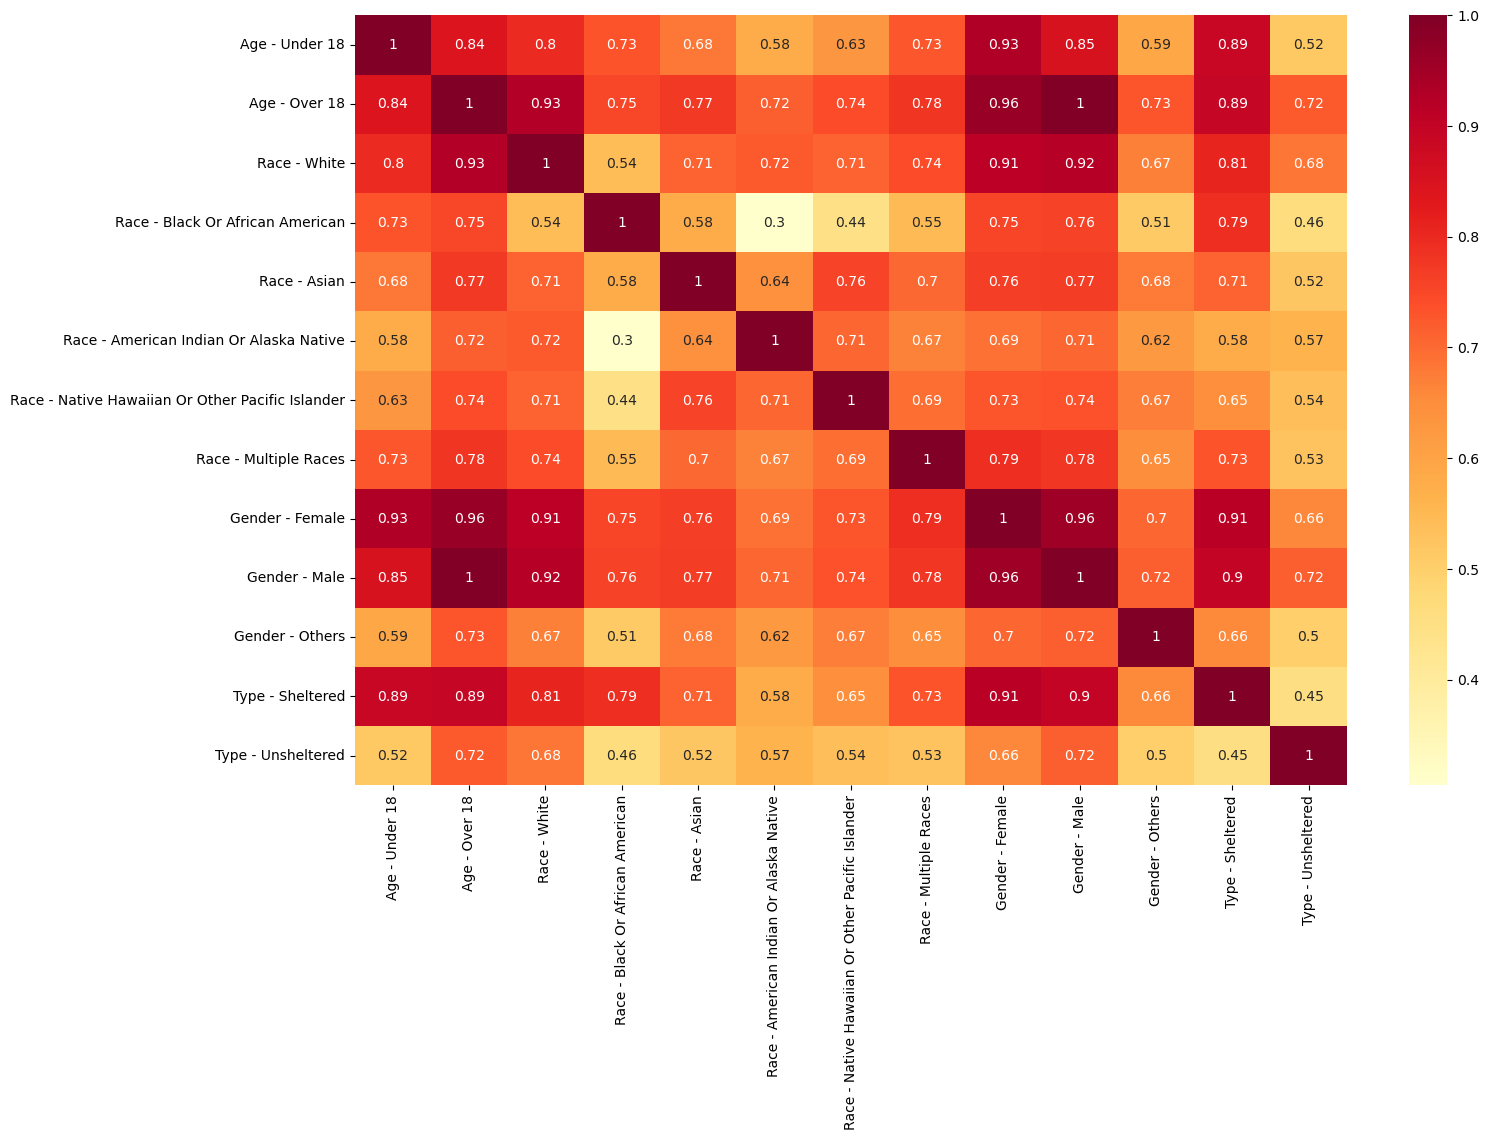

In [40]:
plt.figure(figsize = (16, 10))
sns.heatmap(df_all[overall_age_cols+overall_race_cols+overall_gender_cols+overall_type_cols].corr(), annot = True, cmap="YlOrRd")
plt.show()

<b>Conclusion</b>: <br>
- As we can see from the correlation matrix above, the following combinations have correlation coefficient >= 0.9, i.e., very strong positive relationship between the paired variables:
    1. Under 18 and African American 
    2. Under 18 and Female
    3. Over 18 and Female
    4. Over 18 and Male
    5. Female and Sheltered    
    6. Male and Sheltered 

- To further build upon these correlations to find more patterns in the data, we perform more numerical analysis such clustering and association pattern mining.

# Part 2
### Clustering

In [18]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.cluster.hierarchy import linkage, dendrogram

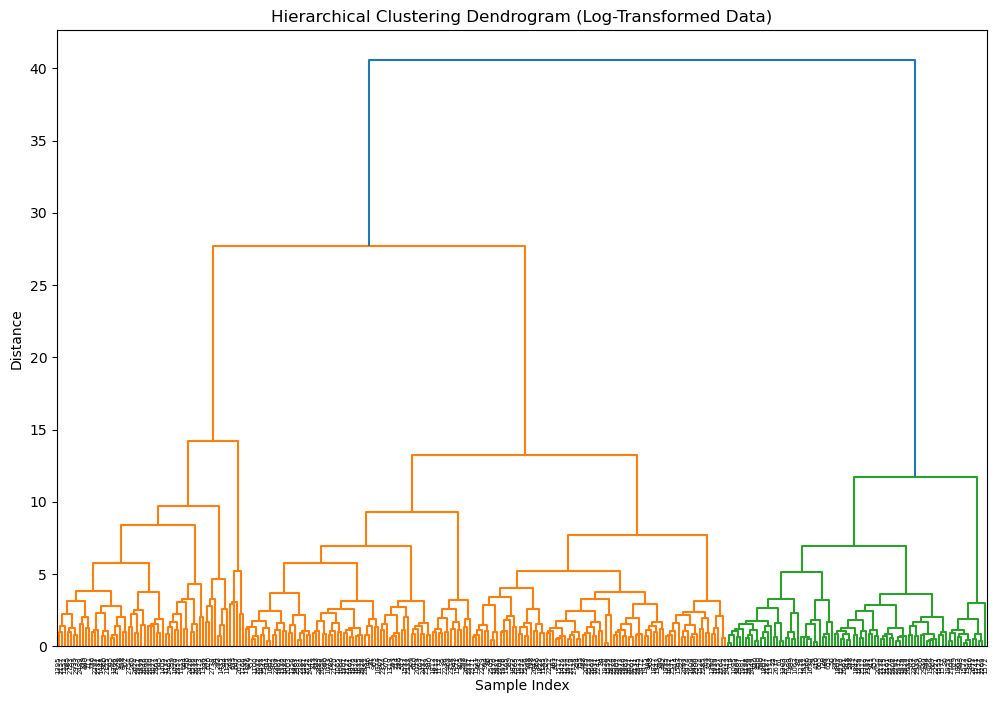

In [19]:
subset_size = int(len(df_all)/10)
subset_indices = np.random.choice(df_all.index, size=subset_size, replace=False)
subset_data = df_all.loc[subset_indices]
selected_columns = overall_age_cols + overall_gender_cols + overall_race_cols
cluster_data = subset_data[selected_columns]

#Log-transform the data so that it is normally distributed
cluster_data_log = cluster_data.apply(lambda x: np.log1p(x))

#Standardize the log-transformed data
#scaler = StandardScaler()
scaler = RobustScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data_log)

#Perform hierarchical clustering
linked = linkage(cluster_data_scaled, method='ward')

#Plot the dendrogram
plt.figure(figsize=(12, 8))
plt.xticks(rotation=90)
plt.xlim([-0.5, len(cluster_data) - 0.5])
dendrogram(linked, labels=cluster_data.index, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram (Log-Transformed Data)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

/Users/medhinisridharr/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/medhinisridharr/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/medhinisridharr/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/medhinisridharr/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The defa

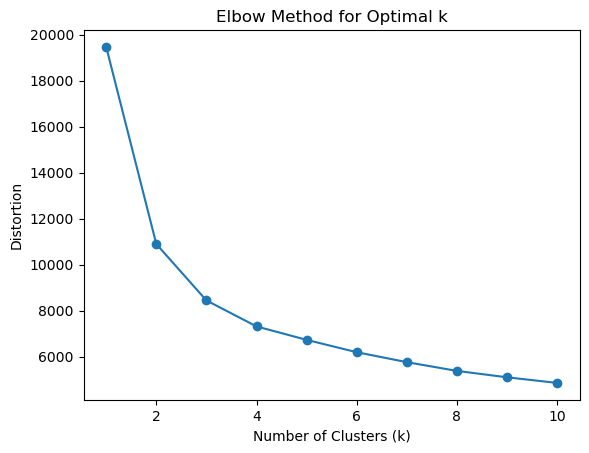

In [20]:
selected_columns = overall_age_cols + overall_gender_cols + overall_race_cols
cluster_data = df_all[selected_columns]

#Log-transform the data, adding a small constant to avoid log(0)
cluster_data_log = cluster_data.apply(lambda x: np.log1p(x))

#Standardize the log-transformed data using RobustScaler
scaler = RobustScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data_log)

#Apply the Elbow Method to determine the optimal number of clusters using KMeans
distortions = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(cluster_data_scaled)
    distortions.append(kmeans.inertia_)

#Plot the elbow curve
plt.plot(range(1, 11), distortions, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.show()

From the plot of elbow method, we see that: <br> <b>Optimal k = 4</b>

In [21]:
optimal_k = 4

#Perform hierarchical clustering with the chosen number of clusters
linked = linkage(cluster_data_scaled, method='ward')
cluster_labels = fcluster(linked, optimal_k, criterion='maxclust')

#Calculate Silhouette Score
silhouette_avg = silhouette_score(cluster_data_scaled, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.1821735069530643


In [22]:
cluster_data['Cluster_Labels'] = cluster_labels

#Group the data by cluster labels and calculate the mean for each demographic feature
cluster_means = cluster_data.groupby('Cluster_Labels').mean()

#Display the mean values for each cluster
print("Mean Values for Each Cluster:")
print(cluster_means)

Mean Values for Each Cluster:
                Age - Under 18  Age - Over 18  Gender - Female  Gender - Male  \
Cluster_Labels                                                                  
1                     6.037558       7.617587         6.865865       7.330479   
2                     3.329994       4.743982         4.140551       4.414100   
3                     4.305903       5.629528         4.995892       5.338020   
4                     4.869965       6.344702         5.638157       6.054075   

                Gender - Others  Race - White  \
Cluster_Labels                                  
1                      2.235421      7.182205   
2                      0.273555      4.491562   
3                      0.452414      5.164975   
4                      0.948914      5.972569   

                Race - Black Or African American  Race - Asian  \
Cluster_Labels                                                   
1                                       6.239368      3.

/var/folders/qq/z34t48_96z7154qj5hj_51fm0000gn/T/ipykernel_8695/3540372653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['Cluster_Labels'] = cluster_labels


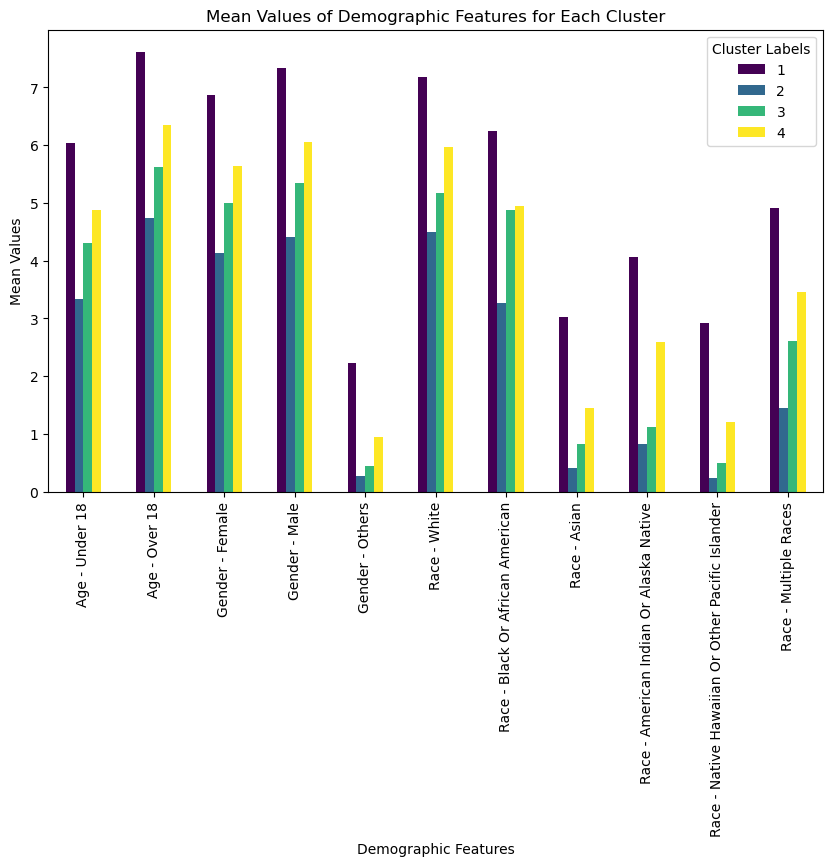

In [23]:
#Visualize the mean values using a bar plot
cluster_means.T.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Mean Values of Demographic Features for Each Cluster')
plt.xlabel('Demographic Features')
plt.ylabel('Mean Values')
plt.legend(title='Cluster Labels', loc='upper right')
plt.show()

<b>Conclusion</b>: <br>
- <b>Cluster 2</b>:
    - Highest mean values for 'Overall Homelessness Under 18’, ’Overall Homelessness, Male', 'Overall Homelessness, White', and 'Overall Homelessness, Black or African American' - implies it consists of young demographic with a significant presence of both White and Black or African American individuals.
    - Label: Under 18, White and African American
- <b>Cluster 1</b>:
    - Highest mean value for 'Overall Homelessness, Over 18' and 'Overall Homelessness, Female’, and noticeable mean value for 'Overall Homelessness, White' and 'Overall Homelessness, Black or African American' - implies it consists of adult women that are predominantly African American and White.
    - Label: Adult Females, Predominantly White and African American
- <b>Cluster 4</b>:
    - Does not have dominant high mean values. The distribution suggests a more mixed demographic without a strong skew towards any particular age, gender, or race.
    - Could be labeled as "Diverse Group”, reflecting no strong demographic dominance but a mix of various features.
- <b>Cluster 3</b>:
    - Shows negligible mean values across all demographic features, suggesting a very small or non-existent count in the dataset.
    - Label: Minimal or Non-Represented Demographics

# Part 3
### Association Pattern Mining

In [21]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

In [22]:
import warnings
warnings.filterwarnings("ignore")

In [23]:
df_assoc = copy.deepcopy(df_all)
df_assoc = pd.pivot_table(df_assoc,index=['Year','State'],values=[i for i in df_assoc.columns if 'Overall' in i],aggfunc='sum').reset_index()
df_assoc = df_assoc.drop(['Overall Homeless','Year'],axis=1)
df_assoc.iloc[:, 1:] = df_assoc.iloc[:, 1:].apply(lambda x: x > 0).astype(int)

df_mining = pd.concat([df_assoc.iloc[:, 1:], pd.get_dummies(df_assoc['State'])], axis=1)

In [24]:
assert len(df_mining.columns) == len(df_assoc.columns)-1 + 50

Get frequent itmsets of size 2,3,4,5: There are 5 categories: Age, Gender, Race, Type, State. We attempt to get itemsets of sizes 2-5 to try and capture all possible associations.

In [26]:
#Get frequent itmsets of size 2,3,4,5
frequent_itemsets_df = [pd.DataFrame() for i in range(2,6)]
rules_df = [pd.DataFrame() for i in range(2,6)]

for max_len_num in range(2,6):
    frequent_itemsets_df[max_len_num-2] = fpgrowth(df_mining, min_support=0.9, use_colnames=True, max_len=max_len_num)

    rules_df[max_len_num-2] = association_rules(frequent_itemsets_df[max_len_num-2], metric="confidence", min_threshold=0.9)

    rules_df[max_len_num-2]['antecedents'] = rules_df[max_len_num-2]['antecedents'].apply(lambda x:list(x)[0])
    rules_df[max_len_num-2]['consequents'] = rules_df[max_len_num-2]['consequents'].apply(lambda x:list(x)[0])

    rules_df[max_len_num-2] = rules_df[max_len_num-2].drop_duplicates(['antecedents','consequents'],keep='first').reset_index(drop=True)

    for categ in ['Age','Gender','Race','Type']:
        rules_df[max_len_num-2] = rules_df[max_len_num-2].drop(rules_df[max_len_num-2][(rules_df[max_len_num-2]['antecedents'].str.startswith(categ))&
                                (rules_df[max_len_num-2]['consequents'].str.startswith(categ))].index,axis=0).reset_index(drop=True)
    
    if max_len_num==2:
        rules_df[max_len_num-2].to_csv('rules_df_'+str(max_len_num)+'.csv',index=False)
    else:
        if (all(rules_df[0].iloc[:,0]==rules_df[max_len_num-2].iloc[:,0]))&(all(rules_df[0].iloc[:,1]==rules_df[max_len_num-2].iloc[:,1])):
            pass
        else:
            print(str(max_len_num-2)+' is different - ')
            rules_df[max_len_num-2].to_csv('rules_df_'+str(max_len_num)+'.csv',index=False)

In [27]:
rules = copy.deepcopy(rules_df[0][['antecedents','consequents','support','confidence']])
rules = rules.loc[(rules['support']==1)&(rules['confidence']==1),['antecedents','consequents']].reset_index(drop=True)
rules

antecedents  \
0                          Type - Sheltered   
1                              Race - White   
2                            Age - Under 18   
3                              Race - White   
4                            Age - Under 18   
5                          Type - Sheltered   
6                             Age - Over 18   
7                              Race - White   
8                             Age - Over 18   
9                          Type - Sheltered   
10                            Age - Over 18   
11                    Race - Multiple Races   
12                           Age - Under 18   
13                    Race - Multiple Races   
14                    Race - Multiple Races   
15                         Type - Sheltered   
16                    Race - Multiple Races   
17                            Gender - Male   
18                            Age - Over 18   
19                            Gender - Male   
20                           Age - Under 18   
21                            Gender - Male   
22                            Gender - Male   
23                             Race - White   
24                         Type - Sheltered   
25                            Gender - Male   
26                    Race - Multiple Races   
27                          Gender - Female   
28                            Age - Over 18   
29                          Gender - Female   
30                           Age - Under 18   
31                          Gender - Female   
32                          Gender - Female   
33                             Race - White   
34                         Type - Sheltered   
35                          Gender - Female   
36                          Gender - Female   
37         Race - Black Or African American   
38                            Gender - Male   
39         Race - Black Or African American   
40                            Age - Over 18   
41         Race - Black Or African American   
42                           Age - Under 18   
43         Race - Black Or African American   
44                         Type - Sheltered   
45         Race - Black Or African American   
46  Race - American Indian Or Alaska Native   
47                          Gender - Female   
48  Race - American Indian Or Alaska Native   
49                            Gender - Male   
50                            Age - Over 18   
51  Race - American Indian Or Alaska Native   
52                           Age - Under 18   
53  Race - American Indian Or Alaska Native   
54  Race - American Indian Or Alaska Native   
55                         Type - Sheltered   

                                consequents  
0                              Race - White  
1                          Type - Sheltered  
2                              Race - White  
3                            Age - Under 18  
4                          Type - Sheltered  
5                            Age - Under 18  
6                              Race - White  
7                             Age - Over 18  
8                          Type - Sheltered  
9                             Age - Over 18  
10                    Race - Multiple Races  
11                            Age - Over 18  
12                    Race - Multiple Races  
13                           Age - Under 18  
14                         Type - Sheltered  
15                    Race - Multiple Races  
16                            Gender - Male  
17                    Race - Multiple Races  
18                            Gender - Male  
19                            Age - Over 18  
20                            Gender - Male  
21                           Age - Under 18  
22                             Race - White  
23                            Gender - Male  
24                            Gender - Male  
25                         Type - Sheltered  
26                          Gender - Female  
27                    Race - Multiple Races  
28                

In [28]:
associations = rules['antecedents']+' -> '+rules['consequents']
associations

0                      Type - Sheltered -> Race - White
1                      Race - White -> Type - Sheltered
2                        Age - Under 18 -> Race - White
3                        Race - White -> Age - Under 18
4                    Age - Under 18 -> Type - Sheltered
5                    Type - Sheltered -> Age - Under 18
6                         Age - Over 18 -> Race - White
7                         Race - White -> Age - Over 18
8                     Age - Over 18 -> Type - Sheltered
9                     Type - Sheltered -> Age - Over 18
10               Age - Over 18 -> Race - Multiple Races
11               Race - Multiple Races -> Age - Over 18
12              Age - Under 18 -> Race - Multiple Races
13              Race - Multiple Races -> Age - Under 18
14            Race - Multiple Races -> Type - Sheltered
15            Type - Sheltered -> Race - Multiple Races
16               Race - Multiple Races -> Gender - Male
17               Gender - Male -> Race - Multipl

<b>Conclusion</b>: <br>
Thus, the associations shown above indicate the patterns in homeless, i.e., different categories that are associated with one another. 

# Part 4
### Classification Models:

- We employ classification models, specifically Random Forest and Gradient Boosting Classifier to identify which factors influence High levels of homelessness. 
- For this purpose, we create a target variable, Homelessness, which is categorical in nature and has classes 1 and 0.
    - This variable is created by classifying points that have Overall Homeless Count > Median value as Class = 1 and remaining as 0. 
    - Class = 1 indicates High level of homelessness and Class = 0 indicates Low level of homelessness.  

#### Random Forest and Gradient Boosting

In [24]:
# Assuming df_all is your original DataFrame
classif_data = copy.deepcopy(df_all)

# Drop 'Year' column
classif_data = classif_data.drop('Year', axis=1)

In [25]:
# One-hot encode 'State' column
classif_data = pd.concat([classif_data.iloc[:, :-1], pd.get_dummies(classif_data['State'])], axis=1)

# Create binary target variable 'Homelessness'
overall_homel_median = classif_data['Overall Homeless'].median()
classif_data['Homelessness'] = np.where(classif_data['Overall Homeless'] > overall_homel_median, 1, 0)

# Features and target variable
X = classif_data.drop(['Overall Homeless', 'Homelessness'], axis=1)
y = classif_data['Homelessness']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

In [27]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Initialize Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [28]:
# Random Forest Model
rf_y_pred = rf_model.predict(X_test)

# Evaluate Random Forest model
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print("Random Forest Model:")
print(f"Accuracy: {rf_accuracy:.2f}")
print(classification_report(y_test, rf_y_pred))

Random Forest Model:
Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       314
           1       0.98      0.99      0.99       293

    accuracy                           0.99       607
   macro avg       0.99      0.99      0.99       607
weighted avg       0.99      0.99      0.99       607



In [29]:
# Feature importances for Random Forest
rf_importances = rf_model.feature_importances_
rf_feature_importance_dict = dict(zip(X.columns, rf_importances))
rf_sorted_feature_importance = sorted(rf_feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Display feature importance for Random Forest
print("\nRandom Forest Feature Importance:")
for feature, importance in rf_sorted_feature_importance:
    print(f"{feature}: {importance:.4f}")


Random Forest Feature Importance:
Gender - Male: 0.2184
Age - Over 18: 0.2117
Gender - Female: 0.1344
Race - White: 0.0852
Type - Sheltered: 0.0819
Age - Under 18: 0.0719
Type - Unsheltered: 0.0423
Race - Black Or African American: 0.0324
Race - Multiple Races: 0.0307
Race - American Indian Or Alaska Native: 0.0278
Race - Asian: 0.0207
Race - Native Hawaiian Or Other Pacific Islander: 0.0190
Gender - Others: 0.0093
Illinois: 0.0018
California: 0.0014
Florida: 0.0009
Michigan: 0.0008
Virginia: 0.0007
North Carolina: 0.0007
Pennsylvania: 0.0006
Massachusetts: 0.0006
Minnesota: 0.0006
New Jersey: 0.0005
Missouri: 0.0004
Nebraska: 0.0004
New York: 0.0004
Oregon: 0.0004
South Carolina: 0.0004
Oklahoma: 0.0003
Ohio: 0.0003
Alabama: 0.0003
Idaho: 0.0003
Maryland: 0.0003
Kansas: 0.0002
Kentucky: 0.0002
Alaska: 0.0002
North Dakota: 0.0002
Washington: 0.0002
Tennessee: 0.0001
Georgia: 0.0001
Texas: 0.0001
New Hampshire: 0.0001
Arkansas: 0.0001
Mississippi: 0.0001
Colorado: 0.0001
Hawaii: 0.0001

In [30]:
# Gradient Boosting Model
gb_y_pred = gb_model.predict(X_test)

# Evaluate Gradient Boosting model
gb_accuracy = accuracy_score(y_test, gb_y_pred)
print("\nGradient Boosting Model:")
print(f"Accuracy: {gb_accuracy:.2f}")
print(classification_report(y_test, gb_y_pred))


Gradient Boosting Model:
Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       314
           1       0.99      0.99      0.99       293

    accuracy                           0.99       607
   macro avg       0.99      0.99      0.99       607
weighted avg       0.99      0.99      0.99       607



In [31]:
# Feature importances for Gradient Boosting
gb_importances = gb_model.feature_importances_
gb_feature_importance_dict = dict(zip(X.columns, gb_importances))
gb_sorted_feature_importance = sorted(gb_feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Display feature importance for Gradient Boosting
print("\nGradient Boosting Feature Importance:")
for feature, importance in gb_sorted_feature_importance:
    print(f"{feature}: {importance:.4f}")


Gradient Boosting Feature Importance:
Age - Over 18: 0.8354
Gender - Male: 0.1059
Gender - Female: 0.0393
Type - Sheltered: 0.0119
Age - Under 18: 0.0068
Race - White: 0.0002
Race - Black Or African American: 0.0001
Race - American Indian Or Alaska Native: 0.0001
Race - Asian: 0.0001
North Dakota: 0.0001
Kansas: 0.0001
Gender - Others: 0.0001
Race - Multiple Races: 0.0000
Ohio: 0.0000
Connecticut: 0.0000
Type - Unsheltered: 0.0000
Nebraska: 0.0000
Colorado: 0.0000
Race - Native Hawaiian Or Other Pacific Islander: 0.0000
Alabama: 0.0000
Florida: 0.0000
Oregon: 0.0000
Louisiana: 0.0000
Mississippi: 0.0000
Alaska: 0.0000
Arizona: 0.0000
Arkansas: 0.0000
California: 0.0000
Delaware: 0.0000
Georgia: 0.0000
Hawaii: 0.0000
Idaho: 0.0000
Illinois: 0.0000
Indiana: 0.0000
Iowa: 0.0000
Kentucky: 0.0000
Maine: 0.0000
Maryland: 0.0000
Massachusetts: 0.0000
Michigan: 0.0000
Minnesota: 0.0000
Missouri: 0.0000
Montana: 0.0000
Nevada: 0.0000
New Hampshire: 0.0000
New Jersey: 0.0000
New Mexico: 0.0000


#### Random Forest and Gradient Boosting Classifiers with Cross Validation

We are using cross-validation to assess the model's performance robustly by repeatedly splitting the dataset into training and testing subsets. 

In [38]:
# Cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print(f"Random Forest Cross-Validation Accuracy: {np.mean(rf_cv_scores):.2f}")

# Cross-validation for Gradient Boosting
gb_cv_scores = cross_val_score(gb_model, X, y, cv=5, scoring='accuracy')
print(f"Gradient Boosting Cross-Validation Accuracy: {np.mean(gb_cv_scores):.2f}")

Random Forest Cross-Validation Accuracy: 0.99
Gradient Boosting Cross-Validation Accuracy: 0.99


In [39]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

# Cross-validation predictions for Random Forest
rf_cv_predictions = cross_val_predict(rf_model, X, y, cv=5)

# Classification report for Random Forest
rf_classification_report = classification_report(y, rf_cv_predictions)
print("Random Forest Cross-Validation Classification Report:")
print(rf_classification_report)

# Cross-validation predictions for Gradient Boosting
gb_cv_predictions = cross_val_predict(gb_model, X, y, cv=5)

# Classification report for Gradient Boosting
gb_classification_report = classification_report(y, gb_cv_predictions)
print("\nGradient Boosting Cross-Validation Classification Report:")
print(gb_classification_report)

Random Forest Cross-Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1520
           1       0.99      0.99      0.99      1513

    accuracy                           0.99      3033
   macro avg       0.99      0.99      0.99      3033
weighted avg       0.99      0.99      0.99      3033


Gradient Boosting Cross-Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1520
           1       0.99      0.99      0.99      1513

    accuracy                           0.99      3033
   macro avg       0.99      0.99      0.99      3033
weighted avg       0.99      0.99      0.99      3033



The high accuracy, F1 score, precision and recall values after cross-validation helps ensure that the reported high accuracy, precision, recall, and F1 scores are not due to random chance or overfitting to a specific subset of the data.

<b>Conclusion</b>: <br>
Thus, we can now conclude by looking at the important features from both, RandomForest and Gradient Boosting classifiers, that factors affecting High level of homelessness are:
1. Gender - Male: 0.2184
2. Age - Over 18: 0.2117

-------

# Section 2. Media Analysis

# Part 1

1. Web Scraping for News Headlines (2016-2022):
    * Scrape 100+ news article headlines for each year (2016-2022) using the keyword 'homeless'.
    * Target three media outlets with distinct political leanings: The New York Times (left), The Wall Street Journal (center), and The Washington Examiner (right).
    * Save the scraped headlines in separate files for each media outlet and year
    * e.g. 'WSJ_headlines_2017.txt'.

**The New York Times (Left)**

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.edge.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.edge.options import Options
from selenium.common.exceptions import TimeoutException, NoSuchElementException
import os
import time


# Set up Edge options
edge_options = Options()
edge_options.use_chromium = True
edge_options.add_argument("--headless")

# Specify the path to Edge WebDriver executable
edge_driver_path = '/Users/yein_brynn/Downloads/msedgedriver'

# Initialize the Edge driver
service = Service(edge_driver_path)
driver = webdriver.Edge(service=service, options=edge_options)

# Function to convert date format
def format_date(date_str):
    return f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}"

# Function to fetch headlines and write to a file
def fetch_headlines_and_write_to_file(start_date, end_date, year):
    formatted_start_date = format_date(start_date)
    formatted_end_date = format_date(end_date)

    print(f"\nCompiling headlines from {formatted_start_date} to {formatted_end_date}...\n")

    url = f"https://www.nytimes.com/search?dropmab=false&endDate={formatted_end_date}&query={params['q']}&sort=best&startDate={formatted_start_date}"
    driver.get(url)

    headline_count = 0
    headlines = []

    while headline_count < 200:
        try:
            load_more_button_xpath = "//button[@data-testid='search-show-more-button']"
            load_more_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, load_more_button_xpath))
            )
            load_more_button.click()
            WebDriverWait(driver, 5).until(
                EC.presence_of_element_located((By.XPATH, load_more_button_xpath))
            )
            new_headlines = driver.find_elements(By.CSS_SELECTOR, 'h4.css-2fgx4k')
            headlines.extend(new_headlines)
            headline_count = len(headlines)
        except (TimeoutException, NoSuchElementException):
            print("No more 'Load More' button to click or timed out waiting.")
            break

    with open(f'L1_NYT_headlines_{year}.txt', 'w') as file:
        for headline in headlines[:200]:
            file.write(headline.text + '\n')

    print(f"Successfully saved to L1_NYT_headlines_{year}.txt (total {min(headline_count, 200)})")


########### Parameters ###########
for year in range(2016, 2023):
    params = {
        'q': 'homeless', # keyword varations
        'start_date': f"{year}0101",
        'end_date': f"{year}1231",
    }
    fetch_headlines_and_write_to_file(params['start_date'], params['end_date'], year)


    
# Close the browser
driver.quit()

print("/n/nCompleted! 🍰")


Compiling headlines from 2016-01-01 to 2016-12-31...

Successfully saved to L1_NYT_headlines_2016.txt (total 200)

Compiling headlines from 2017-01-01 to 2017-12-31...

Successfully saved to L1_NYT_headlines_2017.txt (total 200)

Compiling headlines from 2018-01-01 to 2018-12-31...

Successfully saved to L1_NYT_headlines_2018.txt (total 200)

Compiling headlines from 2019-01-01 to 2019-12-31...

Successfully saved to L1_NYT_headlines_2019.txt (total 200)

Compiling headlines from 2020-01-01 to 2020-12-31...

Successfully saved to L1_NYT_headlines_2020.txt (total 200)

Compiling headlines from 2021-01-01 to 2021-12-31...

Successfully saved to L1_NYT_headlines_2021.txt (total 200)

Compiling headlines from 2022-01-01 to 2022-12-31...

Successfully saved to L1_NYT_headlines_2022.txt (total 200)
/n/nCompleted! 🍰


**The Wall Street Journal (Center)**

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.edge.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.edge.options import Options
from selenium.common.exceptions import TimeoutException, NoSuchElementException
import os
import time


# Set up Edge options
edge_options = Options()
edge_options.use_chromium = True
edge_options.add_argument("--headless")

# Specify the path to Edge WebDriver executable
edge_driver_path = '/Users/yein_brynn/Downloads/msedgedriver'

# Initialize the Edge driver
service = Service(edge_driver_path)
driver = webdriver.Edge(service=service, options=edge_options)


# Function to format the date as YYYY/MM/DD
def format_date(date_str):
    return f"{date_str[:4]}/{date_str[4:6]}/{date_str[6:]}"

# Function to fetch headlines and write to a file
def fetch_headlines_and_write_to_file(start_date, end_date, year):
    formatted_start_date = format_date(start_date)
    formatted_end_date = format_date(end_date)

    print(f"\nCompiling headlines from {formatted_start_date} to {formatted_end_date}...\n")

    headlines = []
    page_number = 1

    while page_number <= 10:
        # Adjusted URL format with encoded slashes for date
        url = f"https://www.wsj.com/search?query=homelessness&isToggleOn=true&operator=OR&sort=relevance&startDate={formatted_start_date}&endDate={formatted_end_date}&source=wsjie%2Cblog%2Cwsjvideo%2Cinteractivemedia%2Cwsjsitesrch%2Cwsjpro%2Cwsjaudio%2Clivecoverage&page={page_number}"
        driver.get(url)

        # Allow some time for the page to load
        time.sleep(5)

        # Fetch the headlines using the correct CSS Selector for WSJ
        try:
            new_headlines = WebDriverWait(driver, 10).until(
                EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'h3.WSJTheme--headline--unZqjb45'))
            )
            headlines.extend([headline.text for headline in new_headlines])
        except TimeoutException:
            print(f"Timed out waiting for headlines to load on page {page_number}.")
            break

        print(f"page {page_number}: {len(new_headlines)} headlines extracted")
        page_number += 1
        time.sleep(2)  # Sleep briefly to simulate human browsing

    # Write the headlines to a file
    with open(f'WSJ_headlines_{year}.txt', 'w') as file:
        for headline in headlines:
            file.write(headline + '\n')

    print(f"Successfully saved to WSJ_headlines_{year}.txt!")

# Main loop to fetch headlines for each year
for year in range(2016, 2023):
    params = {
        'q': 'homeless', # keyword variations
        'start_date': f"{year}0101",
        'end_date': f"{year}1231",
    }
    fetch_headlines_and_write_to_file(params['start_date'], params['end_date'], year)

# Close the browser
driver.quit()

print("\n\nCompleted! 🍰")



Compiling headlines from 2016/01/01 to 2016/12/31...

page 1: 20 headlines extracted
page 2: 20 headlines extracted
page 3: 20 headlines extracted
page 4: 20 headlines extracted
page 5: 20 headlines extracted
page 6: 20 headlines extracted
page 7: 20 headlines extracted
page 8: 20 headlines extracted
page 9: 20 headlines extracted
page 10: 20 headlines extracted
Successfully saved to WSJ_headlines_2016.txt!

Compiling headlines from 2017/01/01 to 2017/12/31...

page 1: 20 headlines extracted
page 2: 20 headlines extracted
page 3: 20 headlines extracted
page 4: 20 headlines extracted
page 5: 20 headlines extracted
page 6: 20 headlines extracted
page 7: 20 headlines extracted
page 8: 20 headlines extracted
page 9: 20 headlines extracted
page 10: 20 headlines extracted
Successfully saved to WSJ_headlines_2017.txt!

Compiling headlines from 2018/01/01 to 2018/12/31...

page 1: 20 headlines extracted
page 2: 20 headlines extracted
page 3: 20 headlines extracted
page 4: 20 headlines extract

**Washington Examiner (Right)**

Step 1. Extracting titles from the search pages which contains 2016-2022 articles.

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.edge.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.edge.options import Options
from selenium.common.exceptions import TimeoutException, NoSuchElementException
import os
import time

# Set up Edge options
edge_options = Options()
edge_options.use_chromium = True
edge_options.add_argument("headless")
edge_options.add_argument("disable-gpu")

# Specify the path to Edge WebDriver executable
edge_driver_path = '/Users/yein_brynn/Downloads/msedgedriver'

# Initialize the Edge driver
service = Service(edge_driver_path)
driver = webdriver.Edge(service=service, options=edge_options)

# Function to fetch headlines
def fetch_headlines():
    query = 'homeless'
    all_headlines = []
    
    for page_number in range(28, 120):  # Define your page range
        print(f"Compling headlines from page {page_number}...")
        url = f'https://www.washingtonexaminer.com/search-result?&q={query}&p={page_number}'
        driver.get(url)
        WebDriverWait(driver, 20).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, '.SearchResultsPage-main .SearchResultsPage-main-item')))

        # Find the headlines using the correct CSS Selector
        articles = driver.find_elements(By.CSS_SELECTOR, '.ThumbnailAuthorDatePromo-title .Link')
        for article in articles:
            try:
                headline_text = article.text
                all_headlines.append(headline_text)
            except Exception as e:
                print(f"Error extracting article info on page {page_number} for query '{query}':", e)
        
        if not articles:
            print(f"No more articles found on page {page_number}. Breaking out.")
            break
        print(f"page {page_number} complete! total: {len(all_headlines)}")

    return all_headlines

# Fetch all headlines
headlines = fetch_headlines()

# Write the headlines to a file
with open('all_headlines.txt', 'w') as file:
    for headline in headlines:
        file.write(f"{headline}\n")

# Close the browser
driver.quit()

print("\n\nHeadlines collection complete. Total headlines collected: {}".format(len(headlines)))
print("\n\nSuccessfully saved to 'R1_WE_headlines.txt'. 🍰")


Compling headlines from page 28...
page 28 complete! total: 20
Compling headlines from page 29...
page 29 complete! total: 40
Compling headlines from page 30...
page 30 complete! total: 60
Compling headlines from page 31...
page 31 complete! total: 80
Compling headlines from page 32...
page 32 complete! total: 100
Compling headlines from page 33...
page 33 complete! total: 120
Compling headlines from page 34...
page 34 complete! total: 140
Compling headlines from page 35...
page 35 complete! total: 160
Compling headlines from page 36...
page 36 complete! total: 180
Compling headlines from page 37...
page 37 complete! total: 200
Compling headlines from page 38...
page 38 complete! total: 220
Compling headlines from page 39...
page 39 complete! total: 240
Compling headlines from page 40...
page 40 complete! total: 260
Compling headlines from page 41...
page 41 complete! total: 280
Compling headlines from page 42...
page 42 complete! total: 300
Compling headlines from page 43...
page 43 c

Step 2. Manually find the first headline of each year from the news website and then use that information to divide the collected headlines into separate files for each year.


In [7]:
# Manually identified first headlines for each year
first_headlines = {
    2023: "Report: NY cities among worst in the nation for poverty and homelessness",
    2022: "Historic LA landmark taken over by homeless now in cleanup mode",
    2021: "For those living in poverty, social distance is not a new problem",
    2020: "'Beware of tribalism': Democratic organizers in California wary of push to the left",
    2019: "Military-related PTSD: Our year to act",
    2018: "Pilots complete dog rescue in honor of pilot who crashed in Gulf of Mexico on his way to save her",
    2017: "VA secretary paints rosy picture of agency in final report",
    2016: "2016 must be the year of mental health reform",
}

# Read headlines from the file
with open('all_headlines.txt', 'r') as file:
    headlines = file.read().splitlines()

# Function to split headlines by year
def split_headlines_by_year(headlines, first_headlines):
    split_files = {year: [] for year in range(2016, 2024)}
    current_year = 2023  # Start with the latest year

    for headline in headlines:
        split_files[current_year].append(headline)
        if current_year > 2016 and headline == first_headlines[current_year]:
            current_year -= 1  # Move to the next year

    return split_files

# Split the headlines
split_headlines = split_headlines_by_year(headlines, first_headlines)

# Save the split headlines into separate files
for year, year_headlines in split_headlines.items():
    headlines_count = len(year_headlines)
    filename = f'R1_WE_headlines_{year}({headlines_count}).txt'
    with open(filename, 'w') as file:
        file.writelines([line + '\n' for line in year_headlines])

print("Headlines have been separated into yearly files! 🍰")


Headlines have been separated into yearly files! 🍰


----

# Part 2

2. Random Selection of Headlines:
    * Randomly select 100 headlines from each media outlet for each year.
    * Save the selected headlines in separate files
    * e.g. NYT_headlines_2017_100.txt

In [1]:
import os
import random
import shutil

# Define the years we want to process
years = list(range(2016, 2023))

# Define the media outlets
media_outlets = ["NYT", "WSJ", "WE"]  

# Loop through the years and media outlets
for year in years:
    for outlet in media_outlets:
        input_file = f"{outlet}_headlines_{year}.txt"
        output_file = f"{outlet}_headlines_{year}_100.txt"

        # Read all headlines from the input file
        with open(input_file, "r", encoding="utf-8") as f:
            headlines = f.readlines()

        # Select 100 random headlines
        selected_headlines = random.sample(headlines, min(100, len(headlines)))

        # Write the selected headlines to the output file
        with open(output_file, "w", encoding="utf-8") as f:
            f.writelines(selected_headlines)

        print(f"Created {output_file}")


output_directory = "selected_headlines"
if not os.path.exists(output_directory):
    os.mkdir(output_directory)

for year in years:
    for outlet in media_outlets:
        input_file = f"{outlet}_headlines_{year}_100.txt"
        output_file = os.path.join(output_directory, f"{outlet}_headlines_{year}_100.txt")

        shutil.move(input_file, output_file)

print("Finished selecting and moving files.")


Created NYT_headlines_2016_100.txt
Created WSJ_headlines_2016_100.txt
Created WE_headlines_2016_100.txt
Created NYT_headlines_2017_100.txt
Created WSJ_headlines_2017_100.txt
Created WE_headlines_2017_100.txt
Created NYT_headlines_2018_100.txt
Created WSJ_headlines_2018_100.txt
Created WE_headlines_2018_100.txt
Created NYT_headlines_2019_100.txt
Created WSJ_headlines_2019_100.txt
Created WE_headlines_2019_100.txt
Created NYT_headlines_2020_100.txt
Created WSJ_headlines_2020_100.txt
Created WE_headlines_2020_100.txt
Created NYT_headlines_2021_100.txt
Created WSJ_headlines_2021_100.txt
Created WE_headlines_2021_100.txt
Created NYT_headlines_2022_100.txt
Created WSJ_headlines_2022_100.txt
Created WE_headlines_2022_100.txt
Finished selecting and moving files.


----

# Part 3

3. Sentiment Analysis on Selected Headlines:
    * Conduct sentiment analysis (BERT) on the selected headlines.
    * Perform topic modeling (LDA) to identify key themes within the headlines.
    * Conduct word frequency analysis to analyze media narratives.
    * Save the sentiment analysis results, topic modeling, and word frequency results in a structured file.
    * e.g. sentiment_analysis_results.txt
    * e.g. NYT_topics_2016.txt
    * e.g. NYT_word_freq_2016.txt 
    

Sentiment analysis (BERT):

In [1]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
import torch
import os

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)


def analyze_sentiment_with_bert(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        logits = model(**inputs).logits
    probabilities = softmax(logits, dim=1).numpy()[0]
    # Assuming a 5-class model (very negative, negative, neutral, positive, very positive)
    # Adjust the indices based on the model's specific output
    sentiment_score = probabilities.argmax() - 2  # Shift range to -2 to 2
    return sentiment_score  # -2: very negative, 0: neutral, 2: very positive


# Function to write results to a text file
def write_results_to_file(sentiment_counts, output_file_path):
    with open(output_file_path, 'w') as file:
        for source, years_data in sentiment_counts.items():
            for year, categories in years_data.items():
                total_headlines = sum(categories.values())
                if total_headlines > 0:
                    percentages = {cat: (count / total_headlines * 100) for cat, count in categories.items()}
                    file.write(f"{source} {year}: {percentages}\n")
                else:
                    file.write(f"{source} {year}: No data\n")

In [2]:
import os

# Function to read headlines from a file
def read_headlines(file_path):
    with open(file_path, 'r') as file:
        return [line.strip() for line in file if line.strip()]

# Sentiment categories
sentiment_categories = {-2: 'Very Negative', -1: 'Negative', 0: 'Neutral', 1: 'Positive', 2: 'Very Positive'}

# Initialize sentiment counts
sentiment_counts = {
    'NYT': {},
    'WE': {},
    'WSJ': {}
}

# Process headlines
for year in range(2016, 2023):
    for source in ['NYT', 'WE', 'WSJ']:
        file_name = f"{source}_headlines_{year}_100.txt"
        if not os.path.exists(file_name):
            print(f"File not found: {file_name}")
            continue

        headlines = read_headlines(file_name)
        sentiment_counts[source][year] = {category: 0 for category in sentiment_categories.values()}

        for headline in headlines:
            score = analyze_sentiment_with_bert(headline)
            category = sentiment_categories[score]
            sentiment_counts[source][year][category] += 1


In [3]:
# Calculate percentages and print results
for source, years_data in sentiment_counts.items():
    for year, categories in years_data.items():
        total_headlines = sum(categories.values())
        if total_headlines > 0:
            percentages = {cat: (count / total_headlines * 100) for cat, count in categories.items()}
            print(f"{source} {year}: {percentages}")
        else:
            print(f"{source} {year}: No data")


NYT 2016: {'Very Negative': 55.00000000000001, 'Negative': 2.0, 'Neutral': 0.0, 'Positive': 12.0, 'Very Positive': 31.0}
NYT 2017: {'Very Negative': 50.0, 'Negative': 3.0, 'Neutral': 2.0, 'Positive': 16.0, 'Very Positive': 28.999999999999996}
NYT 2018: {'Very Negative': 53.0, 'Negative': 4.0, 'Neutral': 0.0, 'Positive': 21.0, 'Very Positive': 22.0}
NYT 2019: {'Very Negative': 56.00000000000001, 'Negative': 5.0, 'Neutral': 2.0, 'Positive': 5.0, 'Very Positive': 32.0}
NYT 2020: {'Very Negative': 56.00000000000001, 'Negative': 2.0, 'Neutral': 0.0, 'Positive': 12.0, 'Very Positive': 30.0}
NYT 2021: {'Very Negative': 51.0, 'Negative': 9.0, 'Neutral': 10.0, 'Positive': 3.0, 'Very Positive': 27.0}
NYT 2022: {'Very Negative': 51.0, 'Negative': 0.0, 'Neutral': 2.0, 'Positive': 15.0, 'Very Positive': 32.0}
WE 2016: {'Very Negative': 44.0, 'Negative': 1.0, 'Neutral': 8.0, 'Positive': 21.0, 'Very Positive': 26.0}
WE 2017: {'Very Negative': 41.0, 'Negative': 5.0, 'Neutral': 13.0, 'Positive': 19.0, 

In [4]:
# Write the results to the file

output_file_path = "sentiment_analysis_results.txt"

write_results_to_file(sentiment_counts, output_file_path)

Topic modeling:

In [5]:
import nltk
nltk.download('punkt')

from gensim import corpora, models
from nltk.corpus import stopwords
import string

nltk.download('stopwords')
stop_words = set(stopwords.words('english') + list(string.punctuation))

# Function to prepare text for topic modeling
def prepare_text_for_lda(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [token for token in tokens if len(token) > 4 and token not in stop_words]
    return tokens

# Create a dictionary and corpus for LDA analysis
def create_lda_corpus(file_path):
    text_data = []
    with open(file_path, 'r') as file:
        for line in file:
            tokens = prepare_text_for_lda(line)
            text_data.append(tokens)
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    return dictionary, corpus

# LDA Model
def lda_analysis(file_path, num_topics=5):
    dictionary, corpus = create_lda_corpus(file_path)
    lda = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
    topics = lda.print_topics(num_words=4)
    return topics



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yein_brynn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yein_brynn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
from collections import Counter

# Function to perform word frequency analysis
def word_frequency_analysis(file_path):
    word_freq = Counter()
    with open(file_path, 'r') as file:
        for line in file:
            tokens = prepare_text_for_lda(line)
            word_freq.update(tokens)
    return word_freq.most_common(10)  


In [7]:
import os

def write_topic_modeling_results_to_file(results, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for source, yearly_data in results.items():
        for year, topics in yearly_data.items():
            with open(f'{output_dir}/{source}_topics_{year}.txt', 'w') as file:
                for topic in topics:
                    file.write(f"{topic}\n")

def write_word_frequency_results_to_file(results, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for source, yearly_data in results.items():
        for year, frequencies in yearly_data.items():
            with open(f'{output_dir}/{source}_word_freq_{year}.txt', 'w') as file:
                for word, freq in frequencies:
                    file.write(f"{word}: {freq}\n")

# Initialize data structures to store results
topic_modeling_results = {'NYT': {}, 'WE': {}, 'WSJ': {}}
word_frequency_results = {'NYT': {}, 'WE': {}, 'WSJ': {}}

# Process headlines
for year in range(2016, 2023):
    for source in ['NYT', 'WE', 'WSJ']:
        file_name = f"{source}_headlines_{year}_100.txt"
        if not os.path.exists(file_name):
            print(f"File not found: {file_name}")
            continue

        # Perform Topic Modeling
        topics = lda_analysis(file_name)
        topic_modeling_results[source][year] = topics

        # Perform Word Frequency Analysis
        word_freq = word_frequency_analysis(file_name)
        word_frequency_results[source][year] = word_freq

# Writing the results to files
write_topic_modeling_results_to_file(topic_modeling_results, 'topic_modeling_results')
write_word_frequency_results_to_file(word_frequency_results, 'word_frequency_results')


----

# Part 4

4. Analyze and Visualize Sentiment Analysis Data:
    * Read and parse the 'sentiment analysis, topic modeling, and word frequency results'.
    * Extract and normalize sentiment percentages for each year and each media outlet.
    * Visualize the average sentiment for each media outlet across all years.
    * Visualize topic and word frequency analysis.


First, we need to read the data from the files. For the sentiment analysis results, we'll parse the data into a structured format.


In [1]:
import ast
import pandas as pd

def read_sentiment_analysis_results(file_path):
    results = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split(": ")
            source_year = parts[0].split()
            source = source_year[0]
            year = int(source_year[1])
            sentiments = ast.literal_eval(": ".join(parts[1:]))
            if source not in results:
                results[source] = {}
            results[source][year] = sentiments
    return results

sentiment_results = read_sentiment_analysis_results('sentiment_analysis_results.txt')


Then, we transform the data into a format suitable for visualization. For sentiment data, we want to convert it into a Pandas dataframe.

In [2]:
def create_sentiment_df(sentiment_results):
    rows = []
    for source, years_data in sentiment_results.items():
        for year, sentiments in years_data.items():
            for sentiment, percentage in sentiments.items():
                rows.append({'Source': source, 'Year': year, 'Sentiment': sentiment, 'Percentage': percentage})
    df = pd.DataFrame(rows)
    return df

sentiment_df = create_sentiment_df(sentiment_results)
sentiment_df


Source  Year      Sentiment  Percentage
0      NYT  2016  Very Negative        55.0
1      NYT  2016       Negative         2.0
2      NYT  2016        Neutral         0.0
3      NYT  2016       Positive        12.0
4      NYT  2016  Very Positive        31.0
..     ...   ...            ...         ...
100    WSJ  2022  Very Negative        50.0
101    WSJ  2022       Negative         5.0
102    WSJ  2022        Neutral         6.0
103    WSJ  2022       Positive        15.0
104    WSJ  2022  Very Positive        24.0

[105 rows x 4 columns]

  Source  Year      Sentiment  Percentage
0    NYT  2016  Very Negative        55.0
1    NYT  2016       Negative         2.0
2    NYT  2016        Neutral         0.0
3    NYT  2016       Positive        12.0
4    NYT  2016  Very Positive        31.0
Source         object
Year            int64
Sentiment      object
Percentage    float64
dtype: object


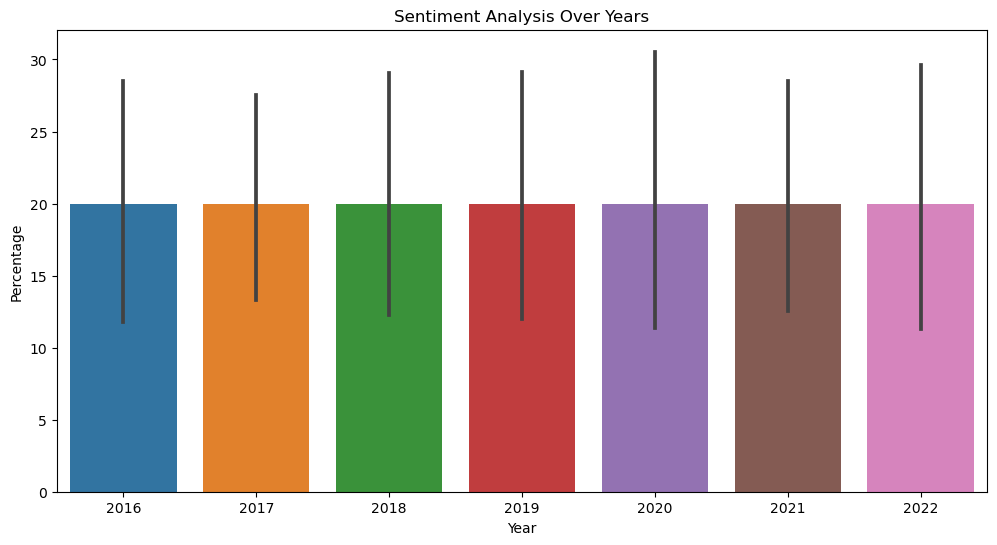

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

print(sentiment_df.head())  
print(sentiment_df.dtypes)  


# Plot without hue to see if data appears well
plt.figure(figsize=(12, 6))
sns.barplot(x='Year', y='Percentage', data=sentiment_df)
plt.title('Sentiment Analysis Over Years')
plt.show()


Now, we can visualize Sentiment Analysis Data

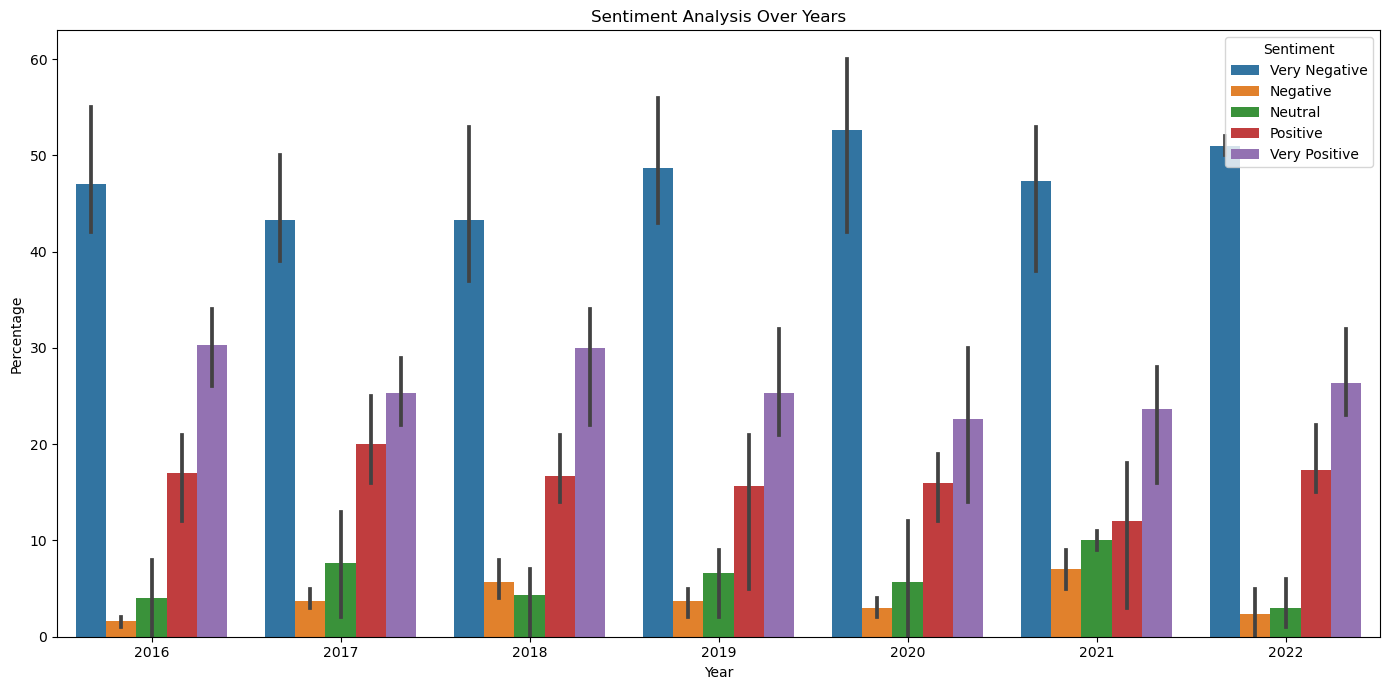

In [4]:
plt.figure(figsize=(14, 7))
sns.barplot(x='Year', y='Percentage', hue='Sentiment', data=sentiment_df)
plt.title('Sentiment Analysis Over Years')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


Interpretation:

The analysis reveals a prevalent occurrence of 'Very Negative' sentiments in each year, with significantly fewer instances of 'Negative' sentiments compared to 'Very Negative' sentiments. This could be indicative of a consistently critical tone in the coverage of homelessness issues.

The 'Neutral' sentiment appears to persist consistently over the years, with a slight uptick observed in 2021. This may suggest a consistent flow of objective or neutral reporting on the subject.

The fluctuations in 'Positive' and 'Very Positive' sentiments might signify shifts in policy or changes in public perception regarding homelessness over time.

Interestingly, it is worth noting that while 'Very Negative' sentiments increased from 2018 to 2020, 'Very Positive' sentiment decreased during the same period. This suggests an overall rise in negative sentiments during that time frame.

Additionally, we can try visualizing the average sentiment for each media outlet across all years.

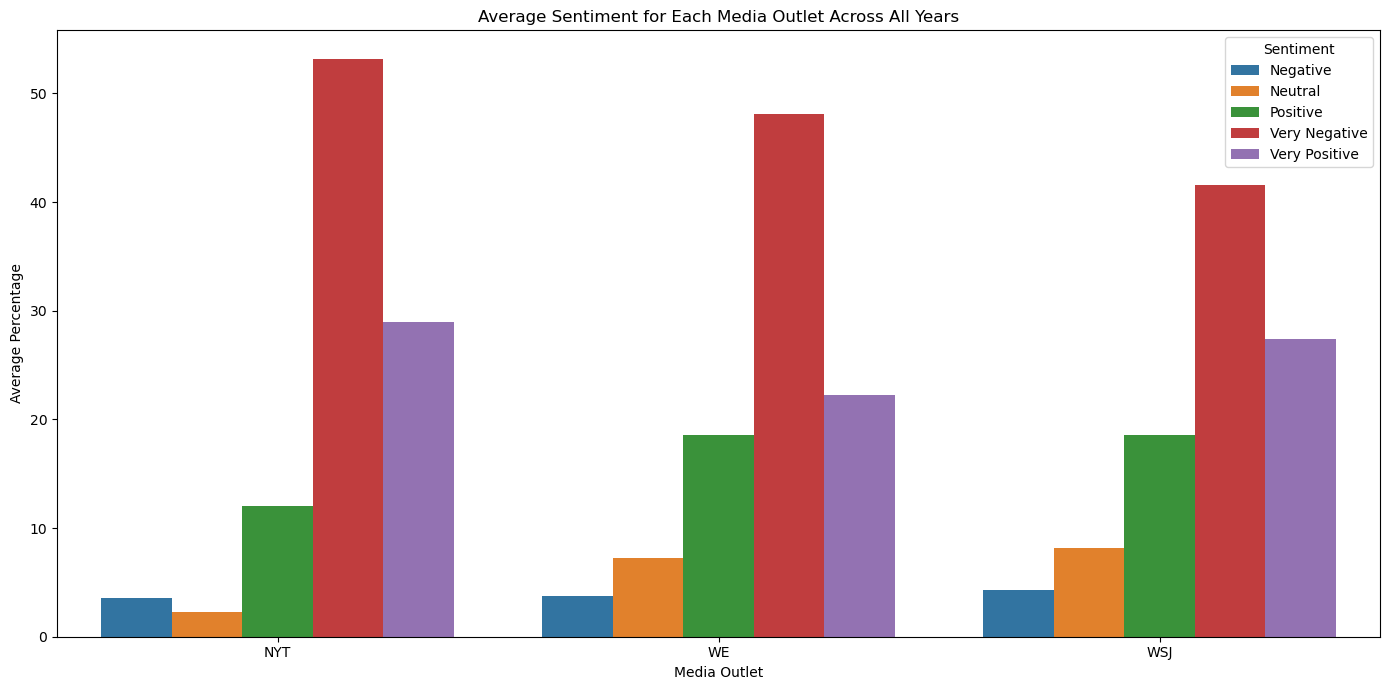

In [5]:
# Calculate the average sentiment for each media outlet
avg_sentiment = sentiment_df.groupby(['Source', 'Sentiment']).mean().reset_index()

# Plot
plt.figure(figsize=(14, 7))
sns.barplot(x='Source', y='Percentage', hue='Sentiment', data=avg_sentiment)
plt.title('Average Sentiment for Each Media Outlet Across All Years')
plt.xlabel('Media Outlet')
plt.ylabel('Average Percentage')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


Interpretation:

The New York Times (Left) stands out with a considerably higher 'Very Negative' sentiment, and it also contains a greater proportion of 'Negative' sentiment compared to other categories such as 'Neutral' and 'Positive.' This could suggest a more critical or pessimistic stance on homelessness issues. However, it's worth noting that The New York Times also exhibits a relatively higher 'Very Positive' sentiment, indicating their willingness to maintain optimism when necessary.

The Wall Street Journal (Center) and the Washington Examiner (Right) tend to maintain a higher 'Neutral' sentiment on average, hinting at a more balanced or detached reporting style. Notably, the Washington Examiner (Right) has the lowest occurrence of 'Very Positive' sentiment.

While 'Positive' sentiments are relatively lower across all outlets, when examining the combined 'Positive' and 'Very Positive' sentiments (green and purple bars), The New York Times (Left) and the Washington Examiner (Right) exhibit similar overall positive sentiment levels. However, The Wall Street Journal (Center) tends to lean more towards an overall positive tone. It's important to note that when comparing 'Very Positive' sentiment (green) to 'Positive' sentiment (purple), The New York Times appears to have a greater emphasis on very positive content than the other outlets.

Now, for word frequency:

Let's read and process Word Frequency file.

In [6]:
import pandas as pd

# Define the sources and years 
sources = ['NYT', 'WSJ', 'WE']
years = range(2016, 2023) 

# Function to parse word frequency results
def parse_word_freq_results(file_content):
    words = {}
    lines = file_content.strip().split("\n")
    for line in lines:
        if ": " in line:  # Check if the separator exists
            word, freq = line.split(": ")
            words[word.strip()] = int(freq)
    return words

# Loop over each file and process it
all_word_freq_results = []
for source in sources:
    for year in years:
        file_path = f"{source}_word_freq_{year}.txt"
        try:
            with open(file_path, 'r') as file:
                file_content = file.read()
                word_freq_results = parse_word_freq_results(file_content)
                # Add to the main list, including the source and year for each entry
                for word, freq in word_freq_results.items():
                    all_word_freq_results.append({
                        'Source': source, 
                        'Year': year, 
                        'Word': word, 
                        'Frequency': freq
                    })
        except FileNotFoundError:
            print(f"File not found: {file_path}")
            continue

# Create a dataframe from the results
word_freq_df = pd.DataFrame(all_word_freq_results)

print(word_freq_df.columns)


Index(['Source', 'Year', 'Word', 'Frequency'], dtype='object')


Now, we can visualize Word Frequency data.

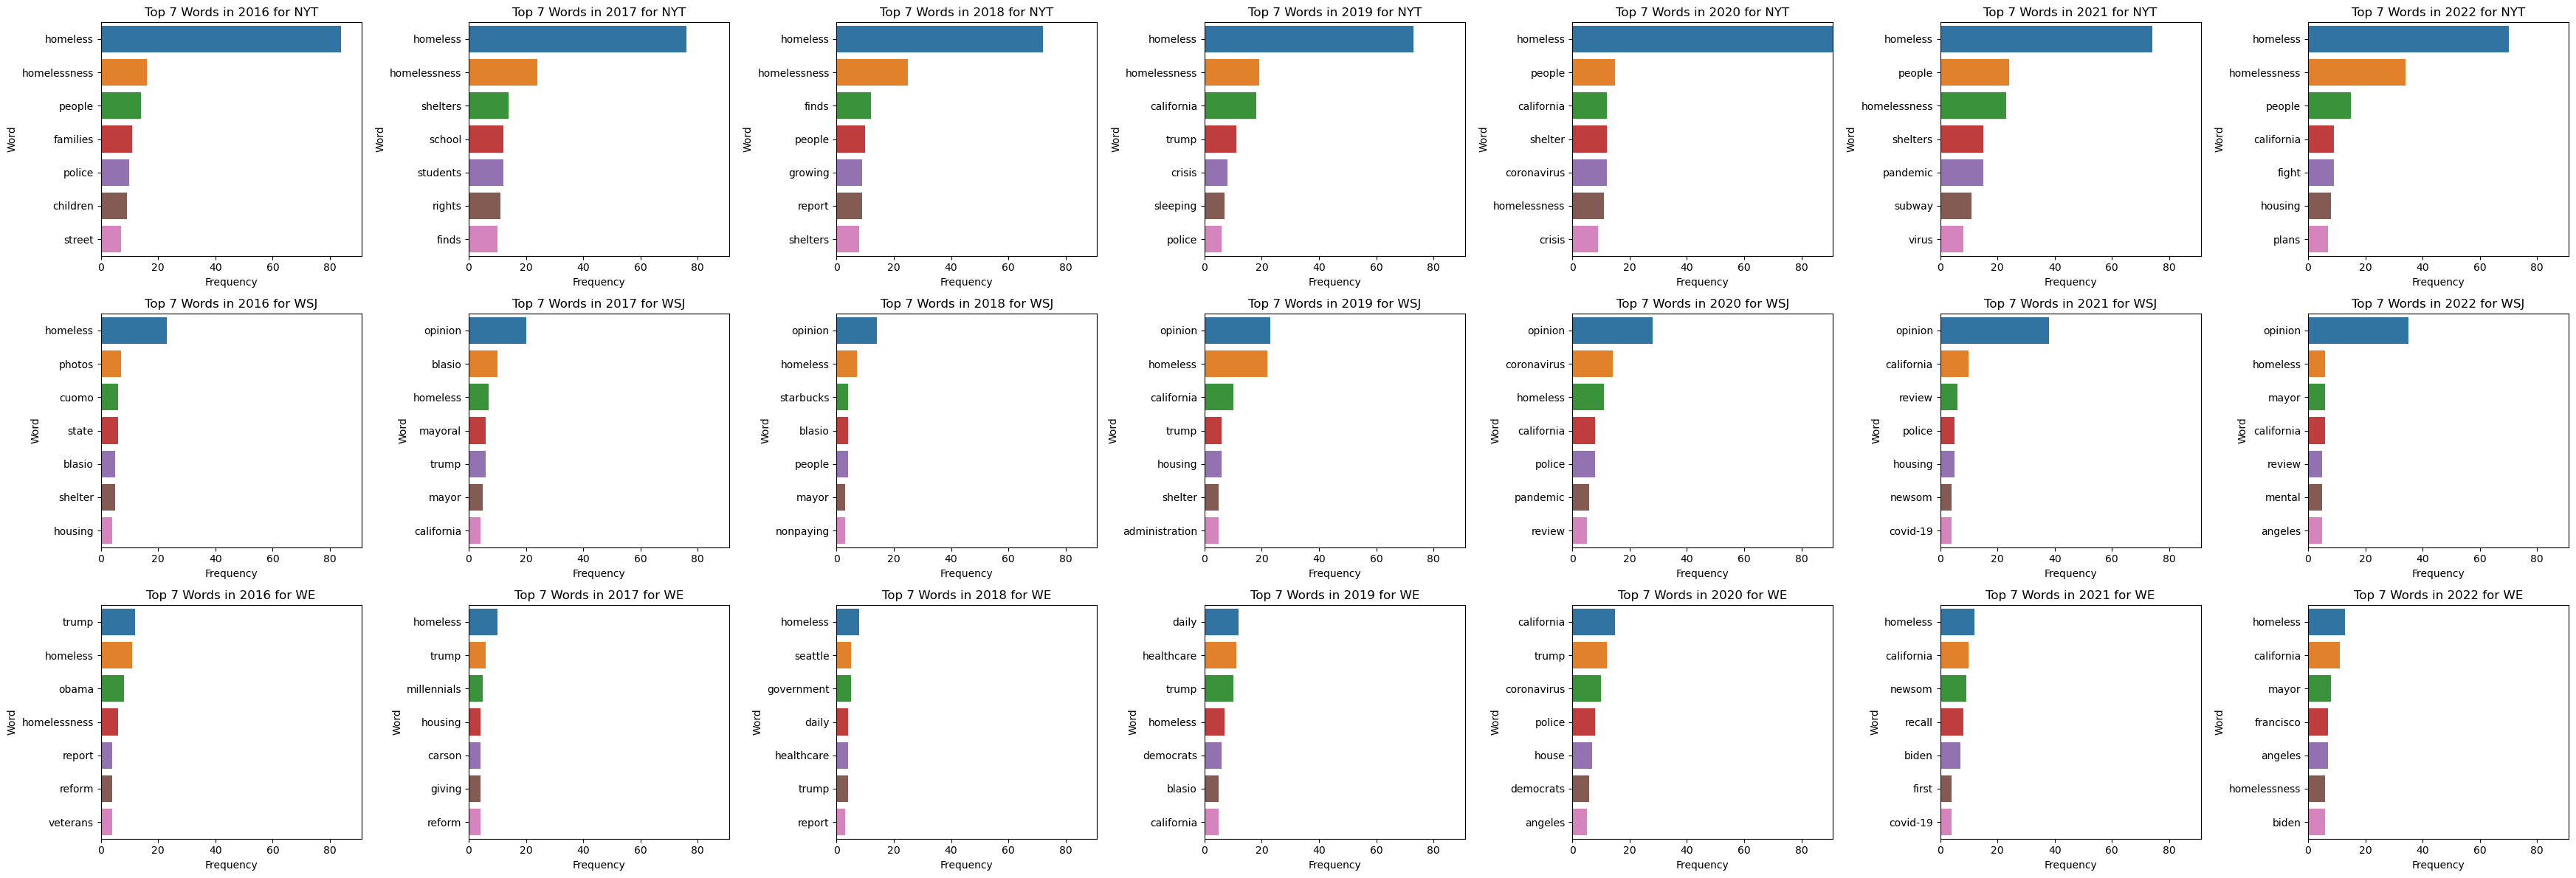

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt


# Top 7 words for each year for each media source
top_n = 7
num_sources = len(sources)
num_years = len(years)

# Calculate the maximum frequency to set a common scale for y-axis
max_frequency = word_freq_df['Frequency'].max()

fig, axes = plt.subplots(num_sources, num_years, figsize=(num_years * 5, num_sources * 4))  # Adjust size as needed

for i, source in enumerate(sources):
    for j, year in enumerate(years):
        # Filter the DataFrame for the year and source and get the top N words
        df_year_source = word_freq_df[(word_freq_df['Year'] == year) & (word_freq_df['Source'] == source)]
        top_words_year_source = df_year_source.nlargest(top_n, 'Frequency')
        
        # Create a barplot for each year and source
        ax = axes[i][j] if num_sources > 1 else axes[j]
        sns.barplot(x='Frequency', y='Word', data=top_words_year_source, errorbar=None, ax=ax)
        ax.set_title(f'Top {top_n} Words in {year} for {source}')
        ax.set_xlim(0, max_frequency)  # Set the x-axis limits to be the same for all subplots

# Adjust layout spacing
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.tight_layout()
plt.show()

Interpretation:

Keywords like "shelters," "school," and "crisis" suggest discussions about societal and systemic aspects of homelessness. Meanwhile, "California," "Trump," and "policy" indicate political dimensions and a regional focus in media narratives. Furthermore, the appearance of terms related to the COVID-19 pandemic in 2020 highlights the pandemic's impact on homelessness. 

These plots will be valuable when we later analyze sentiment in conjunction with homeless count data, providing detailed and deeper insights into possible factors of certain observations.

Now, for topic analysis:

Let's read and process topic analysis file.

In [8]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define sources and years
sources = ['NYT', 'WSJ', 'WE']
years = range(2016, 2023)

# Function to parse topics
def parse_topics_data(file_path):
    try:
        with open(file_path, 'r') as file:
            file_content = file.read()
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return []
    
    topics_data = re.findall(r'\((\d+),\s\'(.+?)\'\)', file_content)
    parsed_data = []
    for topic_num, topic_content in topics_data:
        # Correctly extract terms and weights
        terms = re.findall(r'(\d*\.\d+|\d+)\*\"([^\"]+)\"', topic_content)
        for weight, term in terms:
            parsed_data.append({
                'Topic': int(topic_num),
                'Term': term.strip(),
                'Weight': float(weight)
            })
    return parsed_data

Now, we can visualize this.

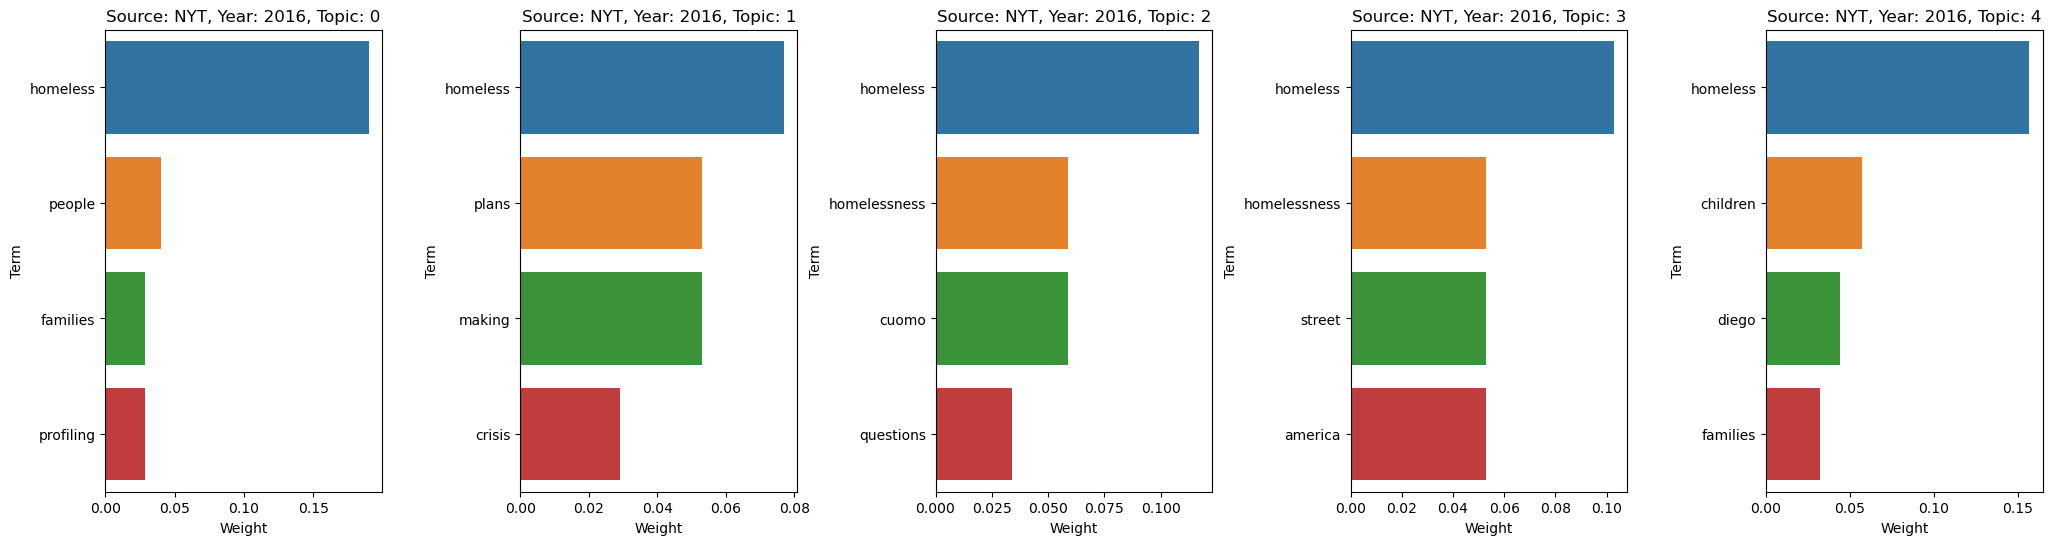

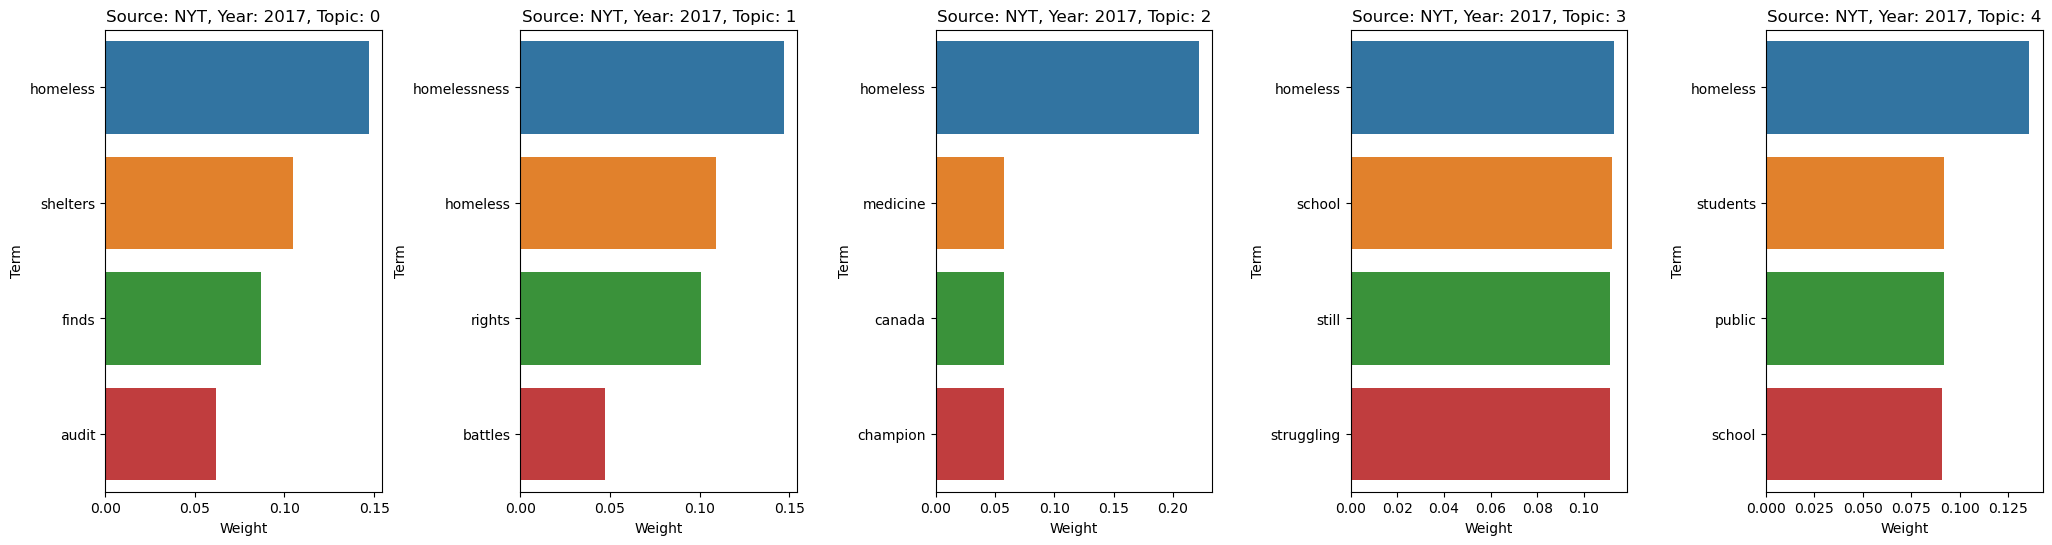

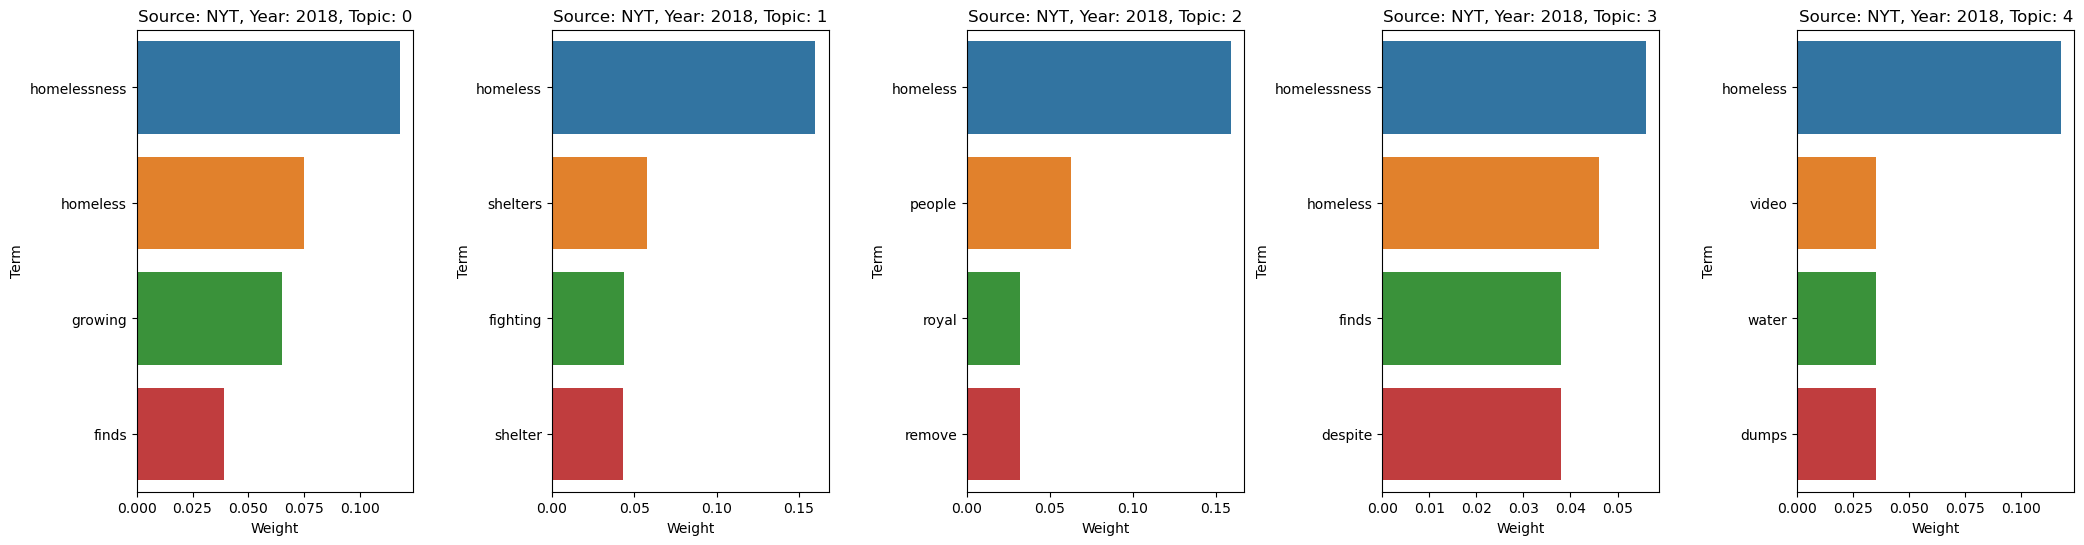

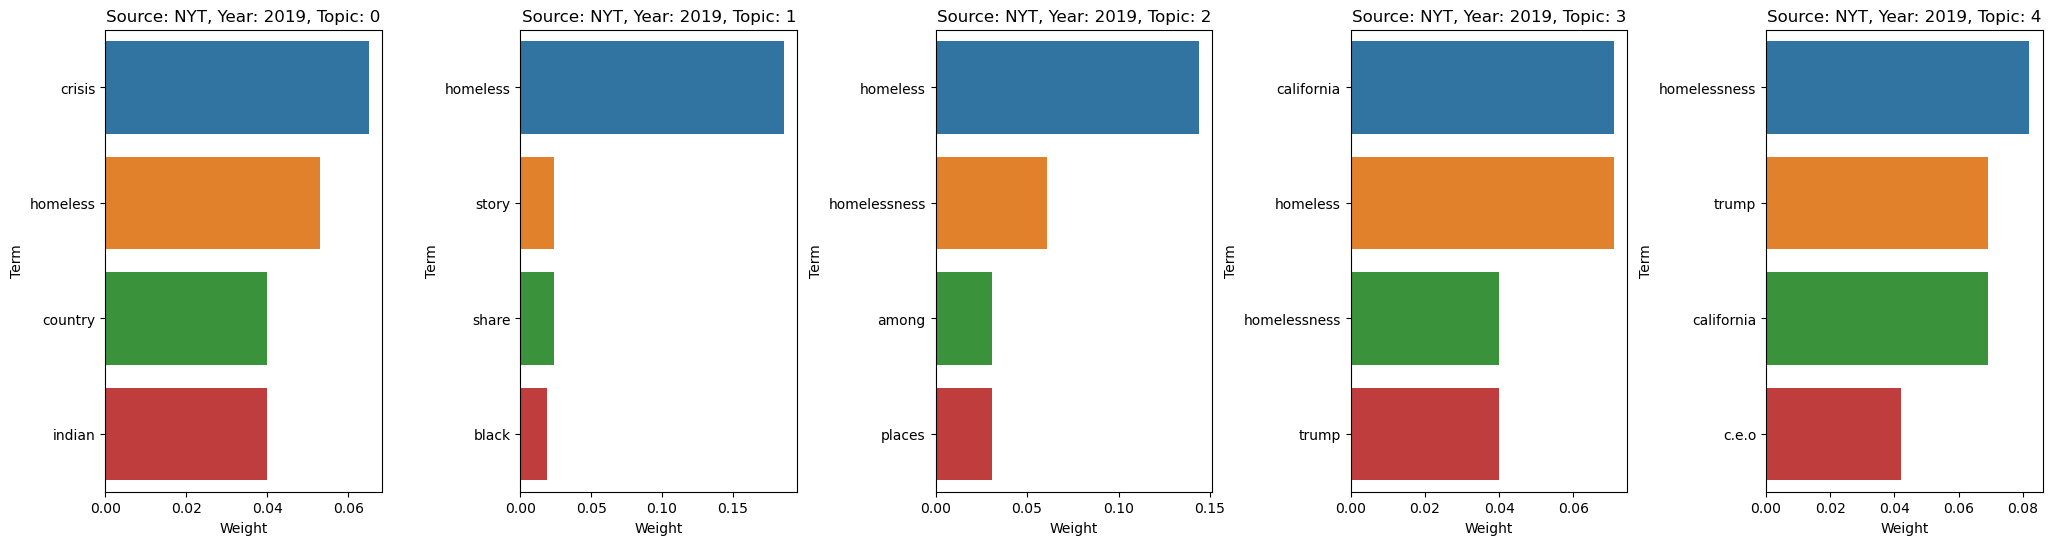

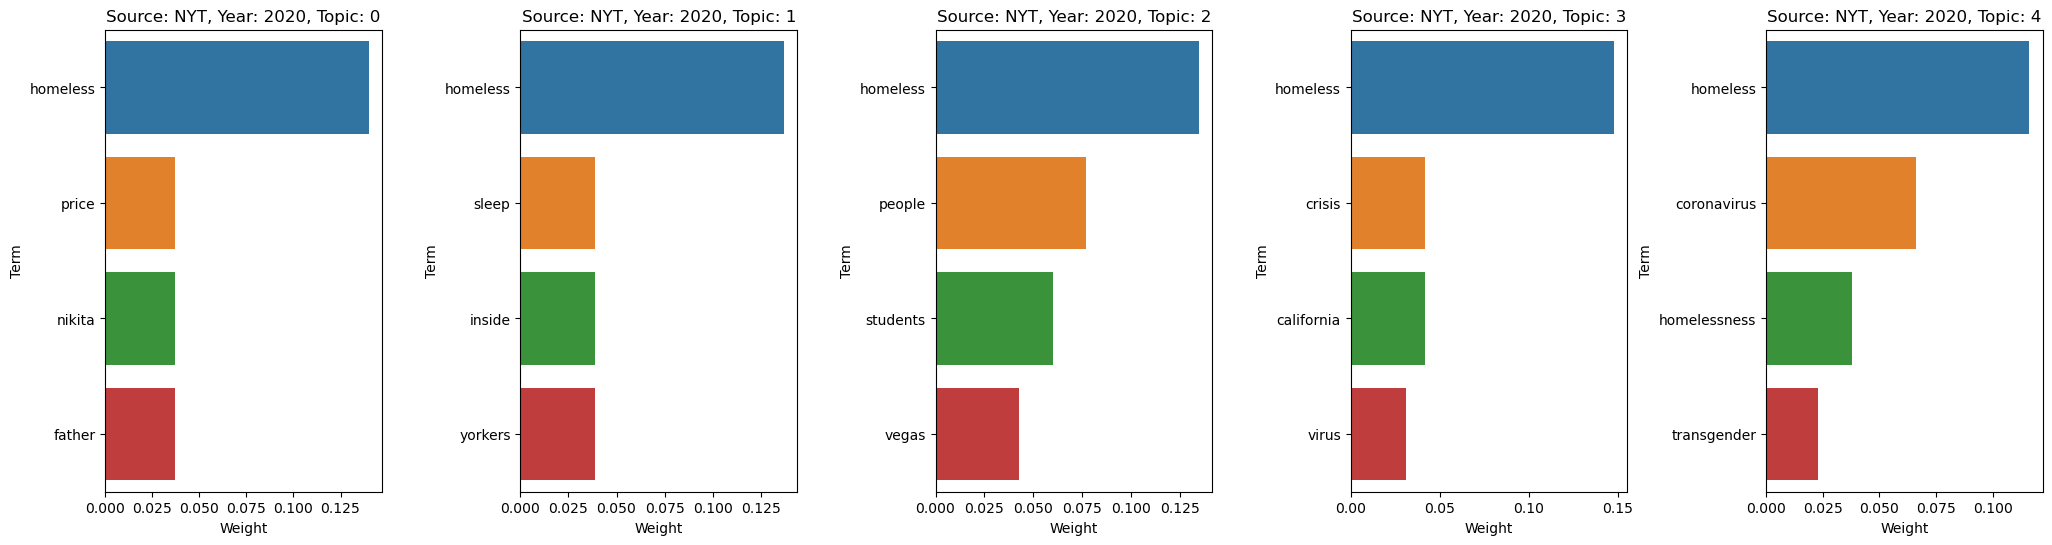

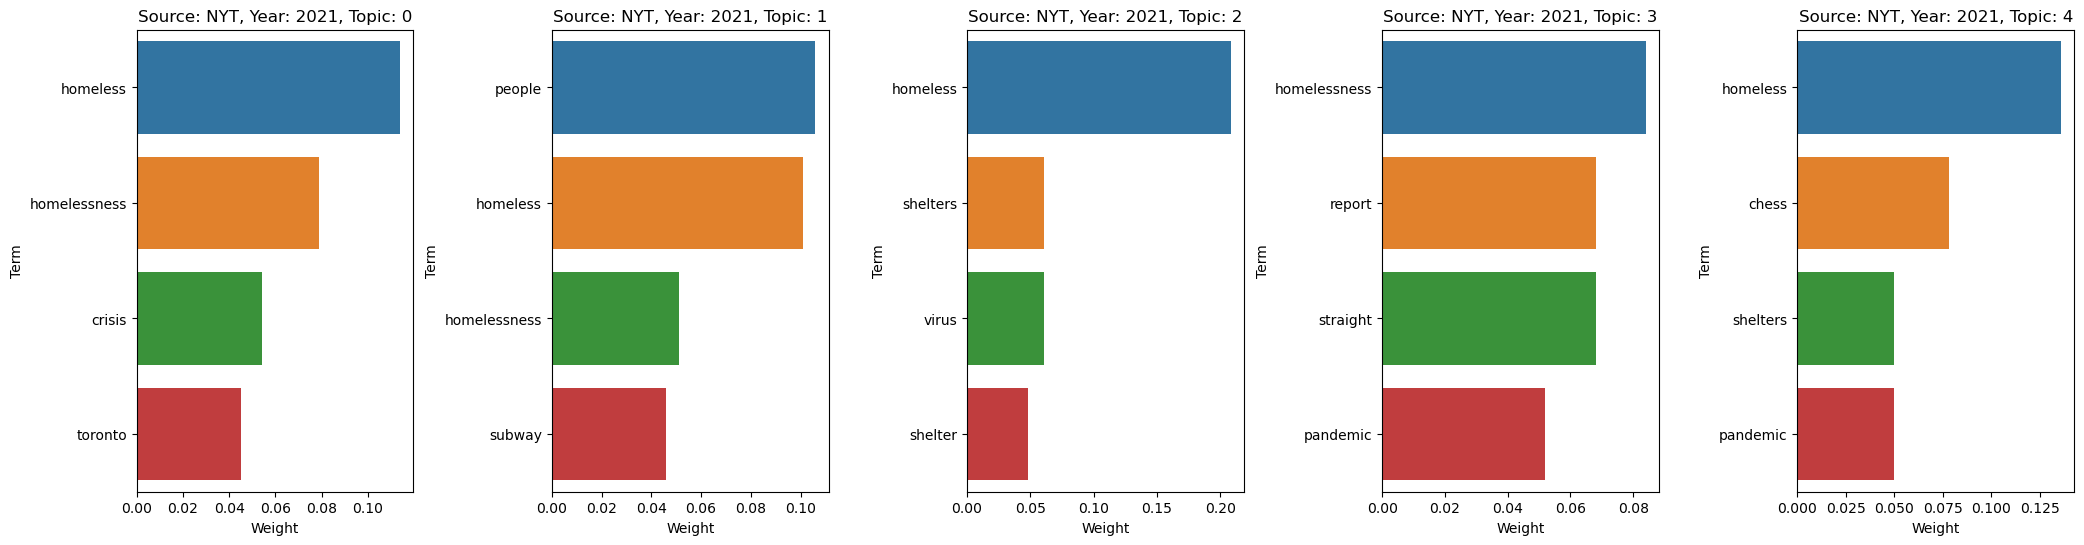

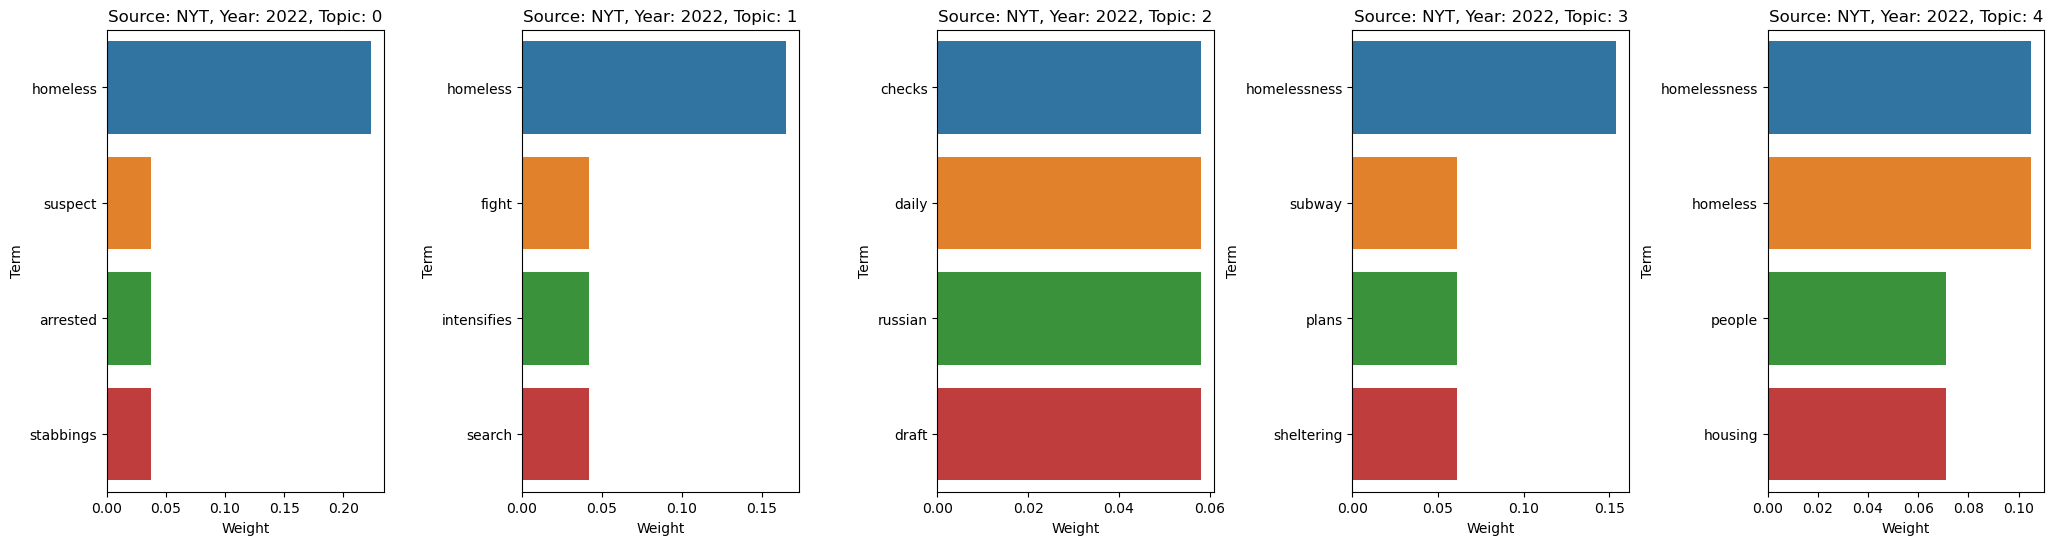

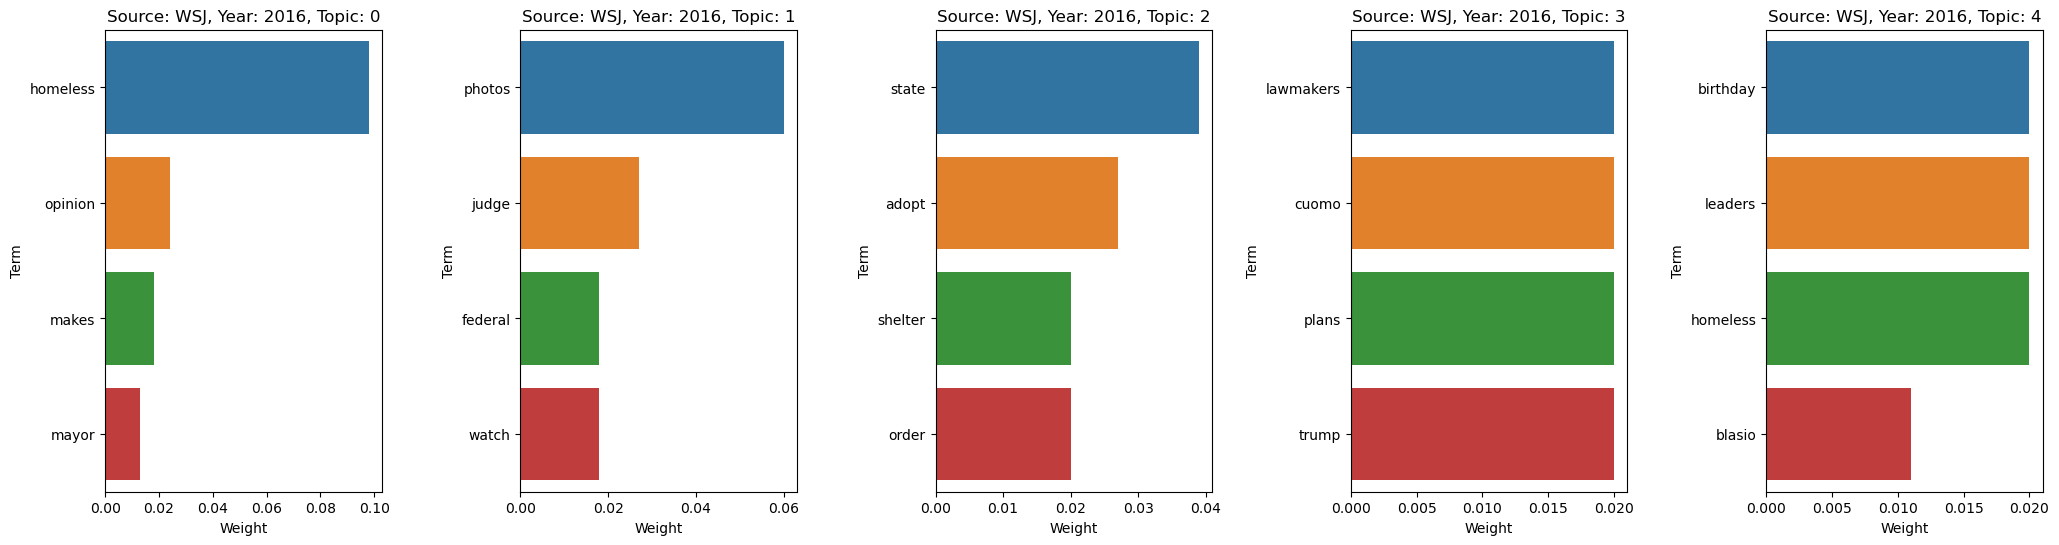

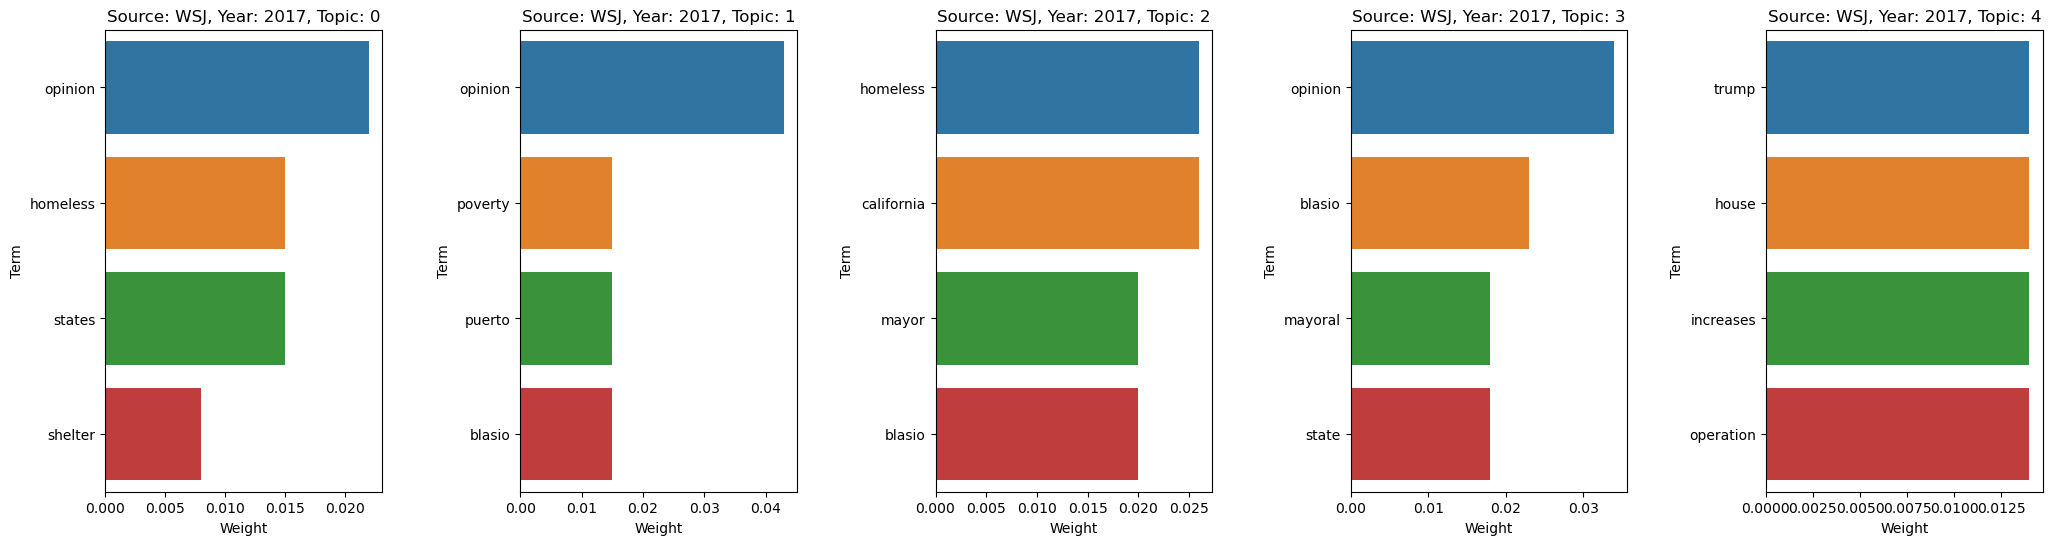

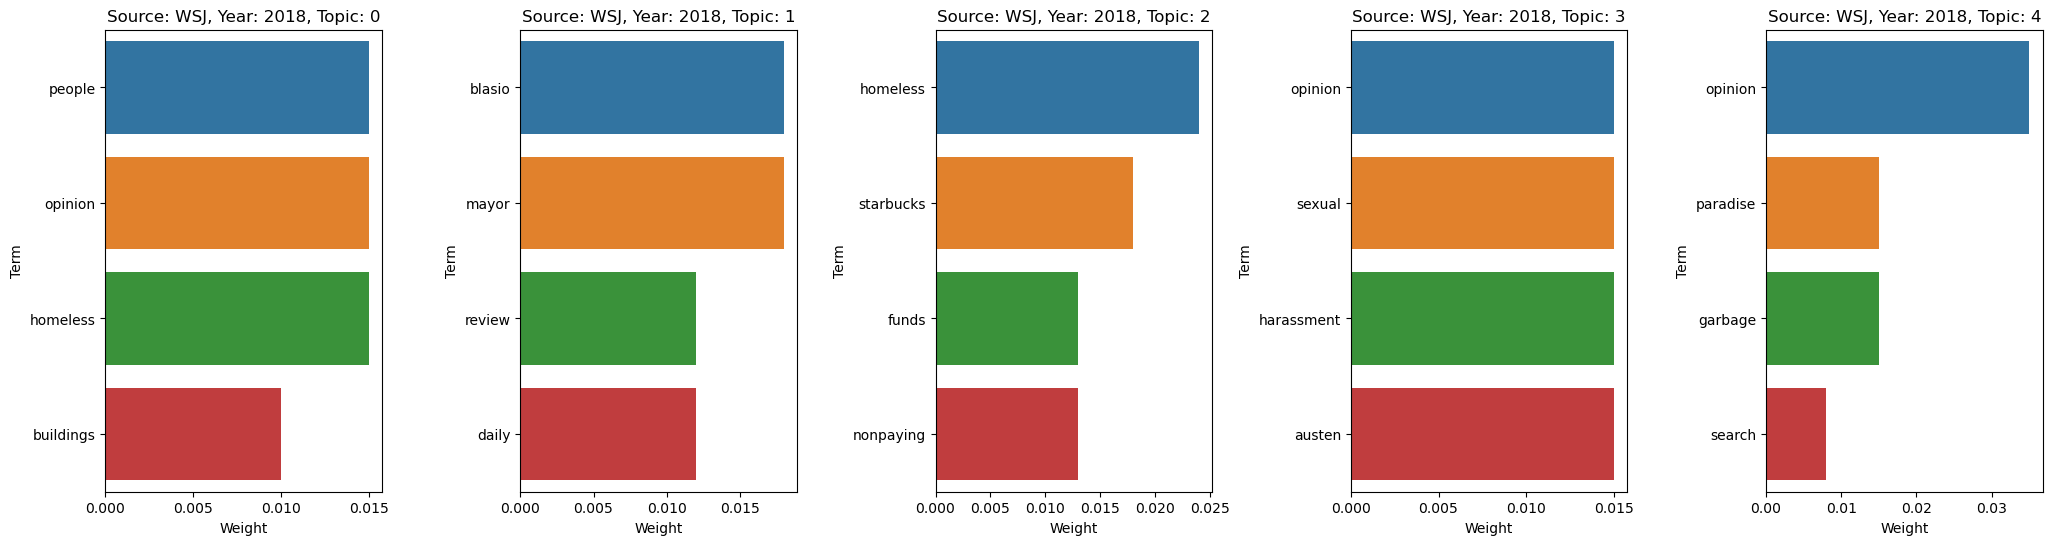

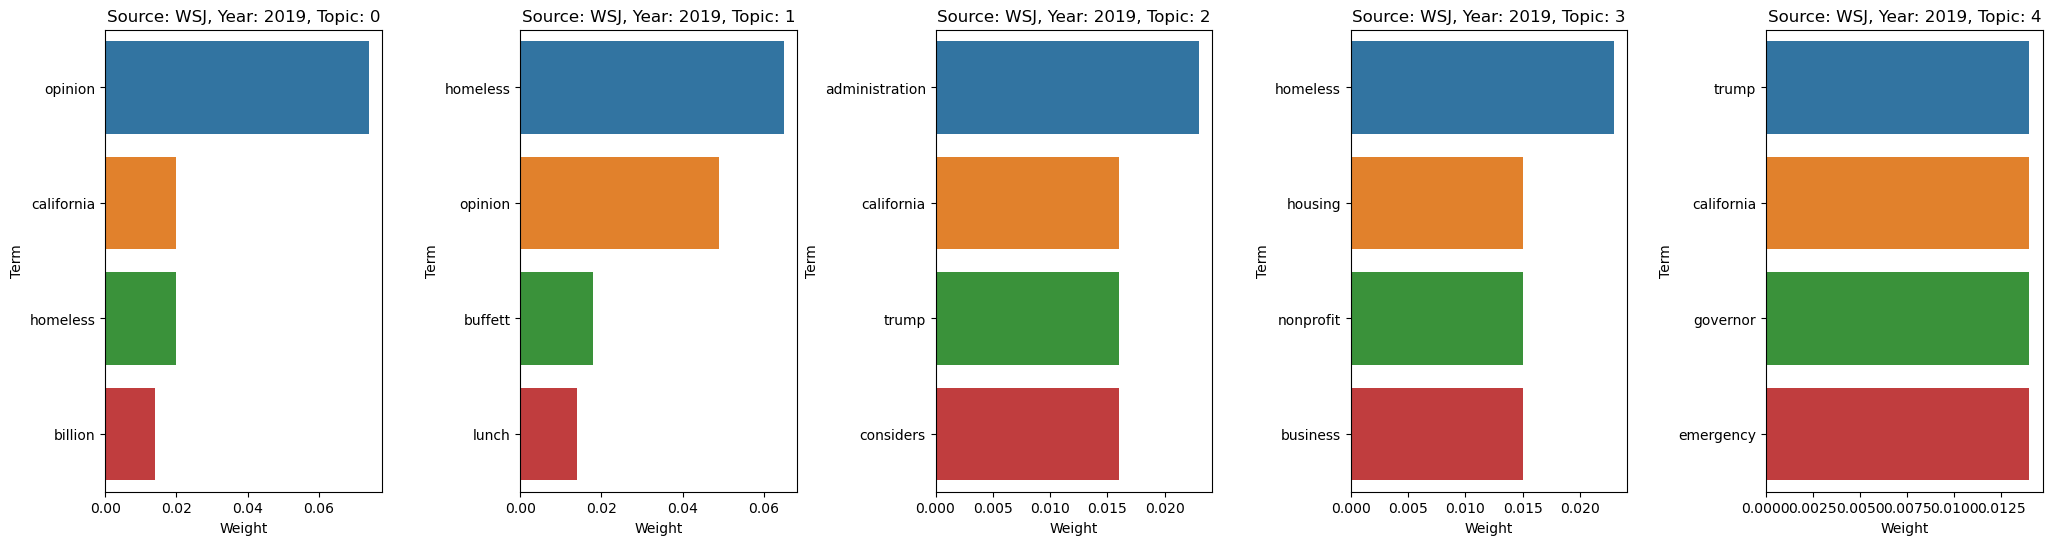

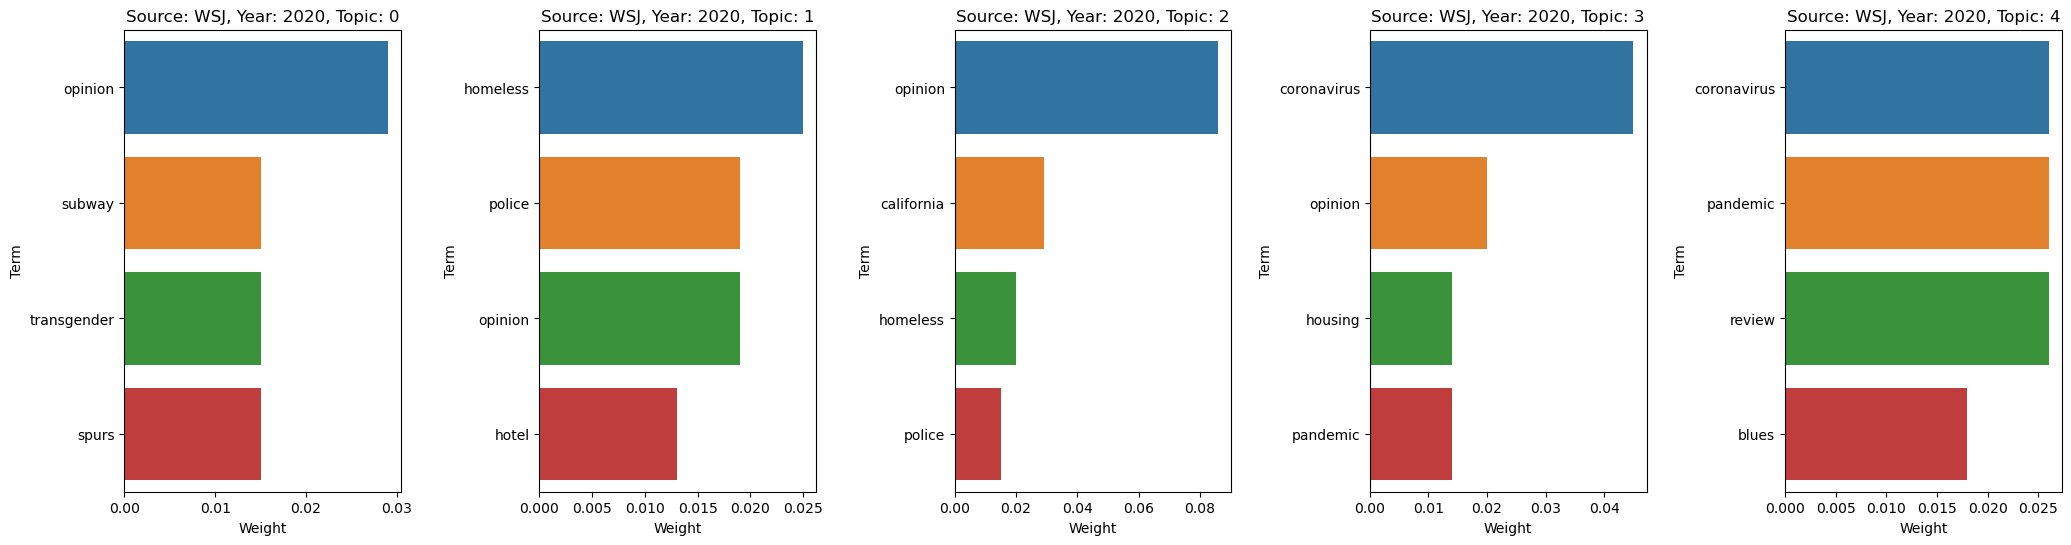

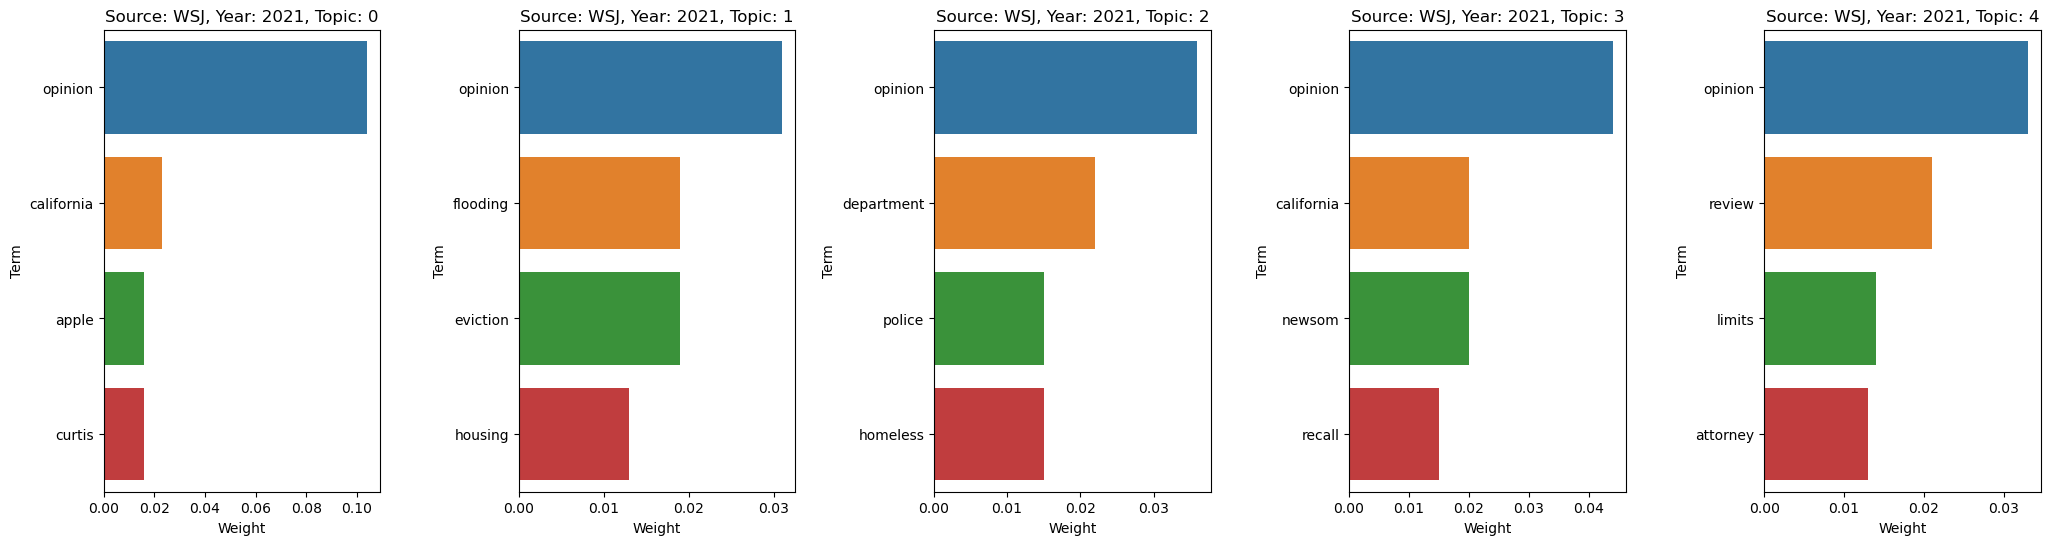

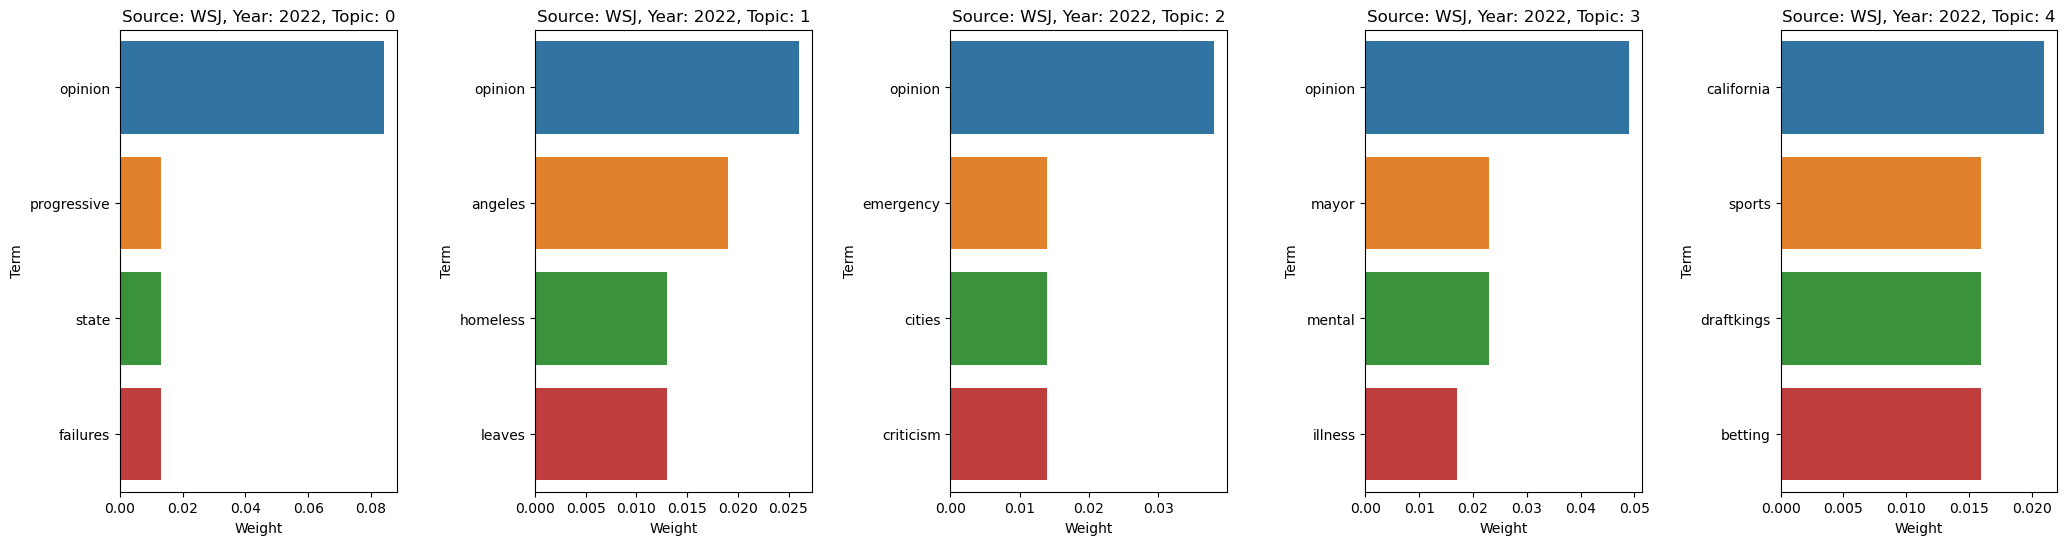

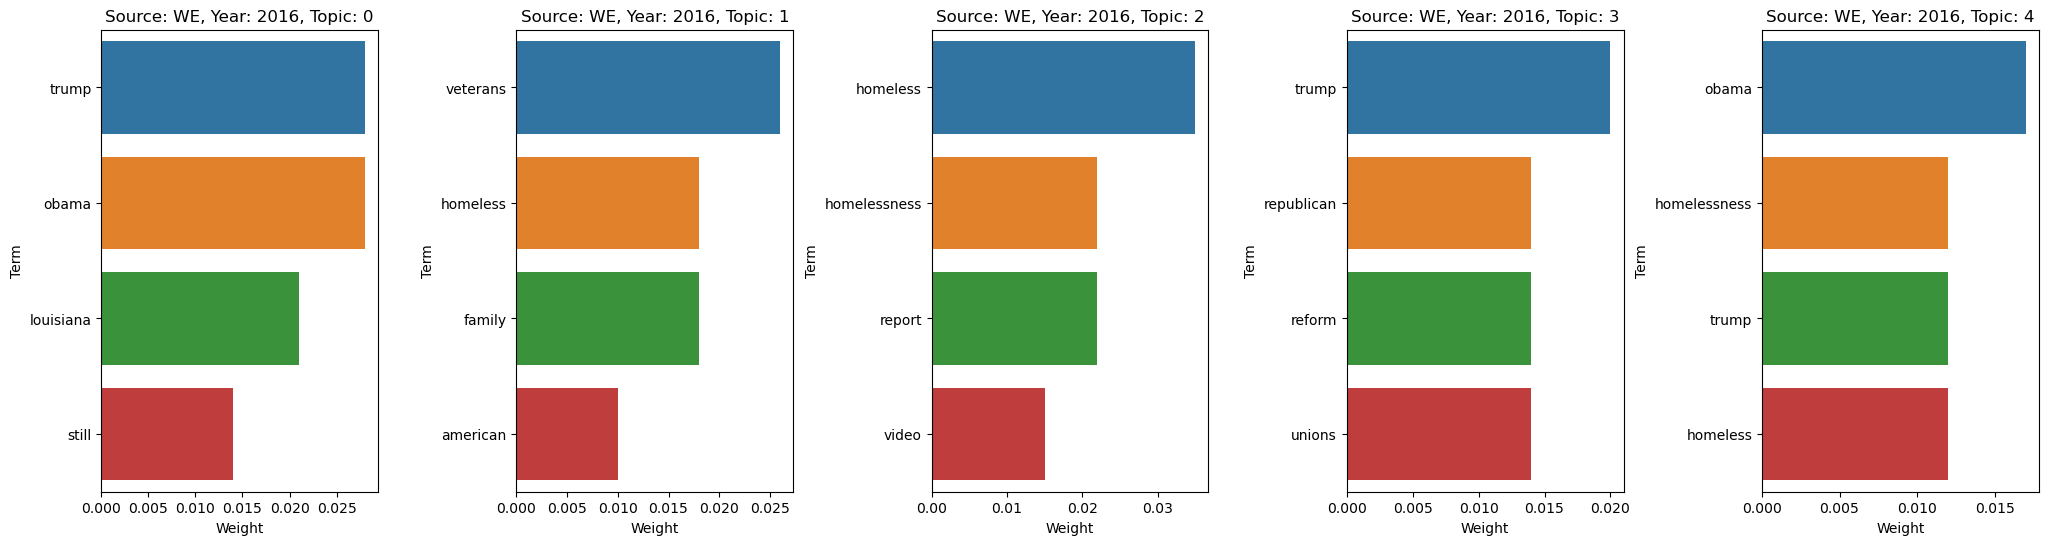

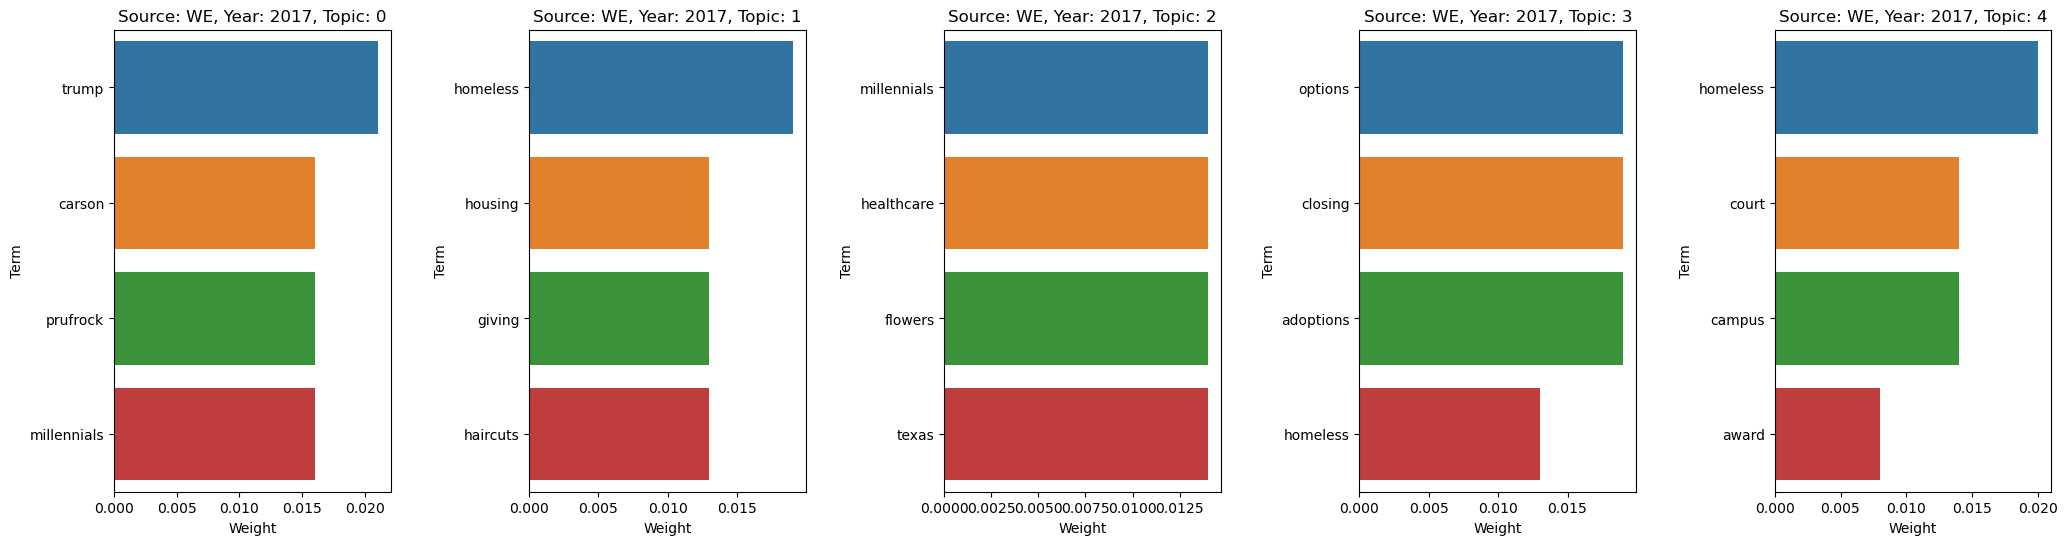

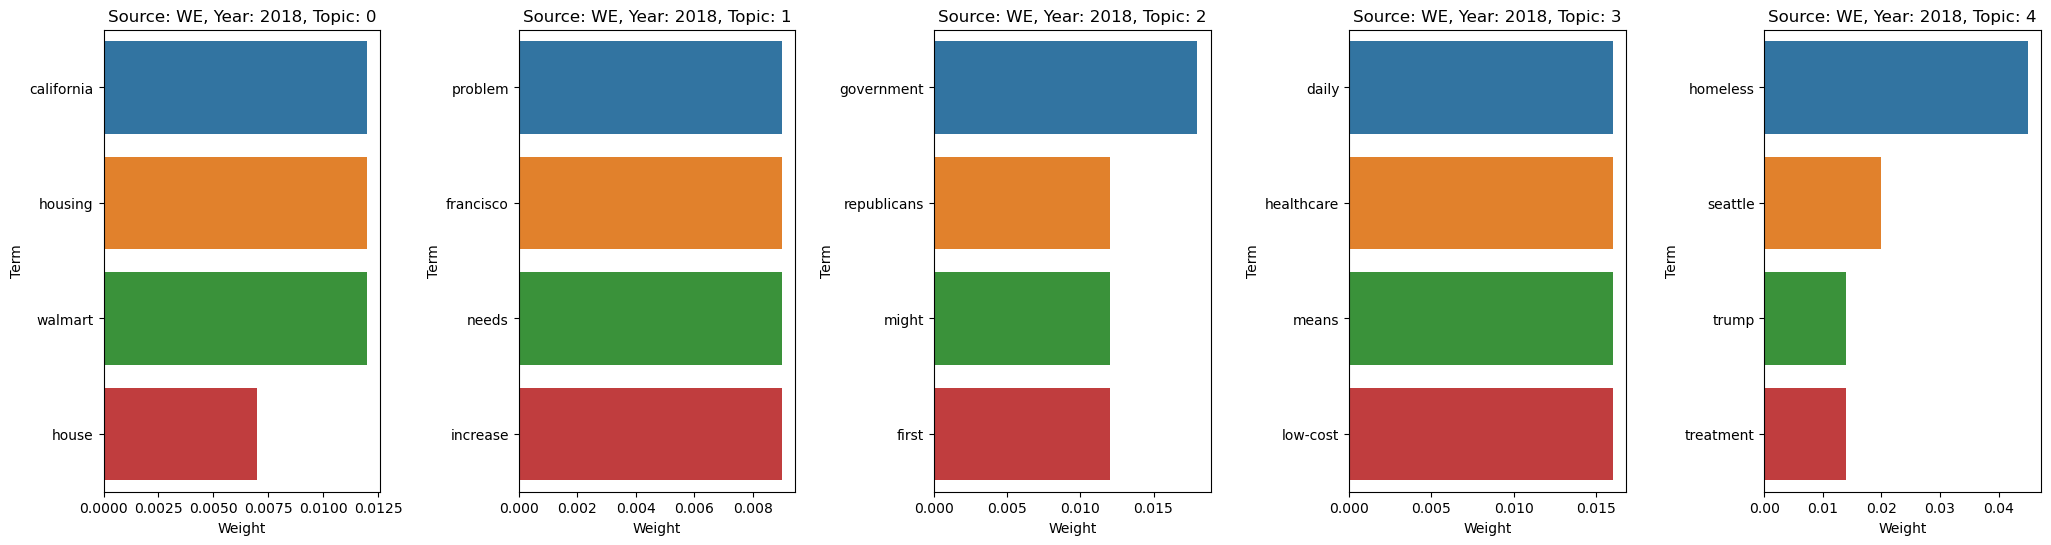

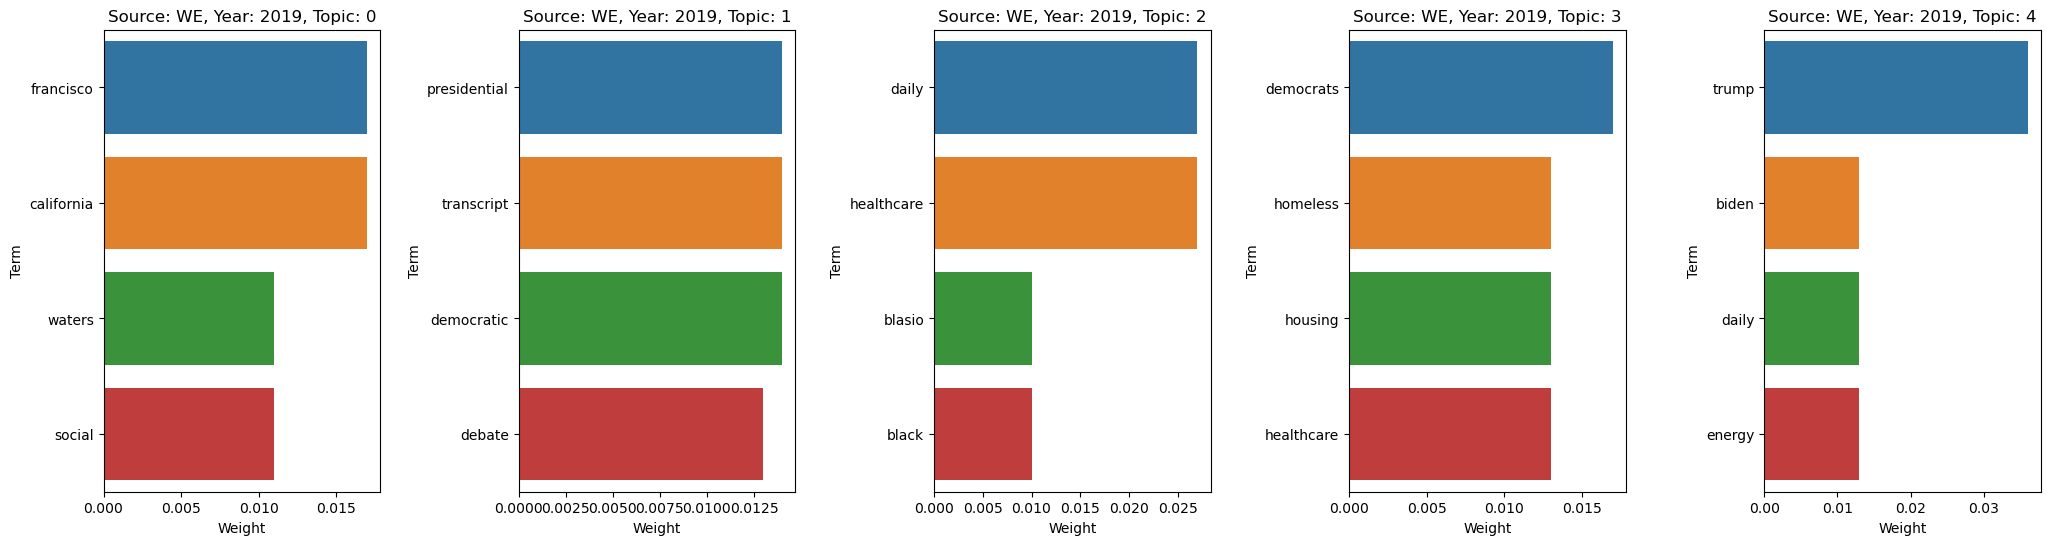

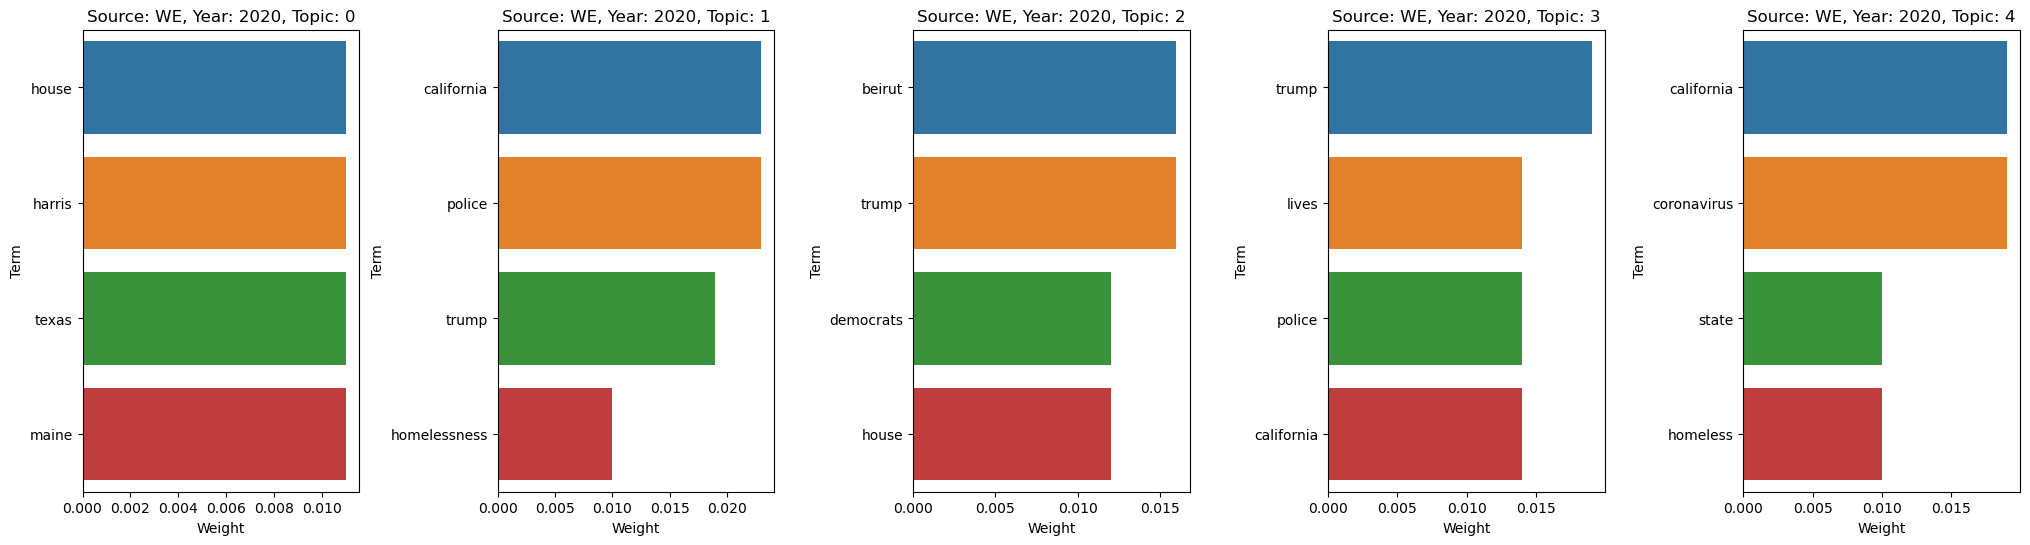

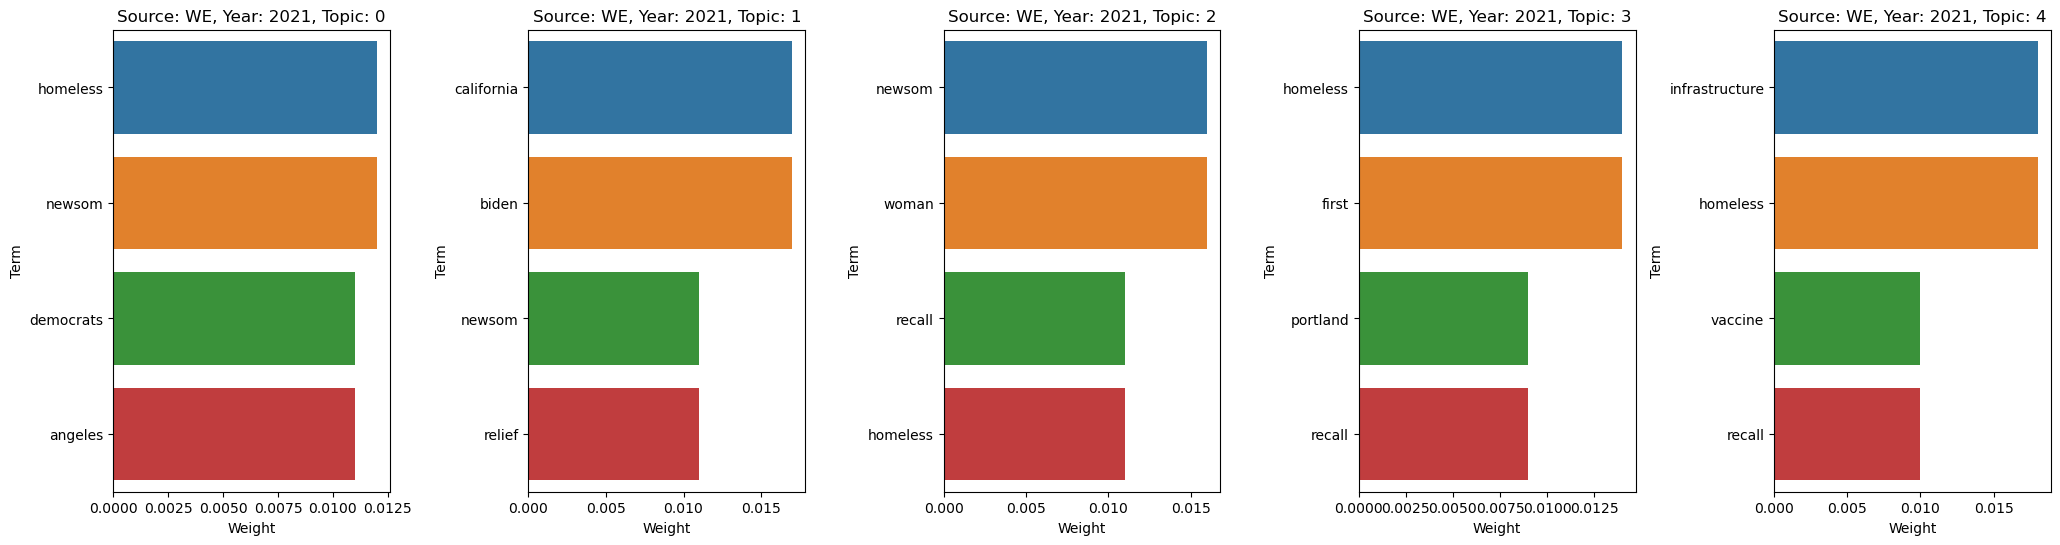

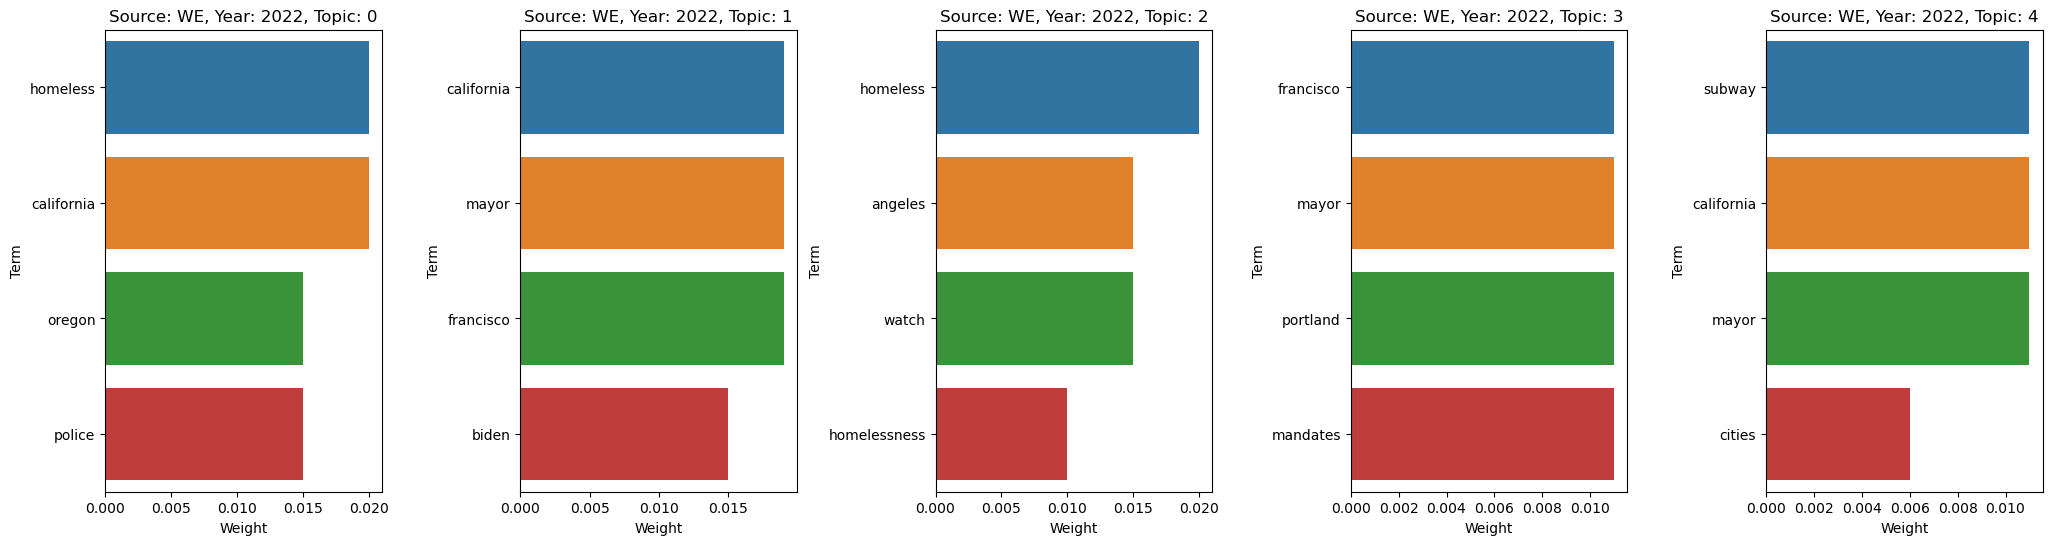

In [9]:
# Function to plot topics
def plot_topic_terms(df, source, year):
    num_topics = df['Topic'].nunique()
    fig, axes = plt.subplots(1, num_topics, figsize=(5 * num_topics, 6))  # Adjust the width as necessary
    
    for idx, topic in enumerate(sorted(df['Topic'].unique())):
        topic_data = df[df['Topic'] == topic].sort_values('Weight', ascending=False)
        ax = axes[idx] if num_topics > 1 else axes
        sns.barplot(x='Weight', y='Term', data=topic_data, ax=ax)
        ax.set_title(f'Source: {source}, Year: {year}, Topic: {topic}')
        ax.set_xlabel('Weight')
        ax.set_ylabel('Term')  # Set y-label for each subplot

    plt.subplots_adjust(wspace=0.5)  # Adjust horizontal space between subplots
    plt.show()

# Loop
for source in sources:
    for year in years:
        file_path = f"{source}_topics_{year}.txt"
        topics_data = parse_topics_data(file_path)
        if topics_data:  # Check if topics_data is not empty
            topics_df = pd.DataFrame(topics_data)
            plot_topic_terms(topics_df, source, year)

Topics- The New York Times (Left)


- 2016: Topics range from general homelessness discussions to policy plans, questions about homelessness, and children and family-related discussions.

- 2017: Focus on living conditions and education of the homeless, with Topic 4 suggesting a discussion about the public and school systems' role.

- 2018: Topics revolve around growing homelessness concerns and societal responses, with hints of environmental discussions in Topic 4.

- 2019: Broad discussions about homelessness in societal context, individual stories, and political aspects.

- 2020: Impact of the pandemic on homelessness discussions, possibly human-interest stories.

- 2021: Ongoing crisis focus, people's role, and pandemic impact, with niche discussions in Topic 4.

- 2022: Shift to immediate concerns like crime and policy responses, housing solutions in Topic 4.


Summary: In recent years, The New York Times has shifted its focus towards immediate concerns such as crime, housing solutions, and policy discussions. This reflects a move away from broader societal discussions, while homelessness remains a central theme throughout. The New York Times often delves into policy and social issues related to homelessness, addressing the topic in a comprehensive and policy-oriented manner.

Topics- The Wall Street Journal (Center)

- 2016: Focus on political leadership, legal aspects, state policies, and personal narratives.

- 2017: Public opinions and political dimensions in California, housing operations, and national policy impacts.

- 2018: Coverage includes societal infrastructure, business roles, gender issues, and municipal operations.

- 2019: Financial discussions in California, influential individuals, administration policies, emergency services.

- 2020: Pandemic's influence, public transport, law enforcement's role, and economic impacts.

- 2021: Tech perspectives, social issues, political responses, legal reviews, and housing opinions.

- 2022: Critiques of progressive policies, public criticism, mental health, and economic connections in sports betting.

Summary: The Wall Street Journal continues to emphasize critiques of progressive policies, political mandates, and city-specific policies. This maintains the newspaper's comprehensive coverage, focusing on opinion, policy, economics, and political leadership. The Wall Street Journal approaches homelessness with a strong emphasis on opinion and policy analysis, providing a balanced perspective on the issue.

Topics- The Washington Examiner (Right)

- 2016: Political dialogue around homelessness, focus on figures like Trump and Obama, family, and veterans.

- 2017: Political figures with social issues, possible housing policy discussions, and generational impacts.

- 2018: Regional focus on California, corporate involvement, and city-specific discussions.

- 2019: Diversified conversation, political debates, healthcare, and daily experiences related to homelessness.

- 2020: Pandemic's intersection with homelessness, potential human-interest stories.

- 2021: Ongoing discussions around homelessness crisis, governance role, pandemic impact, and vaccine distribution.

- 2022: Immediate concerns like crime and housing solutions, political mandates, and city-specific policies.

Summary: The Washington Examiner maintains its focus on immediate concerns like crime, housing solutions, and political matters. This highlights the ongoing examination of homelessness in the context of current events, governance, and policy. The Washington Examiner's coverage of homelessness is characterized by its attention to political matters and immediate concerns, offering a perspective aligned with right-leaning viewpoints.


Different Narratives Across Media outlets:

The New York Times maintains a policy-centric lens, often integrating broader societal implications with specific policy discussions. In contrast, The Wall Street Journal presents a more economically and politically analytical viewpoint, merging financial implications with social policies. The Washington Examiner's coverage is notably more politically charged, frequently framing homelessness within current political debates and immediate societal impacts. 

Topic analysis has uncovered dynamic discussions concerning homelessness, mirroring contemporary events, political dynamics, and societal shifts. Similar to word frequency analysis, this approach will offer further insights into our forthcoming examination of homeless population data, allowing us to gain a more comprehensive and nuanced understanding of potential determinants underlying specific observations.

# Part 5

5. Annual Total Homeless Counts (2015-2022):
    * Calculate the annual total homeless counts for each year from a dataset file 'Data_AllYearsCombined.csv'.
    * Create a line graph to visualize the homelessness trend from 2016 to 2022.
    * Adjust 2021 Data.
   

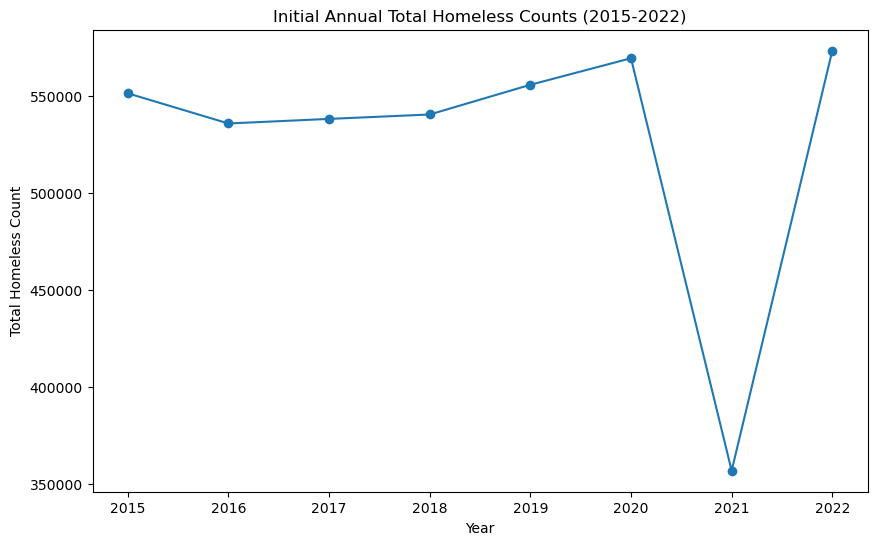

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Data_AllYearsCombined.csv')
df = df[['Year', 'Overall Homeless']]

# Aggregate Data
annual_homeless_counts = df.groupby('Year')['Overall Homeless'].sum().reset_index()

# Initial Line Graph
plt.figure(figsize=(10, 6))
plt.plot(annual_homeless_counts['Year'], annual_homeless_counts['Overall Homeless'], marker='o')
plt.title('Initial Annual Total Homeless Counts (2015-2022)')
plt.xlabel('Year')
plt.ylabel('Total Homeless Count')
plt.grid(False)
plt.show()


Adjustment for 2021 Data:

* Before proceeding with analysis, acknowledge the anomaly in the 2021 data due to the COVID-19 pandemic.

* Calculate the average homeless count of 2020 and 2022. Use this average as the count for 2021.


Adjustment of 2021 Homeless Count Data
Due to the unique impact of the COVID-19 pandemic, the 2021 homeless count data significantly deviates from the surrounding years. To maintain consistency in our analysis, we've averaged the counts from 2020 and 2022 as a substitute for 2021. This decision is based on the similarity of counts in these adjacent years and assumes a stable trend.

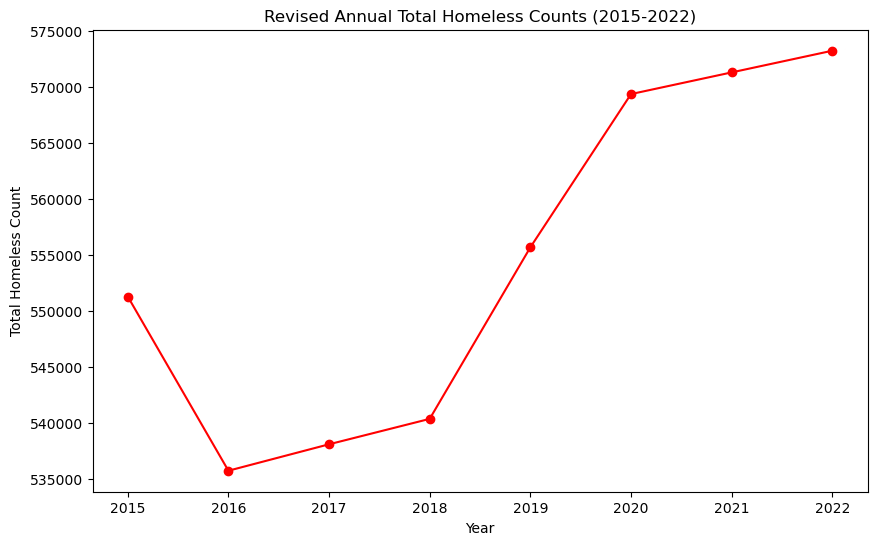

In [11]:
# Adjust for 2021 Data
avg_2020_2022 = annual_homeless_counts[annual_homeless_counts['Year'].isin([2020, 2022])]['Overall Homeless'].mean()
annual_homeless_counts.loc[annual_homeless_counts['Year'] == 2021, 'Overall Homeless'] = avg_2020_2022

# Revised Line Graph
plt.figure(figsize=(10, 6))
plt.plot(annual_homeless_counts['Year'], annual_homeless_counts['Overall Homeless'], marker='o', color='red')
plt.title('Revised Annual Total Homeless Counts (2015-2022)')
plt.xlabel('Year')
plt.ylabel('Total Homeless Count')
plt.grid(False)
plt.show()


While this adjustment helps align the 2021 data with the overall trend, it's an estimation that may not fully capture all variables affecting homelessness in that year. Therefore, conclusions involving 2021 should be interpreted with this context in mind. This method was selected after careful consideration and consultation, striving to balance accuracy and completeness in our analysis under exceptional circumstances.

# Part 6

6. Comparative Analysis of Media Sentiment:
    * Create a line plot showing the alignment of overall sentiment analysis by different media outlets.
    * Investigate differences in media portrayal of homelessness, reflecting potential biases.
    * To do this, we use Min-Max normalization (range between 0 and 1).

First, let's try comparing Media sentiments over years.

Source         NYT                                                    WE  \
Sentiment Negative Neutral Positive Very Negative Very Positive Negative   
Year                                                                       
2016           2.0     0.0     12.0          55.0          31.0      1.0   
2017           3.0     2.0     16.0          50.0          29.0      5.0   
2018           4.0     0.0     21.0          53.0          22.0      5.0   
2019           5.0     2.0      5.0          56.0          32.0      2.0   
2020           2.0     0.0     12.0          56.0          30.0      4.0   
2021           9.0    10.0      3.0          51.0          27.0      7.0   
2022           0.0     2.0     15.0          51.0          32.0      2.0   

Source                                                      WSJ          \
Sentiment Neutral Positive Very Negative Very Positive Negative Neutral   
Year                                                                      
2016          

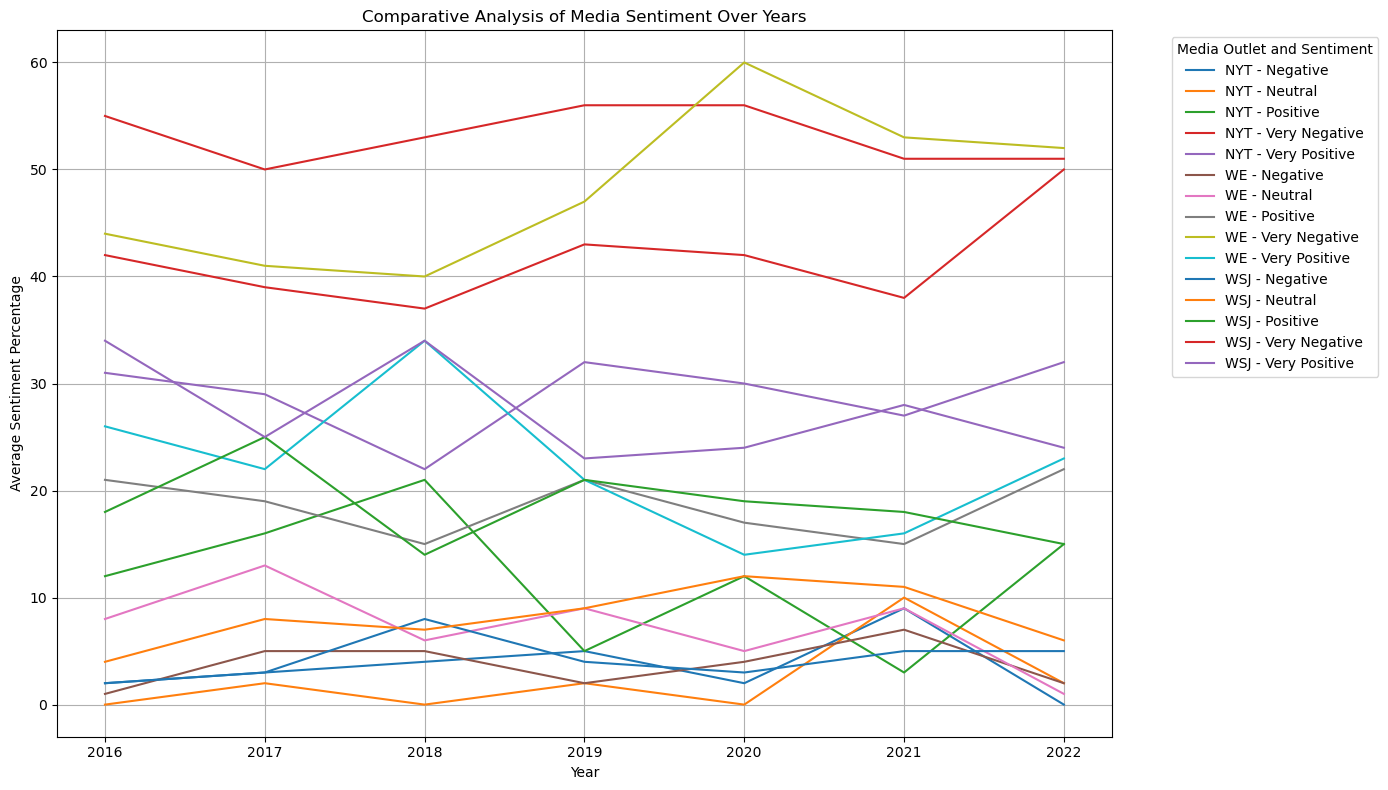

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate the average sentiment for each media outlet per year
avg_sentiment_per_year = sentiment_df.groupby(['Source', 'Year', 'Sentiment']).mean().reset_index()

# Pivot the DataFrame for plotting
pivot_df = avg_sentiment_per_year.pivot_table(index='Year', columns=['Source', 'Sentiment'], values='Percentage')

print(pivot_df)

# Plotting
plt.figure(figsize=(14, 8))
for source in pivot_df.columns.levels[0]:
    for sentiment in pivot_df.columns.levels[1]:
        plt.plot(pivot_df[source, sentiment], label=f'{source} - {sentiment}')

plt.title('Comparative Analysis of Media Sentiment Over Years')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Percentage')
plt.legend(title='Media Outlet and Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Now, let's try comparing actual homeless count trend to our sentiment analysis plot. For this, we need to normalize both the sentiment percentages and the homeless count data. To do this, we can use Min-Max normalization (range between 0 and 1).

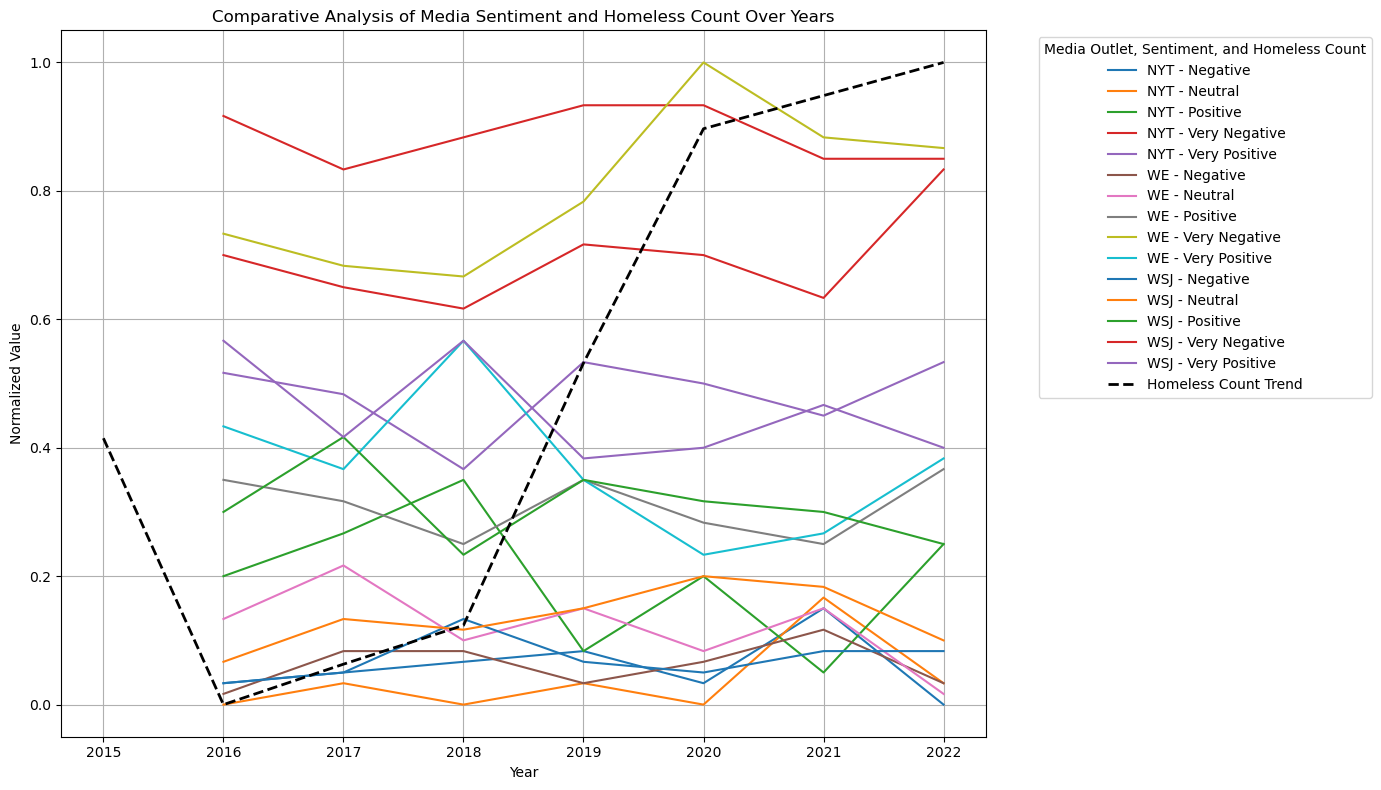

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


# Normalize the sentiment data
scaler = MinMaxScaler()
avg_sentiment_per_year = sentiment_df.groupby(['Source', 'Year', 'Sentiment']).mean().reset_index()
avg_sentiment_per_year['Normalized_Percentage'] = scaler.fit_transform(avg_sentiment_per_year[['Percentage']])

# Normalize the homeless count data
annual_homeless_counts['Normalized_Homeless'] = scaler.fit_transform(annual_homeless_counts[['Overall Homeless']])

# Pivot the dataframe for plotting
pivot_df = avg_sentiment_per_year.pivot_table(index='Year', columns=['Source', 'Sentiment'], values='Normalized_Percentage')

# Plotting
plt.figure(figsize=(14, 8))
for source in pivot_df.columns.levels[0]:
    for sentiment in pivot_df.columns.levels[1]:
        plt.plot(pivot_df[source, sentiment], label=f'{source} - {sentiment}')

# Add the homeless count trend line
plt.plot(annual_homeless_counts['Year'], annual_homeless_counts['Normalized_Homeless'], label='Homeless Count Trend', color='black', linewidth=2, linestyle='--')

plt.title('Comparative Analysis of Media Sentiment and Homeless Count Over Years')
plt.xlabel('Year')
plt.ylabel('Normalized Value')
plt.legend(title='Media Outlet, Sentiment, and Homeless Count', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


This time, let's try modifying the plot for each media outlet to include lines for newly categorized sentiments, to streamline the comparison.

- 'Very Negative' and 'Negative' are grouped as 'Overall Negative', 
- 'Positive' and 'Very Positive' are grouped as 'Overall Positive'. 

This approach simplifies the analysis by focusing on broader sentiment trends.


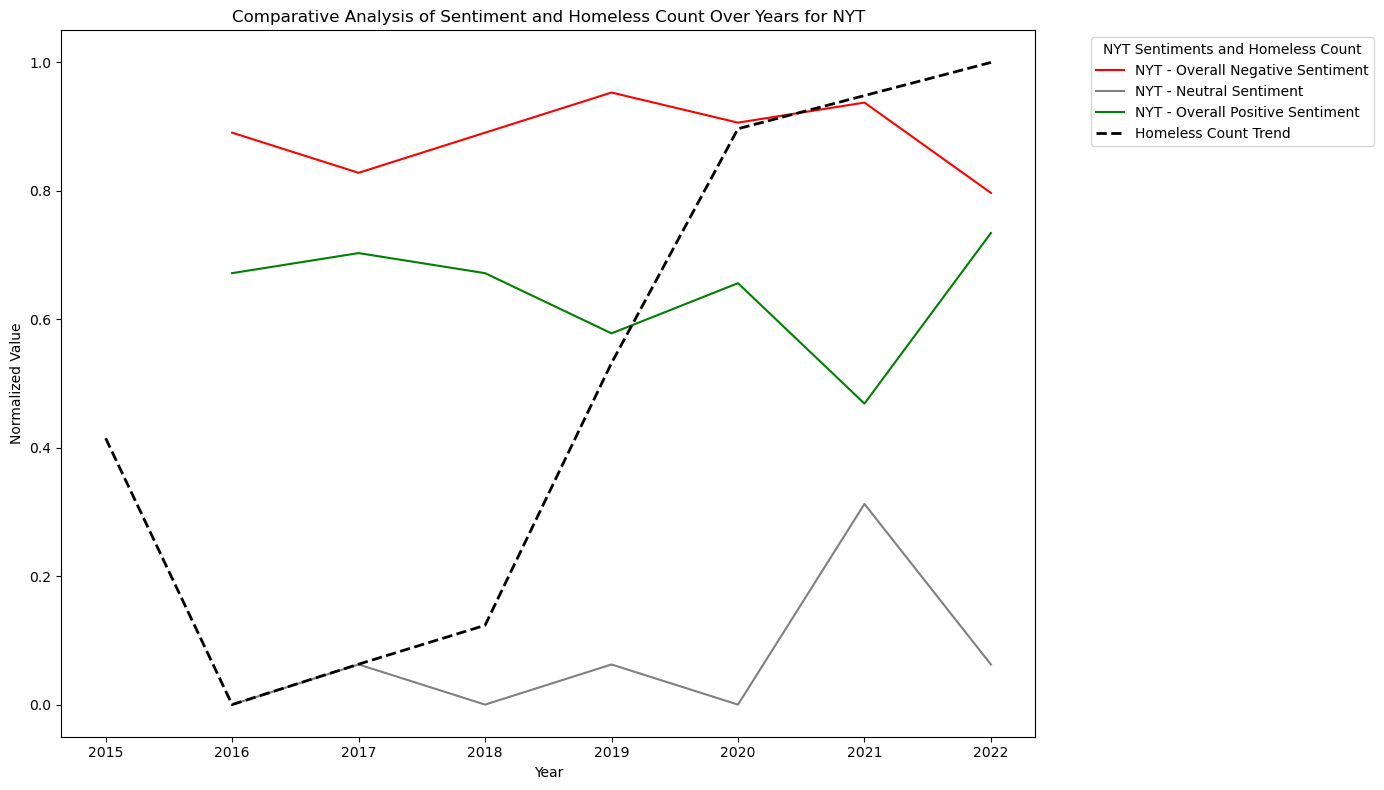

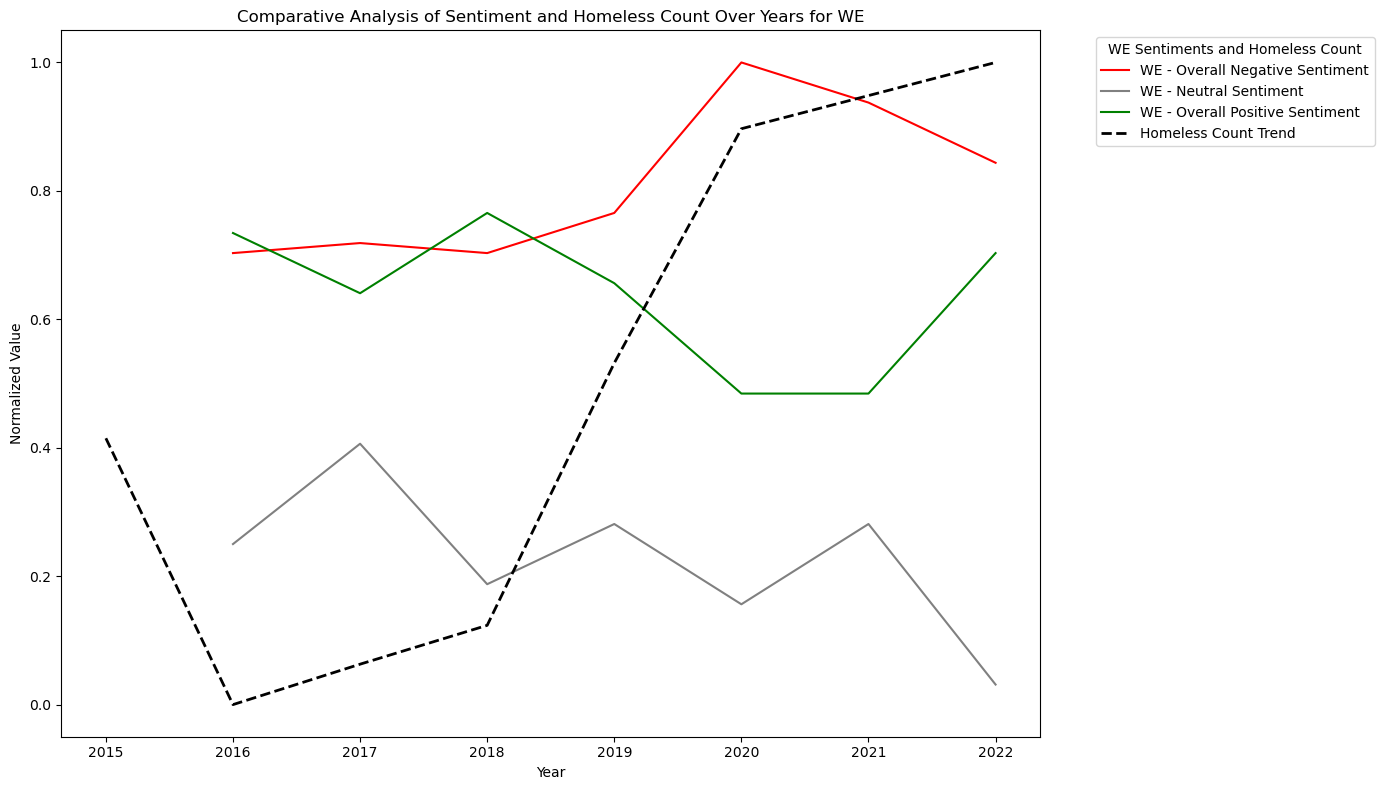

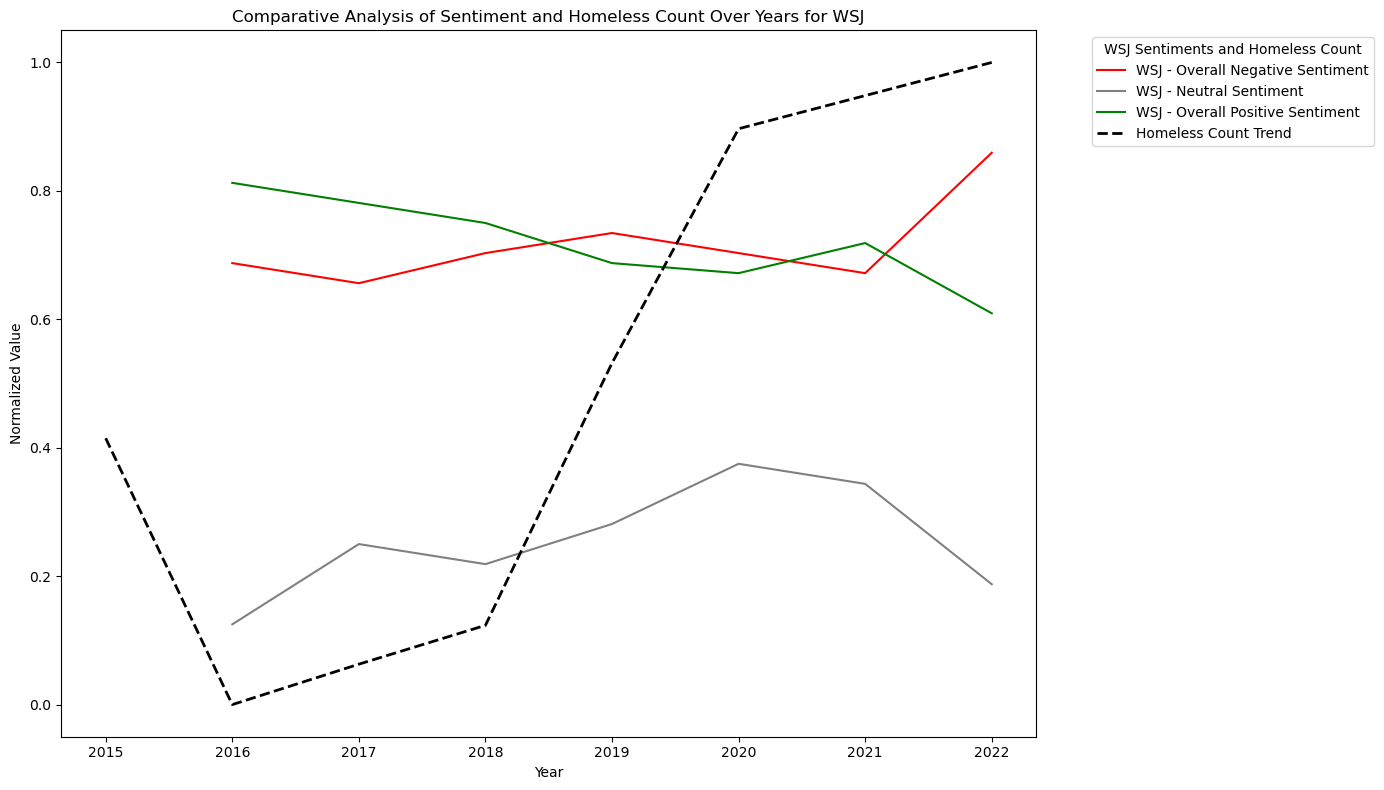

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Normalize the sentiment data
scaler = MinMaxScaler()
sentiment_df['Grouped_Sentiment'] = sentiment_df['Sentiment'].replace({
    'Very Negative': 'Overall Negative',
    'Negative': 'Overall Negative',
    'Neutral': 'Neutral',  
    'Positive': 'Overall Positive',
    'Very Positive': 'Overall Positive'
})
avg_sentiment_per_year = sentiment_df.groupby(['Source', 'Year', 'Grouped_Sentiment']).mean(numeric_only=True).reset_index()
avg_sentiment_per_year['Normalized_Percentage'] = scaler.fit_transform(avg_sentiment_per_year[['Percentage']])

# Normalize the homeless count data
annual_homeless_counts['Normalized_Homeless'] = scaler.fit_transform(annual_homeless_counts[['Overall Homeless']])

# Plotting
media_outlets = avg_sentiment_per_year['Source'].unique()
for outlet in media_outlets:
    plt.figure(figsize=(14, 8))
    pivot_avg_sentiment = avg_sentiment_per_year[avg_sentiment_per_year['Source'] == outlet].pivot_table(index='Year', columns='Grouped_Sentiment', values='Normalized_Percentage')

    for sentiment in ['Overall Negative', 'Neutral', 'Overall Positive']:
        if sentiment in pivot_avg_sentiment.columns:
            color_map = {
                'Overall Negative': 'red',
                'Neutral': 'gray',
                'Overall Positive': 'green'
            }
            plt.plot(pivot_avg_sentiment[sentiment], label=f'{outlet} - {sentiment} Sentiment', color=color_map[sentiment])

    plt.plot(annual_homeless_counts['Year'], annual_homeless_counts['Normalized_Homeless'], label='Homeless Count Trend', color='black', linewidth=2, linestyle='--')

    plt.title(f'Comparative Analysis of Sentiment and Homeless Count Over Years for {outlet}')
    plt.xlabel('Year')
    plt.ylabel('Normalized Value')
    plt.legend(title=f'{outlet} Sentiments and Homeless Count', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(False)
    plt.tight_layout()
    plt.show()


Interpretation:

In analyzing all three media outlets, we can observe a consistent pattern in the way overall negative and positive sentiment numbers respond to changes in the homeless count trend. When the homeless count increases, there is a corresponding increase in overall negative sentiment, coupled with a decrease in overall positive sentiment. However, it's important to note that the extent of these changes varies among the different media outlets.

Interestingly, the sentiment gap between positive and negative sentiments remains relatively stable in the case of WSJ (Center), while it experiences significant fluctuations in the case of WE (Right) in response to changes in the homeless count trend. By comparing these three plots, we can infer that WE is the most responsive in reflecting the reality of changes in homeless counts, followed by NYT, and then WSJ. If we can agree that these media outlets represent different ideological wings (NYT for the left, WSJ for the center, and WE for the right), we can conclude that Right-wing media outlets are more adept at representing trends in homeless count changes, followed by left-wing and center-wing outlets. Center wings are trying to keep a consistent tone, maintaining a relatively stable sentiment, even during periods of significant fluctuation in homelessness.

Another noteworthy observation is that during the period of substantial increases in homeless counts from 2018 to 2020, all media outlets tended to express more negative sentiment, even though the change was less pronounced in WSJ. However, as the rate of homeless count increase moderated from 2020 to 2022, NYT and WE began to exhibit more positive sentiment compared to the previous year, while WSJ displayed a notably more negative sentiment than in previous years.

Conclusion:
    
This comparative analysis of media sentiment underscores distinct patterns in how media outlets respond to homelessness trends, influenced by their political leanings. 

The Washington Examiner (Right) displays the most pronounced response, with a marked increase in negative sentiment correlating strongly with rising homeless counts. This suggests a narrative intensely reactive to changes in societal issues.

In contrast, The New York Times (Left) adopts a more measured approach, with a less pronounced but still noticeable increase in negative sentiment during periods of heightened homelessness. 

The Wall Street Journal (Center) strives for a balanced narrative, maintaining relative stability in sentiment despite fluctuations in homelessness.

Overall, our findings reveal that while each outlet reflects changes in homelessness, the extent and nature of their response are distinctly shaped by their political orientations. 


We have completed the initial stages of our analysis, encompassing all media outlets as a collective unit. In the first three steps, we engaged in scraping and examining news headlines spanning several years. Subsequent steps, four through six, involved conducting a sentiment analysis and creating visualizations to represent these findings over multiple years.

The next phase of our project will enhance our ability to visually discern how media sentiment—this time with a focus on more detailed sentiments.

# Part 7

7. Detailed Sentiment Analysis by Media Outlet:
    * Categorize Media Outlets: Assign categories to the media outlets based on their political leanings.
    * Adjust and Calculate Sentiment Scores: Aggregate sentiment scores by these categories.
    * Comparative Analysis and Visualization: Use heatmaps for visualization.

First, we'll categorize each media outlet:

In [15]:
# Categorizing media outlets
media_categories = {
    'NYT': 'Left',
    'WSJ': 'Center',
    'WE': 'Right'
}

# Add a new column for the category in the sentiment dataframe
sentiment_df['Category'] = sentiment_df['Source'].map(media_categories)


Next, let's calculate the adjusted sentiment scores:

In [16]:
# Aggregate sentiment scores by category, source, year, and sentiment
agg_sentiment = sentiment_df.groupby(['Category', 'Source', 'Year', 'Sentiment']).mean(numeric_only=True).reset_index()


For the comparative analysis, we'll create visualizations.

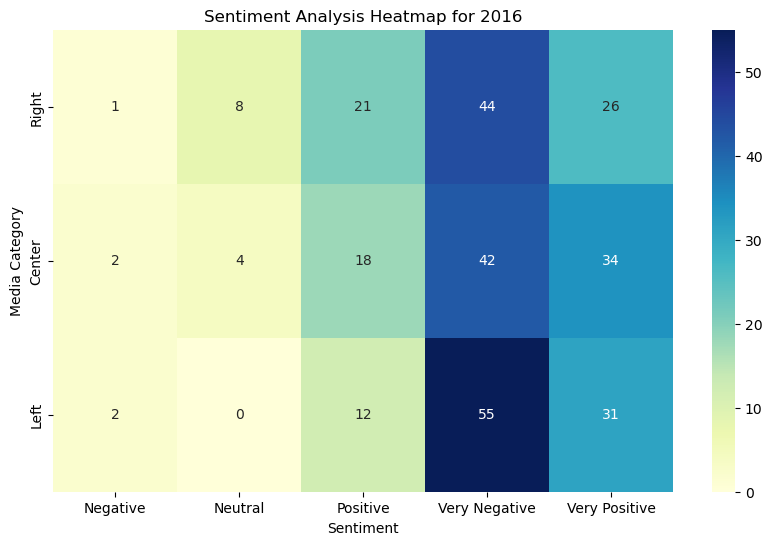

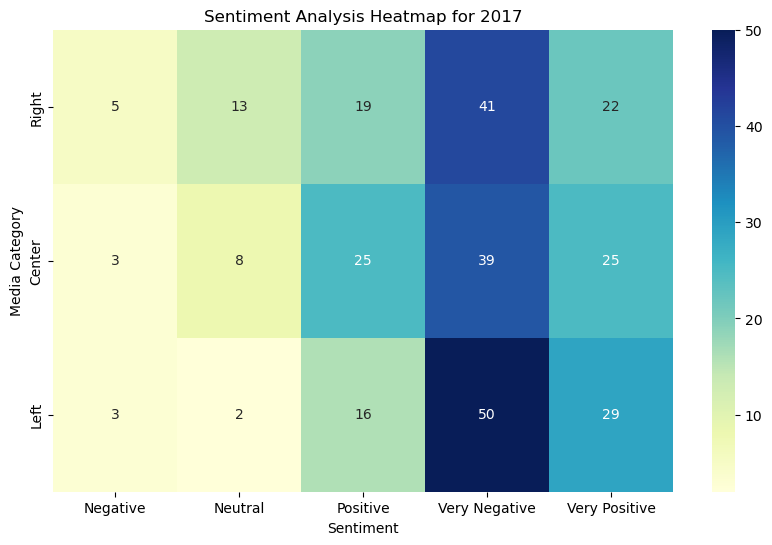

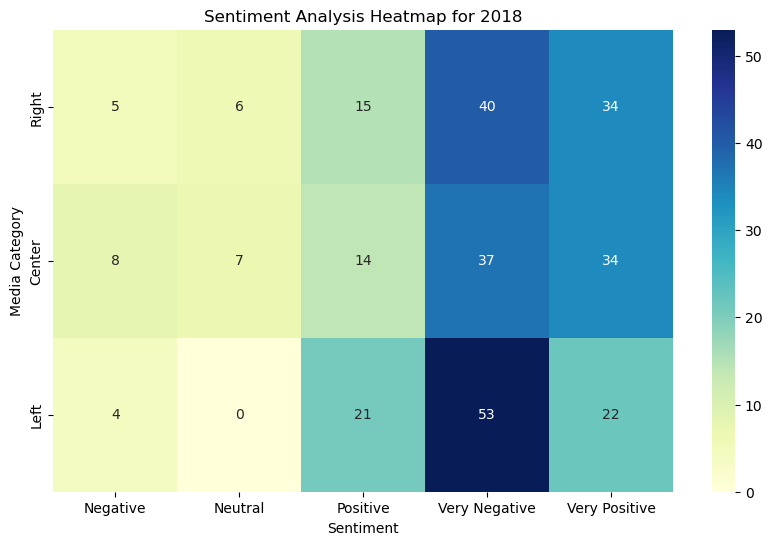

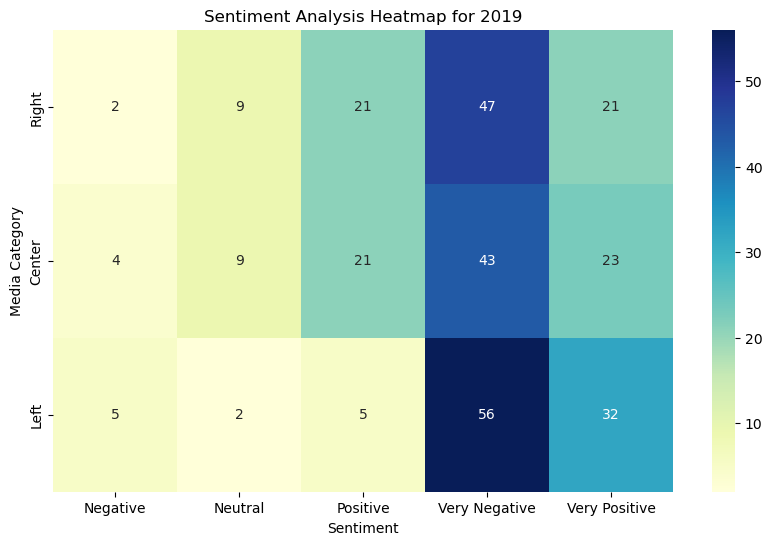

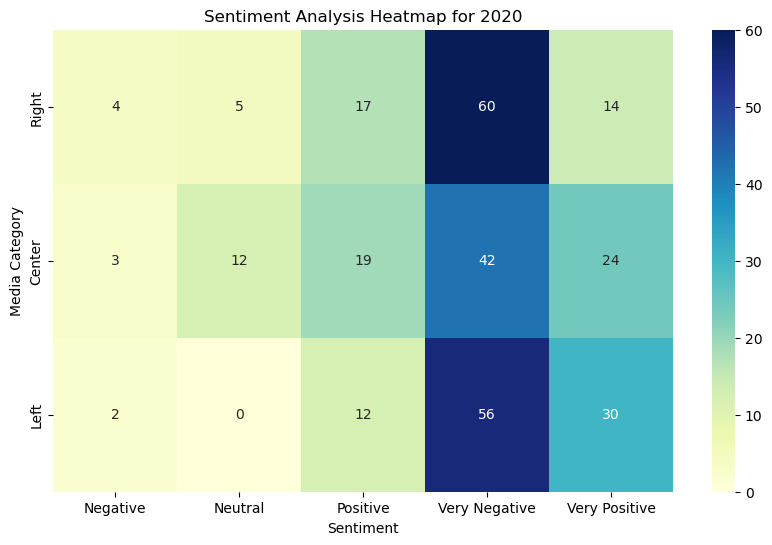

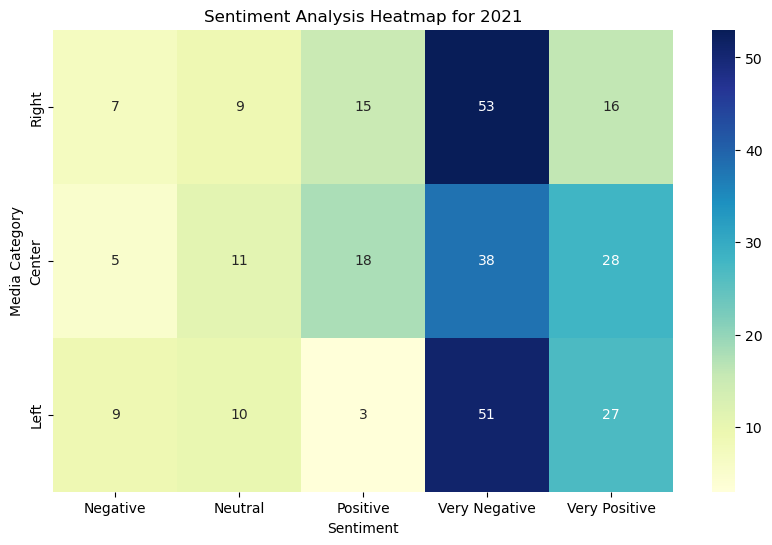

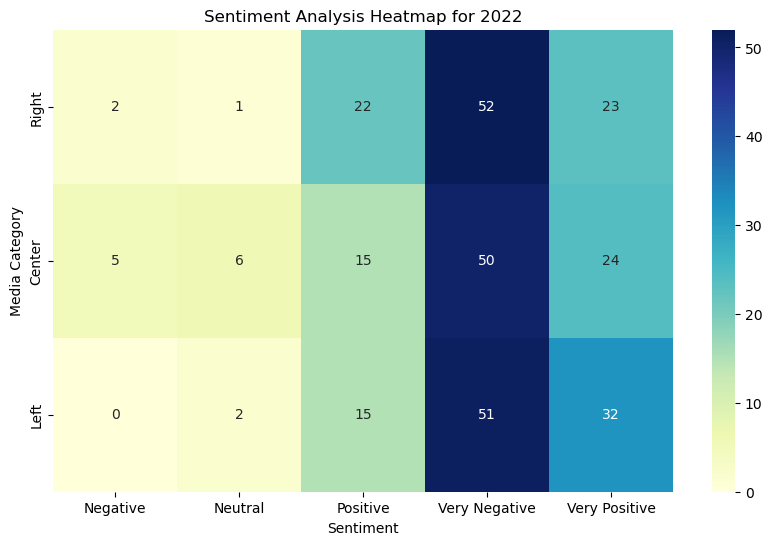

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

years = agg_sentiment['Year'].unique()

# Define order for the media categories
category_order = ['Right', 'Center', 'Left']

for year in sorted(years):
    # Create a copy to avoid the SettingWithCopyWarning
    yearly_data = agg_sentiment[agg_sentiment['Year'] == year].copy()
    
    # Reorder the index by the specified category order
    yearly_data['Category'] = pd.Categorical(yearly_data['Category'], categories=category_order, ordered=True)
    pivot_yearly_data = yearly_data.pivot_table(index='Category', columns='Sentiment', values='Percentage').sort_index(ascending=True)
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_yearly_data, annot=True, cmap="YlGnBu")
    plt.title(f'Sentiment Analysis Heatmap for {year}')
    plt.xlabel('Sentiment')
    plt.ylabel('Media Category')
    plt.show()


Interpretation:

The heatmap analysis from 2016 to 2022 bolsters our initial observations, highlighting how media sentiment fluctuates in response to homelessness trends and varies according to political orientation, as noted in our earlier analysis.

The Right-wing media, particularly in years like 2018 and 2020, exhibits significant shifts towards negative sentiment when homelessness counts rise. This aligns with the earlier finding that Right-wing outlets, such as the Washington Examiner (WE), show a heightened responsiveness to changes in societal issues, particularly homelessness. Their pronounced reaction to homelessness trends reflects a narrative intensely reactive to societal changes.

Center media, represented by outlets like The Wall Street Journal (WSJ), maintains a more consistent sentiment distribution. However, it's notable that even they show a peak in negativity in 2020, resonating with the previous analysis that Center-wing media attempts to maintain a balanced narrative, yet still responds to significant fluctuations in homelessness.

The Left-wing media, echoing the sentiments of The New York Times (NYT), consistently displays very negative sentiment towards homelessness, with a slight positive shift in later years. This trend underlines the continuous narrative of concern highlighted in the previous analysis, indicating that Left-wing media consistently addresses homelessness, albeit with subtle changes in tone.

Next, before combining all the analysis and insights we have gathered so far, we are going to provide a quantifiable measure of how media sentiment aligns with changes in homeless populations.This phase involves a more numerical approach: we will assess the correlation between the overall sentiment of each media outlet and the homeless count by calculating correlation coefficients, for the overall years.  

# Part 8

8. Correlation Analysis Between Homelessness Data and Sentiment:
    * First, check statistical assumptions for correlation (normality, linearity, homoscedasticity, independence).
    * Use correlation coefficients to quantify relationships.

Before proceeding with correlation analysis, it's important to check for normality, linearity, homoscedasticity, and independence. Let's check statistical assumptions.

In [18]:
from scipy.stats import shapiro

# Test for normality
stat, p = shapiro(annual_homeless_counts['Overall Homeless'])
print('Homeless Count Normality: Statistics=%.3f, p=%.3f' % (stat, p))

# Check the distribution of sentiment percentages
for sentiment in ['Overall Negative', 'Neutral', 'Overall Positive']:
    stat, p = shapiro(avg_sentiment_per_year[avg_sentiment_per_year['Grouped_Sentiment'] == sentiment]['Percentage'])
    print(f'{sentiment} Sentiment Normality: Statistics=%.3f, p=%.3f' % (stat, p))


Homeless Count Normality: Statistics=0.880, p=0.187
Overall Negative Sentiment Normality: Statistics=0.917, p=0.077
Neutral Sentiment Normality: Statistics=0.937, p=0.186
Overall Positive Sentiment Normality: Statistics=0.917, p=0.074


The output from our Shapiro-Wilk test for normality indicates that the data for homeless counts and the sentiments (Overall Negative, Neutral, and Overall Positive) do not significantly deviate from a normal distribution. Therefore, we can proceed with statistical methods that assume normal distribution now.

Next, merge sentiment and homeless count data

In [21]:
# Merge the sentiment and homeless count data
merged_data = avg_sentiment_per_year.merge(annual_homeless_counts, on='Year')


For the next assumption, independence. Since the data points represent different years and the data collection process was independent from year to year, then this assumption should be satisfied. 

And here, let's check  linearity and homoscedasticity using scatter plots.

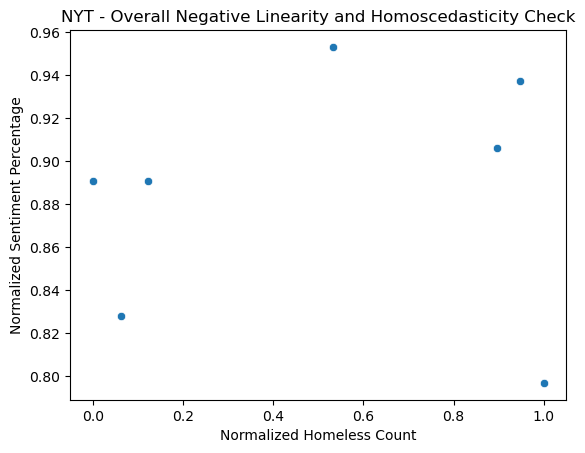

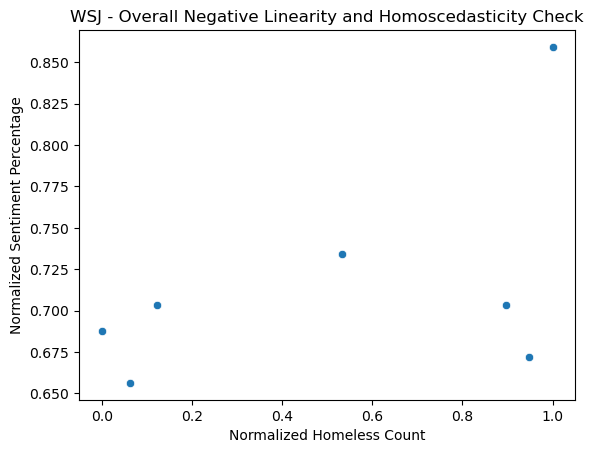

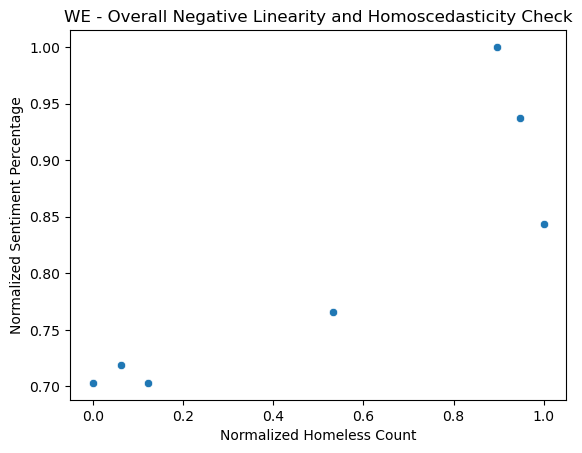

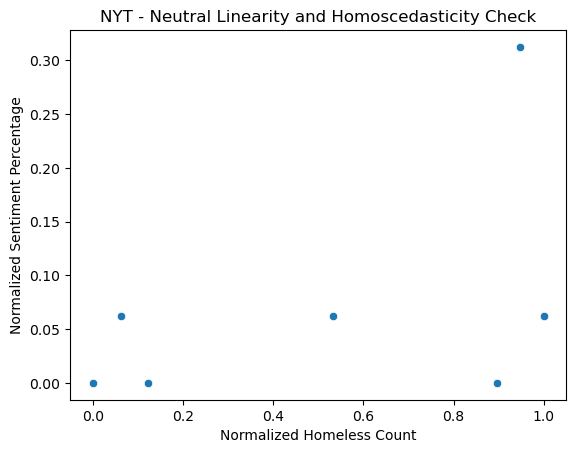

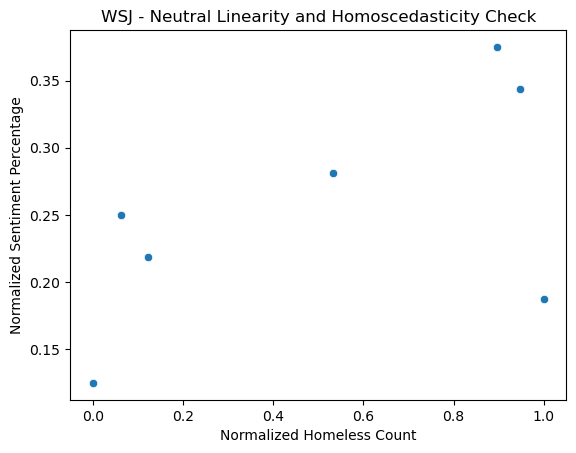

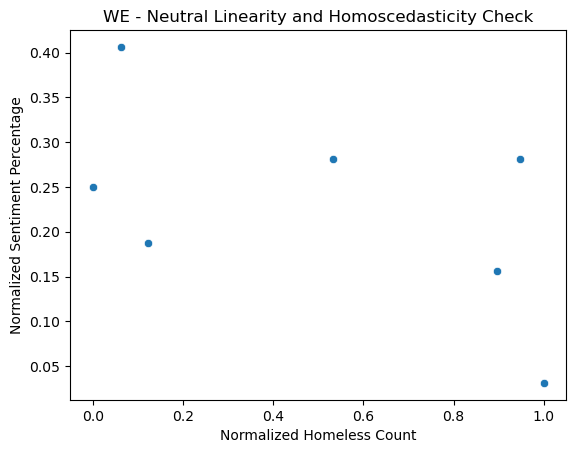

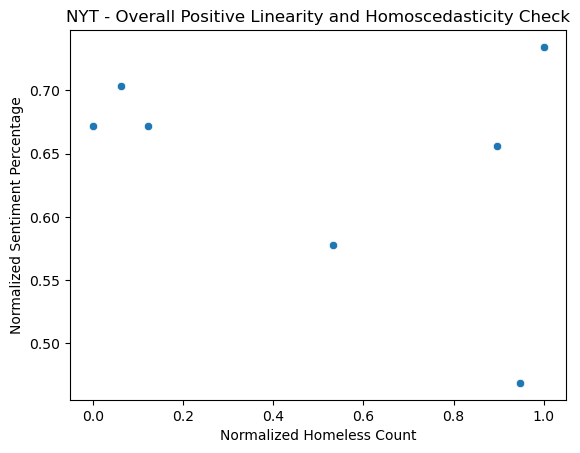

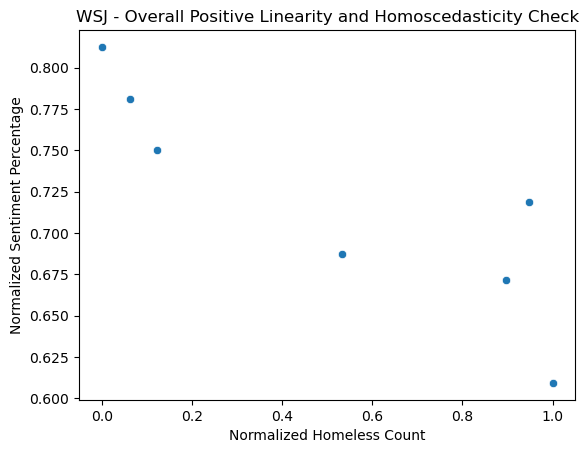

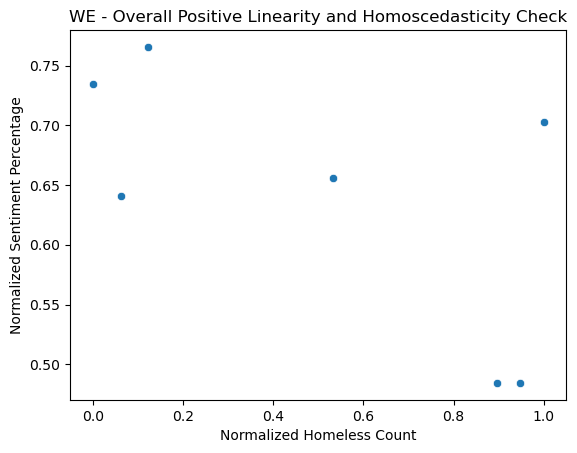

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

for sentiment in ['Overall Negative', 'Neutral', 'Overall Positive']:
    for source in ['NYT', 'WSJ', 'WE']:
        sns.scatterplot(x='Normalized_Homeless', y='Normalized_Percentage', 
                        data=merged_data[(merged_data['Grouped_Sentiment'] == sentiment) & (merged_data['Source'] == source)])
        plt.title(f'{source} - {sentiment} Linearity and Homoscedasticity Check')
        plt.xlabel('Normalized Homeless Count')
        plt.ylabel('Normalized Sentiment Percentage')
        plt.show()


Visual inspection of scatter plots suggests that while perfect linearity and homoscedasticity are not evident, the data does not exhibit strong non-linearity or clear patterns of heteroscedasticity.

Given these findings, we proceeded with Pearson’s correlation analysis, recognizing that while the assumptions are not strictly satisfied, the observed deviations appear to be minor and not excessively influential on the overall trends. 

However, we should note that these factors introduce a degree of uncertainty into the correlation estimates. Further studies, potentially involving larger datasets and robust statistical techniques, would be beneficial to confirm the observed relationships.

Now, let's start on calculating correlation coefficients to explore the strength and direction of the relationship between media sentiment and homeless counts.

In [21]:
# Preparing data for correlation analysis
corr_data = merged_data.pivot_table(index='Year', columns=['Source', 'Grouped_Sentiment'], values='Normalized_Percentage')

# Flatten the multi-level columns if necessary
corr_data.columns = [' '.join(col).strip() for col in corr_data.columns.values]

# Join with the normalized homeless count
corr_data = corr_data.join(annual_homeless_counts.set_index('Year')['Normalized_Homeless'])

# Calculate correlation
correlation_results = corr_data.corr()

print("Correlation between Homeless Counts and Sentiments:\n")
print(correlation_results.loc['Normalized_Homeless'])


Correlation between Homeless Counts and Sentiments:

NYT Neutral             0.477640
NYT Overall Negative    0.066187
NYT Overall Positive   -0.336196
WE Neutral             -0.554699
WE Overall Negative     0.876267
WE Overall Positive    -0.639301
WSJ Neutral             0.579663
WSJ Overall Negative    0.510798
WSJ Overall Positive   -0.864820
Normalized_Homeless     1.000000
Name: Normalized_Homeless, dtype: float64


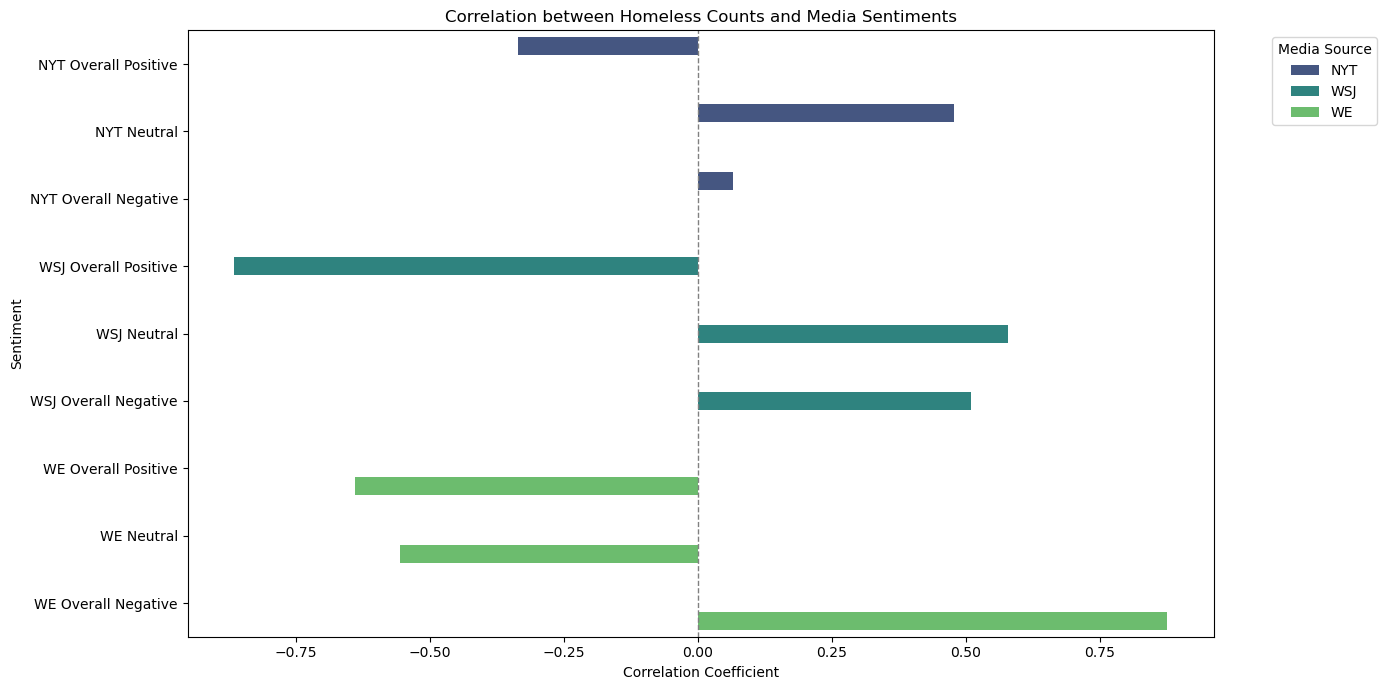

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation data
correlation_data = {
    "NYT Neutral": 0.477640,
    "NYT Overall Negative": 0.066187,
    "NYT Overall Positive": -0.336196,
    "WE Neutral": -0.554699,
    "WE Overall Negative": 0.876267,
    "WE Overall Positive": -0.639301,
    "WSJ Neutral": 0.579663,
    "WSJ Overall Negative": 0.510798,
    "WSJ Overall Positive": -0.864820
}

# Creating a dataframe
correlation_df = pd.DataFrame(correlation_data.items(), columns=['Sentiment', 'Correlation'])

# Extracting the source from the sentiment
correlation_df['Source'] = correlation_df['Sentiment'].apply(lambda x: x.split()[0])

# Reordering the sentiments
ordered_sentiments = [
    'NYT Overall Positive', 'NYT Neutral', 'NYT Overall Negative',
    'WSJ Overall Positive', 'WSJ Neutral', 'WSJ Overall Negative',
    'WE Overall Positive', 'WE Neutral', 'WE Overall Negative'
]

# Filtering and reordering the dataframe
correlation_df_ordered = correlation_df.set_index('Sentiment').loc[ordered_sentiments].reset_index()

# Plotting 
plt.figure(figsize=(14, 7))
sns.barplot(x='Correlation', y='Sentiment', hue='Source', data=correlation_df_ordered, palette="viridis")
plt.title('Correlation between Homeless Counts and Media Sentiments')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Sentiment')
plt.legend(title='Media Source', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axvline(x=0, color='grey', lw=1, linestyle='--')
plt.tight_layout()
plt.show()


Interpretation:

The New York Times (Left):

- Overall Positive Sentiment: Moderate negative correlation

- Neutral Sentiment: Moderate positive correlation

- Overall Negative Sentiment: Very weak positive correlation


The Wall Street Journal (Center):

- Overall Positive Sentiment: Strong negative correlation

- Neutral Sentiment: Moderate positive correlation

- Overall Negative Sentiment: Moderate positive correlation


The Washington Examiner (Right):

- Overall Positive Sentiment: Strong negative correlation

- Neutral Sentiment: Moderate negative correlation

- Overall Negative Sentiment: Strong positive correlation


Summary:

This analysis suggests that The Washington Examiner's coverage aligns more closely with actual changes in homeless counts, particularly by increasing negative sentiment as homeless counts rise. Conversely, The Wall Street Journal and The New York Times tend to display a decrease in positive sentiment as homeless numbers increase, though the strength of this relationship varies. However, to fully grasp the narratives presented by different media outlets, it is crucial to consider these correlations within the broader context of political climates, significant events, policy changes, and public opinion. We will talk more about this in the next (last) part, 'Media Sentiment- Comprehensive Conclusion'.

-----

# Media Sentiment- Comprehensive Conclusion

Our extensive analysis of media sentiment toward homelessness, through the multifaceted lenses of sentiment analysis, correlation with homeless counts, word frequency, and topic modeling, reveals a complex tapestry of media narratives deeply influenced by political orientations and societal contexts.

1. Synthesis of Key Findings:

- Sentiment Analysis Trends:

    - The New York Times (Left): Exhibited a persistent 'Very Negative' sentiment, interspersed with moments of 'Very Positive' perspectives. This dichotomy suggests a critical approach to homelessness, balanced by episodic optimistic reporting, possibly highlighting success stories or effective policy interventions.
    
    - The Wall Street Journal (Center): Maintained a predominant 'Neutral' stance, reflecting a journalistic approach focused on balanced reporting. This neutrality, however, did not preclude the outlet from occasionally leaning towards negative sentiments, especially during periods of rising homeless counts.

    - The Washington Examiner (Right): Showed a tendency towards more critical coverage, with the least amount of 'Very Positive' sentiment. This aligns with a narrative style that perhaps emphasizes the gravity and challenges of homelessness, possibly critiquing policy failures or societal shortcomings.


2. Correlation with Homeless Counts:
- Each outlet's sentiment towards homelessness exhibited varying degrees of correlation with actual homeless counts. The Washington Examiner's (Right) coverage most closely mirrored changes in homelessness, with a marked increase in negative sentiment corresponding with rising homeless counts. This suggests a narrative deeply responsive to the severity of the homelessness crisis. Conversely, The Wall Street Journal (Center) and The New York Times (Left) displayed a more moderated response, with a focus on maintaining a balanced or cautiously optimistic narrative, despite the fluctuations in homelessness figures.

3. Word Frequency and Topic Modeling Insights:
- The topical focus and language used by the different outlets revealed their unique editorial angles and perspectives on homelessness. We observed a range of themes, from policy and political discussions in The New York Times (Left) to societal and infrastructural considerations in The Wall Street Journal (Center), and a more politically charged narrative from The Washington Examiner (Right).

- The prevalence of specific terms like "shelters," "policy," and "crisis" across the outlets indicates a shared recognition of the systemic nature of homelessness, yet the emphasis varied, reflecting each outlet's editorial focus and ideological stance.





Integrating the Insights:

- This multi-dimensional analysis illuminates how media outlets not only report on homelessness but also frame the issue through their distinct ideological lenses. The interplay of sentiment, topical focus, and word choice creates narratives that both reflect and shape public understanding and discourse around homelessness.

- The Washington Examiner (Right) emerges as the most responsive to the changing realities of homelessness, with a narrative that amplifies societal concerns. The New York Times (Left), while critical, incorporates a diverse range of topics, possibly aiming to contextualize homelessness within broader societal and policy frameworks. The Wall Street Journal (Center) balances these approaches, maintaining a consistent narrative tone while navigating the complexities of the issue.


Final Thoughts:

- This comprehensive analysis underscores the pivotal role media outlets play in shaping societal perceptions of complex issues like homelessness. By understanding the nuances in their narratives, we can better appreciate the multifaceted nature of homelessness and the diverse viewpoints that contribute to the public discourse. This insight is invaluable not only for media consumers seeking a more rounded understanding of homelessness but also for policymakers, advocates, and researchers who navigate these narratives to influence policy and public opinion.